In [2]:
library(edgeR)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(scales)
library(gridExtra)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(biomaRt)
library(patchwork)
library(ComplexHeatmap)
library(circlize)
library(ChIPseeker)
library(dplyr)
library(ggrastr)
#library(forcats)

In [3]:
no_na = function(x) {
    return(x[!is.na(x)])
}

## 1. Peak files and featureCounts

In [ ]:
# this was in 220219_633_atac_cutandrun_analysis.r.ipynb 
# peaks are called using the old sykes data 

# get only peaks that are in both replicates for each timepoint, and take the peak from the first replicate
# peaks must overlap by at least half  
! parallel -j 8 "bedtools intersect -a 633_BRQ{}_rep1_ATACseq_peaks.narrowPeak \
-b 633_BRQ{}_rep2_ATACseq_peaks.narrowPeak -f 0.5 -r -wa > 633_BRQ{}_peaks_comb.bed" ::: 0 12 24 48
! parallel -j 8 "bedtools intersect -a 633_E2wd{}_rep1_ATACseq_peaks.narrowPeak \
-b 633_E2wd{}_rep2_ATACseq_peaks.narrowPeak -f 0.5 -r -wa > 633_E2wd{}_peaks_comb.bed" ::: 0 12 24 48 72 96 120

# make a single file of all peaks, disallowing 50bp overlap
! cat *_peaks_comb.bed | sort -k1,1 -k2,2n | bedtools merge -i - -d 50 > ../../intermediate_files/633_all_peaks.bed
! awk 'BEGIN {{OFS="\t"; print("GeneID", "Chr", "Start", "End", "Strand")}}; \
      {{print("peak" NR,$1,$2,$3,"+")}}' ../../intermediate_files/633_all_peaks.bed > \
      ../../intermediate_files/633_all_peaks.saf


# featureCounts
# -p is paired-end, -T is threads, -O is allowing multi overlap, -M is a multimapper, 
# --fraction relates to both -M and -O

# doing this in data/files/221218Van
! module load subread
! featureCounts -T 10 -p -O -M --fraction -F SAF -a \
/home/briando/data/differentiation_manuscript/atacseq_analysis/intermediate_files/633_all_peaks.saf \
-o 231220_633_atac_k27ac_counts.txt \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_DMSO24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_DMSO24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ8_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ8_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ16_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ16_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_BRQ24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_E2wd24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/210922Van/results/bowtie2_bam/633_E2wd24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ0_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ0_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ8_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ8_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ12_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ12_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ48_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_BRQ48_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd8_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd8_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd12_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd12_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd24_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd24_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd48_rep1_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/differentiation_manuscript/atacseq_analysis/results/bowtie2_bam/633_E2wd48_rep2_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_DMSO_24h_rep1_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_DMSO_24h_rep2_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_BRQ_2uM_8h_rep1_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_BRQ_2uM_8h_rep2_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_BRQ_2uM_24h_rep1_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_BRQ_2uM_24h_rep2_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_E2wd_8h_rep1_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_E2wd_8h_rep2_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_E2wd_24h_rep1_aligned_sorted_noblacklist.bam \
/home/briando/data/files/221218Van/results/bowtie2_bam/H3K27ac_E2wd_24h_rep2_aligned_sorted_noblacklist.bam \
/home/briando/data/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/63.3_DMSO_H3K4me1_aligned_sorted.bam \
/home/briando/data/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/63.3_BRQ_H3K4me1_aligned_sorted.bam \
/home/briando/data/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/63.3_DMSO_H3K27me3_aligned_sorted.bam \
/home/briando/data/differentiation_manuscript/cutandrun_analysis/results/bowtie2_bam/63.3_BRQ_H3K27me3_aligned_sorted.bam

## Differential peaks and LFC calculations

In [4]:
#df = read.table("../data/230105_633_atac_k27ac_counts.txt", header = TRUE, row.names=1)
df = read.table("../data/231220_633_atac_k27ac_counts.txt", header = TRUE, row.names=1)  # has H3K4me1
peak_info = df[,1:6]
df = df[,6:dim(df)[2]]
colnames(df) = gsub("X.home.briando.data.files.210922Van.results.bowtie2_bam.633_", "newatac_", 
                   gsub("_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam", "", colnames(df)))
colnames(df) = gsub("X.home.briando.data.differentiation_manuscript.atacseq_analysis.results.bowtie2_bam.633_", "oldatac_", 
                   gsub("_ATACseq_aligned_reads_sorted_nodup_noblacklist_noM.bam", "", colnames(df)))
colnames(df) = gsub("X.home.briando.data.differentiation_manuscript.cutandrun_analysis.results.bowtie2_bam.63.3_", "cr_", 
                   gsub("_aligned_sorted.bam", "", colnames(df)))
colnames(df) = gsub("X.home.briando.data.files.221218Van.results.bowtie2_bam.", "", 
                   gsub("_aligned_sorted_noblacklist.bam", "", colnames(df)))
colnames(df) = gsub("BRQ_2uM_", "BRQ", 
                   gsub("E2wd_", "E2wd", colnames(df)))
head(df)
dim(df)

newatac_DMSO24_rep1 newatac_DMSO24_rep2 newatac_BRQ8_rep1
peak1  5                   2                   13              
peak2 26                  30                   66              
peak3 29                  54                  106              
peak4 13                  15                   17              
peak5  1                   3                    4              
peak6  4                   8                   10              
      newatac_BRQ8_rep2 newatac_BRQ16_rep1 newatac_BRQ16_rep2
peak1  6                 30                 24               
peak2 42                103                 92               
peak3 70                146                147               
peak4 21                 57                 72               
peak5  2                 17                  8               
peak6  4                 39                 37               
      newatac_BRQ24_rep1 newatac_BRQ24_rep2 newatac_E2wd24_rep1
peak1  27                 27                 7                 
peak2  70                116                48                 
peak3 108                151                68                 
peak4  63                 97                 7                 
peak5  12                 22                 6                 
peak6  39                 59                 8                 
      newatac_E2wd24_rep2 ⋯ H3K27ac_BRQ24h_rep1 H3K27ac_BRQ24h_rep2
peak1  7                  ⋯ 10                   8                 
peak2 35                  ⋯ 59                  25                 
peak3 34                  ⋯ 76                  48                 
peak4  9                  ⋯ 47                  18                 
peak5  5                  ⋯ 25                  20                 
peak6  4                  ⋯ 54                  41                 
      H3K27ac_E2wd8h_rep1 H3K27ac_E2wd8h_rep2 H3K27ac_E2wd24h_rep1
peak1  3                   3                   3                  
peak2 13                  24                  26                  
peak3 29                  43                  30                  
peak4  6                  11                  10                  
peak5  6                   3                  10                  
peak6 13                  15                  13                  
      H3K27ac_E2wd24h_rep2 cr_DMSO_H3K4me1 cr_BRQ_H3K4me1 cr_DMSO_H3K27me3
peak1  5                    3              15              5              
peak2 38                    7              35              9              
peak3 43                   15              88             13              
peak4  4                   33              72              2              
peak5 10                    5              27              1              
peak6 17                   23              63              1              
      cr_BRQ_H3K27me3
peak1  5             
peak2 11             
peak3 21             
peak4  6             
peak5  2             
peak6  5

[1] 123194     42

In [5]:
newatac = df[,1:10]
oldatac = df[,11:28]
k27ac = df[,29:38]
k4me1_k27me3 = df[,39:42]

get_fit = function(data, n=1, to_drop=F) {
    d0 <- DGEList(data)
    d0 <- calcNormFactors(d0, method="TMM")
    if (to_drop) {
        drop <- which(apply(cpm(d0), 1, max) < n)
        d0 <- d0[-drop,] 
    }
    print(dim(d0)) # number of genes left

    # conditions for differential peak calling
    conds = as.character(sapply(names(data), function(x) strsplit(x,'_')[[1]][2]))
    print(conds)

    # normalize
    mm <- model.matrix(~0 + conds)
    y <- voom(d0, mm, plot = T)
    fit <- lmFit(y, mm)
    #head(coef(fit))

    return(list(fit, conds, y$E))
}
    

[1] 123194     10
 [1] "DMSO24" "DMSO24" "BRQ8"   "BRQ8"   "BRQ16"  "BRQ16"  "BRQ24"  "BRQ24" 
 [9] "E2wd24" "E2wd24"


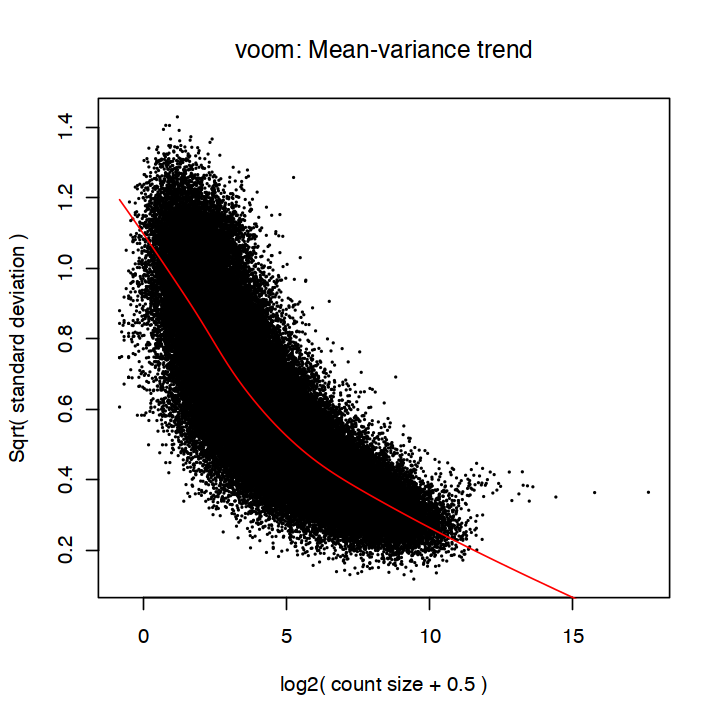

In [6]:
# differential peaks
options(repr.plot.width=6, repr.plot.height=6)
newatac_res = get_fit(newatac)
newatac_fit = newatac_res[[1]]
newatac_conds = newatac_res[[2]]
newatac_norm = as.data.frame(newatac_res[[3]])


[1] 123194     18
 [1] "BRQ0"   "BRQ0"   "BRQ8"   "BRQ8"   "BRQ12"  "BRQ12"  "BRQ24"  "BRQ24" 
 [9] "BRQ48"  "BRQ48"  "E2wd8"  "E2wd8"  "E2wd12" "E2wd12" "E2wd24" "E2wd24"
[17] "E2wd48" "E2wd48"


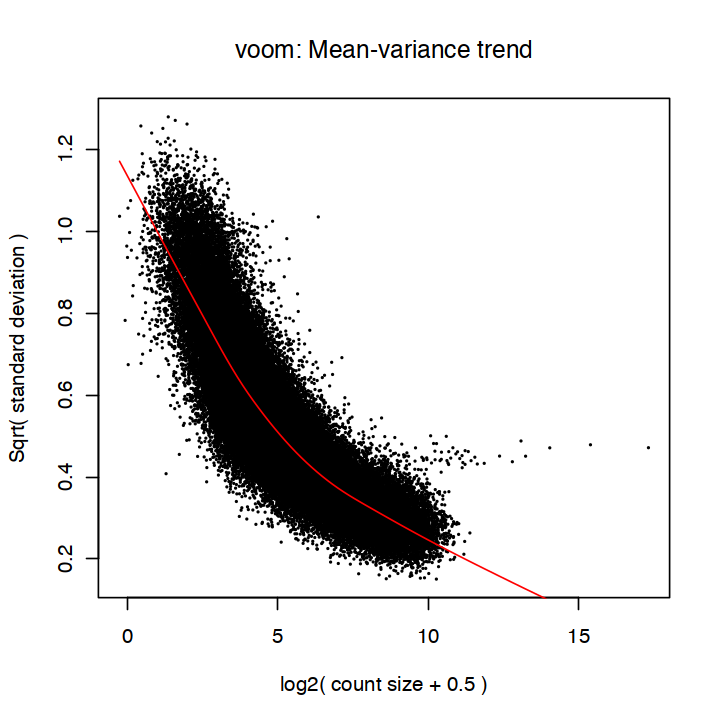

In [7]:
oldatac_res = get_fit(oldatac)
oldatac_fit = oldatac_res[[1]]
oldatac_conds = oldatac_res[[2]]
oldatac_norm = as.data.frame(oldatac_res[[3]])


[1] 123194     10
 [1] "DMSO"    "DMSO"    "BRQ8h"   "BRQ8h"   "BRQ24h"  "BRQ24h"  "E2wd8h" 
 [8] "E2wd8h"  "E2wd24h" "E2wd24h"


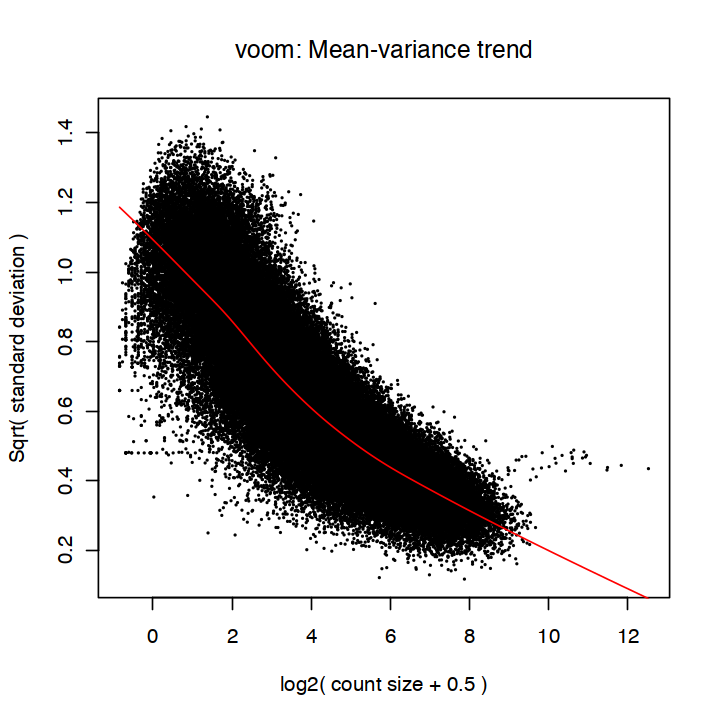

In [8]:
k27ac_res = get_fit(k27ac)
k27ac_fit = k27ac_res[[1]]
k27ac_conds = k27ac_res[[2]]
k27ac_norm = as.data.frame(k27ac_res[[3]])


In [9]:
# get differentially accessible peaks for each condition
process_res = function(fit, contr) {
    tmp <- contrasts.fit(fit, contr)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    return(res)
}

In [10]:
# newatac for BD266 doesn't have the same patterns as old brq with more up than down
# note that in BD355 we see this pattern much more strongly (with HU) suggesting that bd266 data should not be used 
new_b8_dep = process_res(newatac_fit, makeContrasts("condsBRQ8 - condsDMSO24", levels = colnames(coef(newatac_fit))))
new_b16_dep = process_res(newatac_fit, makeContrasts("condsBRQ16 - condsDMSO24", levels = colnames(coef(newatac_fit))))
new_b24_dep = process_res(newatac_fit, makeContrasts("condsBRQ24 - condsDMSO24", levels = colnames(coef(newatac_fit))))
new_e24_dep = process_res(newatac_fit, makeContrasts("condsE2wd24 - condsDMSO24", levels = colnames(coef(newatac_fit))))


In [11]:
dim(subset(new_b8_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(new_b8_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(new_b16_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(new_b16_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(new_b24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(new_b24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(new_e24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(new_e24_dep, logFC > 1 & adj.P.Val < 0.05))

[1] 564   6

[1] 603   6

[1] 3371    6

[1] 3643    6

[1] 5391    6

[1] 5615    6

[1] 7707    6

[1] 8537    6

In [12]:
# oldatac

old_b8_dep = process_res(oldatac_fit, makeContrasts("condsBRQ8 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_b12_dep = process_res(oldatac_fit, makeContrasts("condsBRQ12 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_b24_dep = process_res(oldatac_fit, makeContrasts("condsBRQ24 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_b48_dep = process_res(oldatac_fit, makeContrasts("condsBRQ48 - condsBRQ0", levels = colnames(coef(oldatac_fit))))

old_e8_dep = process_res(oldatac_fit, makeContrasts("condsE2wd8 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_e12_dep = process_res(oldatac_fit, makeContrasts("condsE2wd12 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_e24_dep = process_res(oldatac_fit, makeContrasts("condsE2wd24 - condsBRQ0", levels = colnames(coef(oldatac_fit))))
old_e48_dep = process_res(oldatac_fit, makeContrasts("condsE2wd48 - condsBRQ0", levels = colnames(coef(oldatac_fit))))

In [13]:
dim(subset(old_b8_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_b8_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_b12_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_b12_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_b24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_b24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_b48_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_e8_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_e8_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_e12_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_e12_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_e24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_e24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(old_e48_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05))

[1] 115   6

[1] 220   6

[1] 697   6

[1] 1055    6

[1] 2401    6

[1] 4635    6

[1] 8617    6

[1] 14385     6

[1] 1300    6

[1] 1966    6

[1] 3608    6

[1] 5964    6

[1] 11190     6

[1] 15126     6

[1] 19508     6

[1] 20285     6

In [14]:
# k27ac

k27_b8_dep = process_res(k27ac_fit, makeContrasts("condsBRQ8h - condsDMSO", levels = colnames(coef(k27ac_fit))))
k27_b24_dep = process_res(k27ac_fit, makeContrasts("condsBRQ24h - condsDMSO", levels = colnames(coef(k27ac_fit))))

k27_e8_dep = process_res(k27ac_fit, makeContrasts("condsE2wd8h - condsDMSO", levels = colnames(coef(k27ac_fit))))
k27_e24_dep = process_res(k27ac_fit, makeContrasts("condsE2wd24h - condsDMSO", levels = colnames(coef(k27ac_fit))))


In [15]:
dim(subset(k27_b8_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(k27_b8_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(k27_b24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(k27_e8_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(k27_e8_dep, logFC > 1 & adj.P.Val < 0.05))

dim(subset(k27_e24_dep, logFC < -1 & adj.P.Val < 0.05))
dim(subset(k27_e24_dep, logFC > 1 & adj.P.Val < 0.05))

[1] 1048    6

[1] 1658    6

[1] 2476    6

[1] 5094    6

[1] 590   6

[1] 255   6

[1] 4551    6

[1] 5163    6

In [55]:
z = rownames(subset(k27_e8_dep, logFC < -1 & adj.P.Val < 0.05))
# write.table(peak_info[z,1:3], "../data/e8_down.bed", quote=F, sep='\t', row.names=F, col.names=F)

In [57]:
# write bed files
write.bed = function(fn, peaks) {
    tbl = peak_info[peaks,1:3]
    tbl[,4] = rownames(tbl)
    write.table(tbl, fn, quote=F, row.names=F, col.names=F, sep="\t")
}

z = rownames(subset(k27_e8_dep, logFC < -1 & adj.P.Val < 0.05))
# write.bed("../data/230107_633_atac_k27_homer/e8_down_k27ac.bed", rownames(subset(k27_e8_dep, logFC < -1 & adj.P.Val < 0.05)))
# write.bed("../data/230107_633_atac_k27_homer/e8_up_k27ac.bed", rownames(subset(k27_e8_dep, logFC > 1 & adj.P.Val < 0.05)))

# in /net/rowley/ifs/data/vanderheiden/briando/files/221028Van/code/230107_633_atac_k27_homer
# findMotifsGenome.pl e8_down_k27ac.bed mm10 230204_e8_down_k27ac_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &
# nohup findMotifsGenome.pl e8_up_k27ac.bed mm10 230204_e8_up_k27ac_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &

# nohup findMotifsGenome.pl e8_down_k27ac.bed mm10 230204_e8_down_k27ac_vsenhancers -bg 230107_633_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &
# nohup findMotifsGenome.pl e8_up_k27ac.bed mm10 230204_e8_up_k27ac_vsenhancers -bg 230107_633_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &

# nohup findMotifsGenome.pl 230206_633_k27_up_b8.bed mm10 230206_b8_up_k27ac_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &
# nohup findMotifsGenome.pl 230206_633_k27_up_b8.bed mm10 230206_b8_up_k27ac_vsenhancers -bg 230107_633_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10 &



## Promoter vs non promoter peaks
Here we are taking all ATAC peaks (OCRs) that appear in at least 1 sample, and asking whether they fall in a promoter region or not.  
This does not mean that the non-promoter OCRs are enhancers; they are more accurately "distal regulatory elements"

In [16]:
# get GRanges object for all my peaks
peak_ranges = GRanges(seqnames=peak_info$Chr,
                      ranges=IRanges(start=peak_info$Start,
                                     end=peak_info$End),
                      peak_id=rownames(peak_info))
peak_ranges


GRanges object with 123194 ranges and 1 metadata column:
           seqnames            ranges strand |     peak_id
              <Rle>         <IRanges>  <Rle> | <character>
       [1]     chr1   3012381-3012880      * |       peak1
       [2]     chr1   3052495-3053014      * |       peak2
       [3]     chr1   3059480-3059985      * |       peak3
       [4]     chr1   3083075-3083885      * |       peak4
       [5]     chr1   3101039-3101337      * |       peak5
       ...      ...               ...    ... .         ...
  [123190]     chrY 90822548-90822980      * |  peak123190
  [123191]     chrY 90823215-90823775      * |  peak123191
  [123192]     chrY 90824082-90824485      * |  peak123192
  [123193]     chrY 90828762-90829467      * |  peak123193
  [123194]     chrY 90839674-90839930      * |  peak123194
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

In [17]:
# annotate all 123k peaks
# defining the promoter as +/- 2kb from known TSS's
txdb = TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- as.data.frame(annotatePeak(peak_ranges, tssRegion=c(-2000, 2000),
                     TxDb=txdb, annoDb="org.Mm.eg.db"))
peakAnno$annobrief = sapply(peakAnno$annotation, function(x) strsplit(x, ' ') [[1]][1])
peakAnno$annobrief[peakAnno$annobrief == "5'"] = "5' UTR"
peakAnno$annobrief[peakAnno$annobrief == "3'"] = "3' UTR"
peakAnno$annobrief[peakAnno$annobrief == "Distal"] = "Intergenic"
peakAnno$annobrief[peakAnno$annobrief == "Downstream"] = "TTS"
head(peakAnno)

>> preparing features information...		 2024-03-28 15:12:14 
>> identifying nearest features...		 2024-03-28 15:12:15 
>> calculating distance from peak to TSS...	 2024-03-28 15:12:16 
>> assigning genomic annotation...		 2024-03-28 15:12:16 
>> adding gene annotation...			 2024-03-28 15:12:25 


Loading required package: org.Mm.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2024-03-28 15:12:25 
>> done...					 2024-03-28 15:12:25 


seqnames start   end     width strand peak_id annotation        geneChr
1 chr1     3012381 3012880 500   *      peak1   Distal Intergenic 1      
2 chr1     3052495 3053014 520   *      peak2   Distal Intergenic 1      
3 chr1     3059480 3059985 506   *      peak3   Distal Intergenic 1      
4 chr1     3083075 3083885 811   *      peak4   Distal Intergenic 1      
5 chr1     3101039 3101337 299   *      peak5   Distal Intergenic 1      
6 chr1     3104799 3105370 572   *      peak6   Distal Intergenic 1      
  geneStart geneEnd geneLength geneStrand geneId transcriptId        
1 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
2 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
3 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
4 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
5 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
6 3214482   3671498 457017     2          497097 ENSMUST00000070533.4
  distanceToTSS ENSEMBL            SYMBOL GENENAME                         
1 658618        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
2 618484        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
3 611513        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
4 587613        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
5 570161        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
6 566128        ENSMUSG00000051951 Xkr4   X-linked Kx blood group related 4
  annobrief 
1 Intergenic
2 Intergenic
3 Intergenic
4 Intergenic
5 Intergenic
6 Intergenic

In [18]:
tss_peaks = unique(subset(peakAnno, annobrief == "Promoter")$peak_id)
enh_peaks = unique(subset(peakAnno, annobrief != "Promoter")$peak_id)
length(tss_peaks)
length(enh_peaks)

[1] 25233

[1] 97961

## ATAC changes in tss

In [19]:
dim(subset(old_e48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_e48_dep) %in% tss_peaks))
dim(subset(old_e48_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(old_b48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_b48_dep) %in% tss_peaks))
dim(subset(old_b48_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(old_e24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_e24_dep) %in% tss_peaks))
dim(subset(old_e24_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(old_b24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))
dim(subset(old_b24_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(old_e8_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_e8_dep) %in% tss_peaks))
dim(subset(old_e8_dep, logFC < -1 & adj.P.Val < 0.05))

dim(subset(old_b8_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_b8_dep) %in% tss_peaks))
dim(subset(old_b8_dep, logFC < -1 & adj.P.Val < 0.05))

[1] 2473    6

[1] 19508     6

[1] 2375    6

[1] 8617    6

[1] 1514    6

[1] 11190     6

[1] 568   6

[1] 2401    6

[1] 137   6

[1] 1300    6

[1] 23  6

[1] 115   6

In [20]:
median(oldatac_norm[rownames(subset(old_e48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_e48_dep) %in% tss_peaks)), 1])
median(oldatac_norm[rownames(subset(old_e48_dep, logFC < -1 & adj.P.Val < 0.05)), 1])

median(oldatac_norm[rownames(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_e48_dep) %in% tss_peaks)), 1])
median(oldatac_norm[rownames(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05)), 1])

median(oldatac_norm[rownames(subset(old_b48_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(old_b48_dep) %in% tss_peaks)), 1])
median(oldatac_norm[rownames(subset(old_b48_dep, logFC < -1 & adj.P.Val < 0.05)), 1])

median(oldatac_norm[rownames(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b48_dep) %in% tss_peaks)), 1])
median(oldatac_norm[rownames(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05)), 1])

[1] 2.350082

[1] 1.811986

[1] 0.01447934

[1] -0.2903752

[1] 2.416578

[1] 1.688251

[1] 0.2660181

[1] 0.01447934

In [21]:
dim(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_e48_dep) %in% tss_peaks))
dim(subset(old_e48_dep, logFC > 1  & adj.P.Val < 0.05))

dim(subset(old_b48_dep, logFC > 1  & adj.P.Val < 0.05 & rownames(old_b48_dep) %in% tss_peaks))
dim(subset(old_b48_dep, logFC > 1  & adj.P.Val < 0.05))

dim(subset(old_e24_dep, logFC > 1  & adj.P.Val < 0.05 & rownames(old_e24_dep) %in% tss_peaks))
dim(subset(old_e24_dep, logFC > 1  & adj.P.Val < 0.05))

dim(subset(old_b24_dep, logFC > 1  & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))
dim(subset(old_b24_dep, logFC > 1  & adj.P.Val < 0.05))

dim(subset(old_e8_dep, logFC > 1  & adj.P.Val < 0.05 & rownames(old_e8_dep) %in% tss_peaks))
dim(subset(old_e8_dep, logFC > 1  & adj.P.Val < 0.05))

dim(subset(old_b8_dep, logFC > 1  & adj.P.Val < 0.05 & rownames(old_b8_dep) %in% tss_peaks))
dim(subset(old_b8_dep, logFC > 1  & adj.P.Val < 0.05))

[1] 2228    6

[1] 20285     6

[1] 1002    6

[1] 14385     6

[1] 1553    6

[1] 15126     6

[1] 275   6

[1] 4635    6

[1] 193   6

[1] 1966    6

[1] 19  6

[1] 220   6

## Comp of new and old ATAC


	Pearson's product-moment correlation

data:  new_old_24h$new and new_old_24h$old
t = 153.72, df = 123192, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3964735 0.4058444
sample estimates:
      cor 
0.4011694 


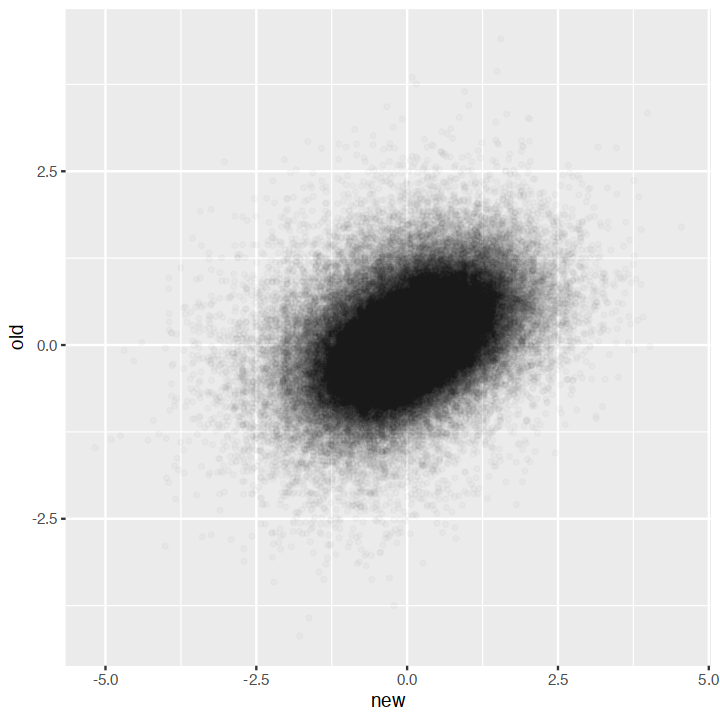

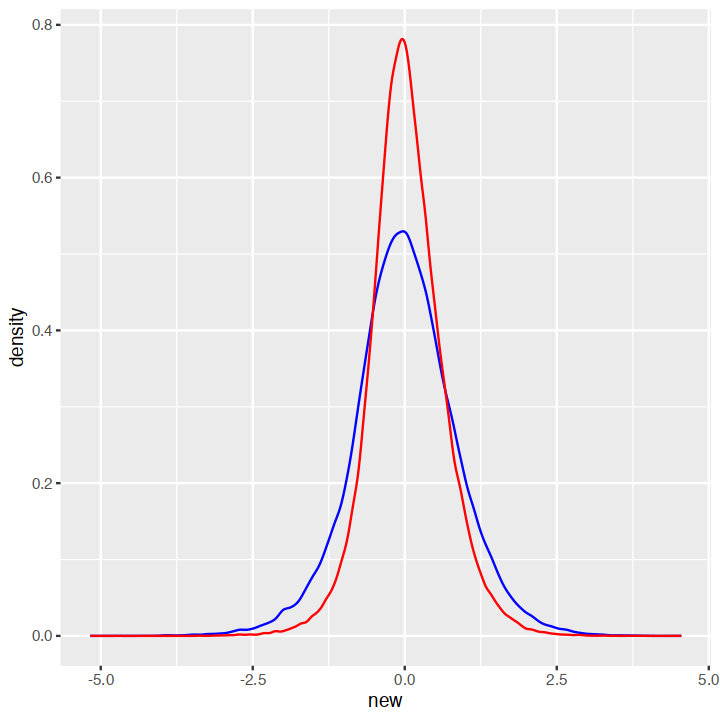

In [22]:
# Comparing new and old ATAC
# they look well correlated
common_peaks = intersect(rownames(new_b24_dep), rownames(old_b24_dep))
new_old_24h = as.data.frame(cbind(new_b24_dep[common_peaks, "logFC"], old_b24_dep[common_peaks, "logFC"]))
colnames(new_old_24h) = c("new", "old")
ggplot(new_old_24h, aes(x=new, y=old)) + geom_point(alpha=0.02, size=1)
cor.test(new_old_24h$new, new_old_24h$old)

ggplot(new_old_24h) + geom_density(aes(x=new), color="blue") + geom_density(aes(x=old), color="red")

## Changes in ATAC

In [23]:
get_freq = function(x) {
    return(table(x$annobrief)/dim(x)[1])
}
exp = get_freq(peakAnno)

# Frequency
b24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(old_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
b48_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(old_b48_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
e24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(old_e24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
e48_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(old_e48_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)

# Numbers
b24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(old_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
b48_cts = table(subset(peakAnno, peak_id %in% rownames(subset(old_b48_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
e24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(old_e24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
e48_cts = table(subset(peakAnno, peak_id %in% rownames(subset(old_e48_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)

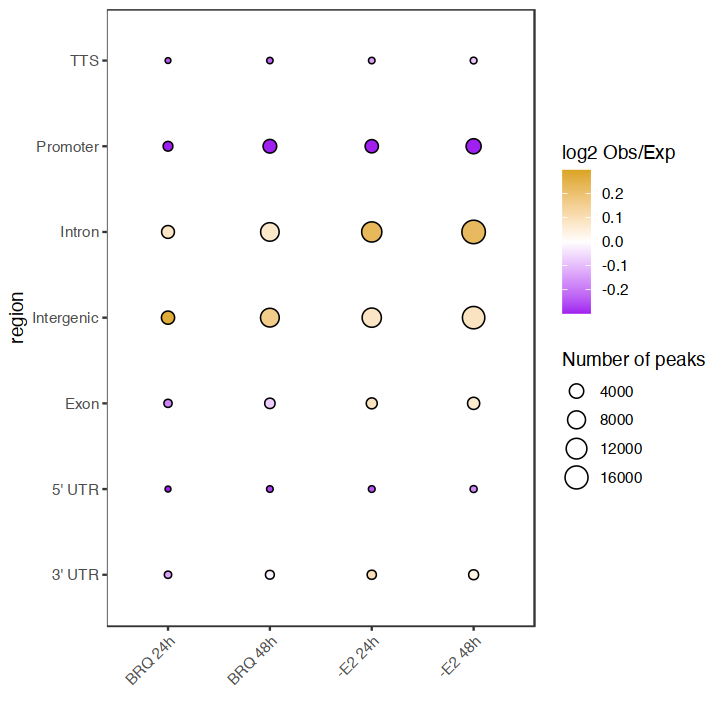

In [24]:
# processing dfs
freqs = cbind(b24_freq, b48_freq, e24_freq, e48_freq)
colnames(freqs) = c("BRQ 24h", "BRQ 48h", "-E2 24h", "-E2 48h")
cts = cbind(b24_cts, b48_cts, e24_cts, e48_cts)
colnames(cts) = c("BRQ 24h", "BRQ 48h", "-E2 24h", "-E2 48h")
freqs = melt(freqs)
cts = melt(cts)

# combine them 
freq_ct_df = cbind(freqs, cts[,3])
colnames(freq_ct_df) = c("region", "tx", "log2 Obs/Exp", "Number of peaks")

# plotting
ggplot(freq_ct_df, aes(x=tx, y = region, fill = `log2 Obs/Exp`, size = `Number of peaks`)) + 
geom_point(pch=21) + scale_fill_gradient2(low = "purple", mid = "white", high = "goldenrod",
                        limits=c(-.3,.3), oob = scales::squish) + # desired breaks on transformed scale
theme_bw() + xlab("") + scale_x_discrete(guide = guide_axis(angle = 45)) +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

ggsave("../output/230921_erhoxa9_atac_changed_peaks.pdf", width=3.5, height=4)

## Changes in H3K27ac

In [25]:
# annotations of where changes in H3K27ac are
get_freq = function(x) {
    return(table(x$annobrief)/dim(x)[1])
}
exp = get_freq(peakAnno)

log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05))))/exp)
log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, logFC < -1 & adj.P.Val < 0.05))))/exp)


log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_e24_dep, logFC > 1 & adj.P.Val < 0.05))))/exp)
log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_e24_dep, logFC < -1 & adj.P.Val < 0.05))))/exp)


     3' UTR      5' UTR        Exon  Intergenic      Intron    Promoter 
-0.09474566  0.07242727 -0.04764669  0.19632149  0.21429725 -1.04404132 
        TTS 
-1.09749773 


     3' UTR      5' UTR        Exon  Intergenic      Intron    Promoter 
-0.23717984 -0.37221191  0.16917132 -0.04732621 -0.20451465  0.36026648 
        TTS 
-2.05671009 


     3' UTR      5' UTR        Exon  Intergenic      Intron    Promoter 
 0.04839672 -0.75433829  0.14269365  0.08544181  0.21886547 -0.78435069 
        TTS 
-0.30955345 


     3' UTR      5' UTR        Exon  Intergenic      Intron    Promoter 
-0.02788927  0.74961581  0.35300871  0.11588103  0.12031165 -0.67459497 
        TTS 
-0.61295427 

In [26]:
# Frequency
b24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)
e24_freq = log2(get_freq(subset(peakAnno, peak_id %in% rownames(subset(k27_e24_dep, abs(logFC) > 1 & adj.P.Val < 0.05))))/exp)

# Numbers
b24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(k27_b24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)
e24_cts = table(subset(peakAnno, peak_id %in% rownames(subset(k27_e24_dep, abs(logFC) > 1 & adj.P.Val < 0.05)))$annobrief)

# processing dfs
freqs = cbind(b24_freq, e24_freq)
colnames(freqs) = c("BRQ", "-E2")
cts = cbind(b24_cts, e24_cts)
colnames(cts) = c("BRQ", "-E2")
freqs = melt(freqs)
cts = melt(cts)

# combine them 
freq_ct_df = cbind(freqs, cts[,3])
colnames(freq_ct_df) = c("region", "tx", "log2 Obs/Exp", "Number of peaks")
freq_ct_df

region     tx  log2 Obs/Exp Number of peaks
1  3' UTR     BRQ -0.13980358   157           
2  5' UTR     BRQ -0.05849448    19           
3  Exon       BRQ  0.02691607   410           
4  Intergenic BRQ  0.12106598  2893           
5  Intron     BRQ  0.09021711  2929           
6  Promoter   BRQ -0.42235609  1157           
7  TTS        BRQ -1.34706398     5           
8  3' UTR     -E2  0.01315841   224           
9  5' UTR     -E2  0.14116074    28           
10 Exon       -E2  0.24505162   612           
11 Intergenic -E2  0.09978255  3658           
12 Intron     -E2  0.17352995  3982           
13 Promoter   -E2 -0.73188923  1198           
14 TTS        -E2 -0.44380176    12

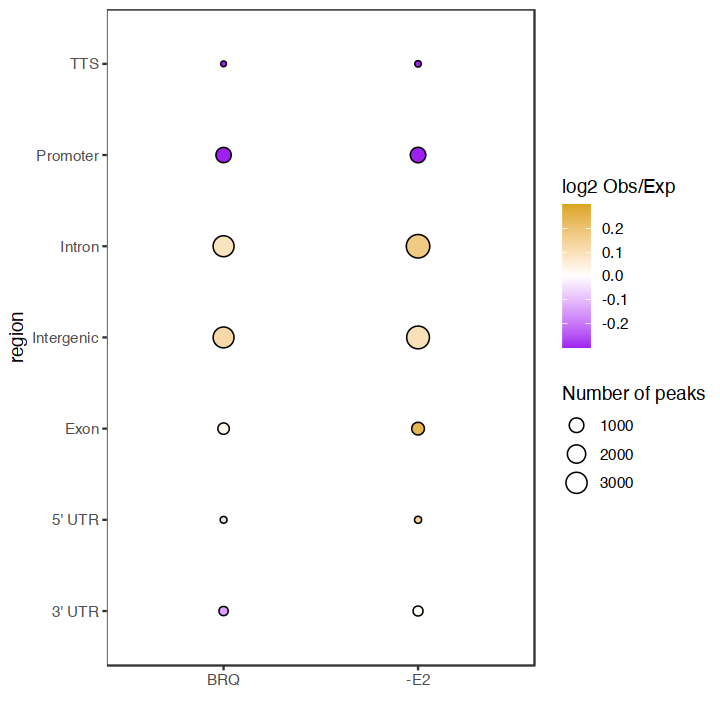

In [27]:
# plotting
ggplot(freq_ct_df, aes(x=tx, y = region, fill = `log2 Obs/Exp`, size = `Number of peaks`)) + 
geom_point(pch=21) + scale_fill_gradient2(low = "purple", mid = "white", high = "goldenrod",
                        limits=c(-.3,.3), oob = scales::squish) + # desired breaks on transformed scale
theme_bw() + xlab("") +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

ggsave("../output/230921_erhoxa9_k27ac_changed_peaks.pdf", width=3.5, height=3)

In [28]:
# at enhancers
k27_b24_up = subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 4386
k27_b24_down = subset(k27_b24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks)  # 1419
k27_b8_up = subset(k27_b8_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b8_dep) %in% enh_peaks)  # 1423
k27_b8_down = subset(k27_b8_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_b8_dep) %in% enh_peaks)  # 608
k27_e24_up = subset(k27_e24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_e24_dep) %in% enh_peaks)  # 4276
k27_e24_down = subset(k27_e24_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_e24_dep) %in% enh_peaks)  # 3631
k27_e8_up = subset(k27_e8_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_e8_dep) %in% enh_peaks)  # 238
k27_e8_down = subset(k27_e8_dep, logFC < -1 & adj.P.Val < 0.05 & rownames(k27_e8_dep) %in% enh_peaks)  # 524

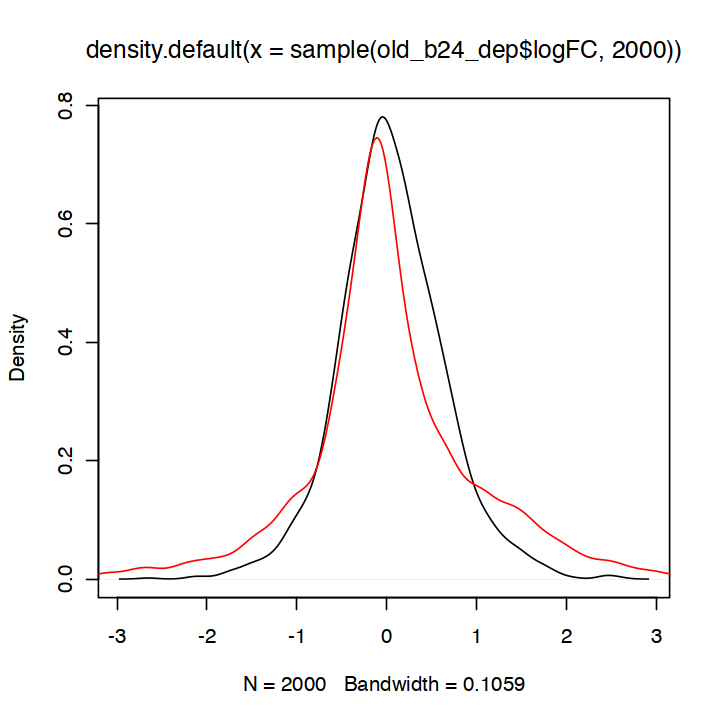

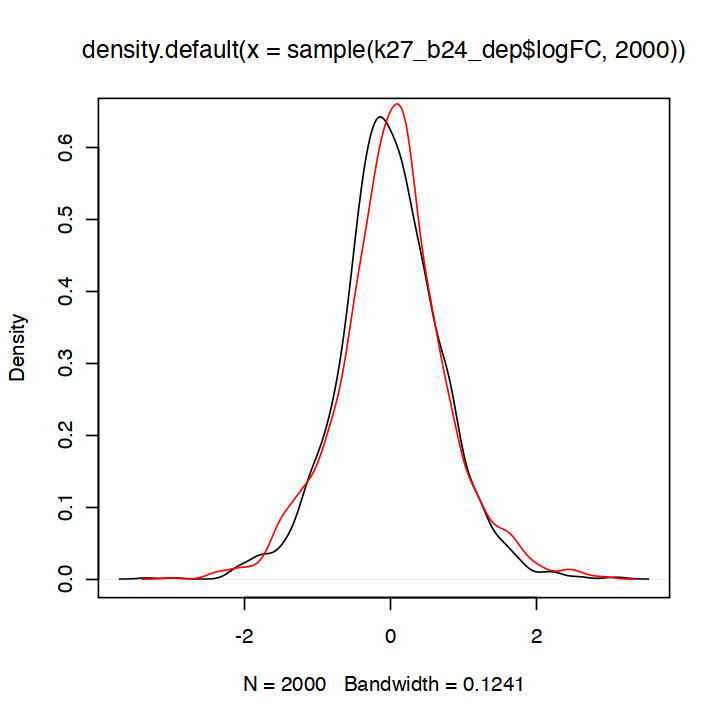

In [29]:
plot(density(sample(old_b24_dep$logFC, 2000)), col="black")
lines(density(sample(old_e24_dep$logFC, 2000)), col="red")

plot(density(sample(k27_b24_dep$logFC, 2000)), col="black")
lines(density(sample(k27_e24_dep$logFC, 2000)), col="red")

### Peak lists for HOMER

In [30]:
# lists of peaks up/down only in B8 or E8 or shared
k27_up_b8 = setdiff(rownames(k27_b8_up), rownames(k27_e8_up))  # 1378
k27_up_shared8 = intersect(rownames(k27_b8_up), rownames(k27_e8_up))  # 45
k27_up_e8 = setdiff(rownames(k27_e8_up), rownames(k27_b8_up))  # 193

k27_down_b8 = setdiff(rownames(k27_b8_down), rownames(k27_e8_down))  # 1031
k27_down_shared8 = intersect(rownames(k27_b8_down), rownames(k27_e8_down))  # 388
k27_down_e8 = setdiff(rownames(k27_e8_down), rownames(k27_b8_down))  # 383

In [31]:
# lists of peaks up/down only in B24 or E24 or shared
k27_up_b24 = setdiff(rownames(k27_b24_up), rownames(k27_e24_up))  # 2990
k27_up_shared24 = intersect(rownames(k27_b24_up), rownames(k27_e24_up))  # 1396
k27_up_e24 = setdiff(rownames(k27_e24_up), rownames(k27_b24_up))  # 2880

k27_down_b24 = setdiff(rownames(k27_b24_down), rownames(k27_e24_down))  # 1031
k27_down_shared24 = intersect(rownames(k27_b24_down), rownames(k27_e24_down))  # 388
k27_down_e24 = setdiff(rownames(k27_e24_down), rownames(k27_b24_down))  # 3243

In [32]:
# peaks up in E8 but not in E24
k27_e8_only = setdiff(rownames(k27_e8_up), rownames(k27_e24_up))
k27_e8_only = intersect(k27_e8_only, rownames(k27_b24_up))
head(k27_e8_up[k27_e8_only,])

logFC    AveExpr  t        P.Value      adj.P.Val    B        
peak76858  1.008878 5.072741 6.738456 2.628160e-11 1.871523e-08 15.241452
peak76859  1.148127 4.621495 6.693932 3.522409e-11 2.465566e-08 14.962848
peak33344  1.397461 3.922309 6.050555 2.002299e-09 9.827536e-07 11.047974
peak76881  1.627684 3.502960 5.681535 1.725816e-08 7.087005e-06  8.891788
peak115556 1.107148 4.312821 5.645379 2.117590e-08 8.525308e-06  8.887803
peak109488 1.100569 4.104516 5.531239 4.008793e-08 1.505669e-05  8.288185

In [33]:
# write bed files
write.bed = function(fn, peaks) {
    tbl = peak_info[peaks,1:3]
    tbl[,4] = rownames(tbl)
    write.table(tbl, fn, quote=F, row.names=F, col.names=F, sep="\t")
}

# # all enhancers
# write.bed("../data/230107_633_atac_k27_homer/230107_633_all_enhancers.bed", enh_peaks)

# # K27 up
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_up_b24.bed", k27_up_b24)
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_up_shared.bed", k27_up_shared24)
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_up_e24.bed", k27_up_e24)
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_b24_up.bed", rownames(k27_b24_up))
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_e24_up.bed", rownames(k27_e24_up))


# # K27 down
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_down_b24.bed", k27_down_b24)
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_down_shared.bed", k27_down_shared24)
# # write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_down_e24.bed", k27_down_e24)
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_b24_down.bed", rownames(k27_b24_down))
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_e24_down.bed", rownames(k27_e24_down))

# 8h
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_b8_up.bed", rownames(k27_b8_up))
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_b8_down.bed", rownames(k27_b8_down))
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_e8_up.bed", rownames(k27_e8_up))
# write.bed("../data/230107_633_atac_k27_homer/230620_633_k27_e8_down.bed", rownames(k27_e8_down))

In [ ]:
# more homer 
# in /net/bmc-pub17/mirror/lab/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/notebooks/230620_erhoxa9_homer

sbatch -N 1 -n1 -c4 -x c[5-22] --wrap "findMotifsGenome.pl 230620_633_k27_b8_up.bed mm10 230620_633_k27_b8_up_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n1 -c4 -x c[5-22] --wrap "findMotifsGenome.pl 230620_633_k27_b8_down.bed mm10 230620_633_k27_b8_down_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n1 -c4 -x c[5-22] --wrap "findMotifsGenome.pl 230620_633_k27_e8_up.bed mm10 230620_633_k27_e8_up_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n1 -c4 -x c[5-22] --wrap "findMotifsGenome.pl 230620_633_k27_e8_down.bed mm10 230620_633_k27_e8_down_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

In [ ]:
# homer in /net/rowley/ifs/data/vanderheiden/briando/files/221028Van/code/230107_633_atac_k27_homer
# homer in /net/bmc-pub17/mirror/lab/vanderheiden/briando/differentiation_manuscript/atacseq_analysis/notebooks/230620_erhoxa9_homer


# all vs enhancers
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} mm10 {.}_vsenhancers -bg 230107_633_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10\" " ::: *.bed

# all vs genome
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} mm10 {.}_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10\" " ::: *.bed

# vs each other
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_633_k27_up_b24.bed mm10 230107_633_k27_up_b24 -bg 230107_633_k27_up_e24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_633_k27_up_e24.bed mm10 230107_633_k27_up_e24 -bg 230107_633_k27_up_b24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_633_k27_down_b24.bed mm10 230107_633_k27_down_b24 -bg 230107_633_k27_down_e24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_633_k27_down_e24.bed mm10 230107_633_k27_down_e24 -bg 230107_633_k27_down_b24.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

# b8
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230206_633_k27_up_b8.bed mm10 230206_633_k27_up_b8_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230206_633_k27_up_b8.bed mm10 230206_633_k27_up_b8_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230206_633_k27_up_e8.bed mm10 230206_633_k27_up_e8_vsenhancers -bg 230107_633_all_enhancers.bed \
-size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230206_633_k27_up_e8.bed mm10 230206_633_k27_up_e8_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"


## ATAC and K27ac changes

In [34]:
# Looking at peaks that go up (ATAC)
# focusing on enhancer (NON PROMOTER) peaks 

# b24_up = rownames(subset(old_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% enh_peaks))
# e24_up = rownames(subset(old_e24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% enh_peaks))
b24_up = rownames(subset(old_b24_dep, logFC > 1 & adj.P.Val < 0.05))
e24_up = rownames(subset(old_e24_dep, logFC > 1 & adj.P.Val < 0.05))
# b24_up = rownames(subset(old_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))
# e24_up = rownames(subset(old_e24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))

b24_only = setdiff(b24_up, e24_up)  # 2345
shared_24 = intersect(b24_up, e24_up)  # 634
e24_only = setdiff(e24_up, b24_up)  # 6164

# b48_up = rownames(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% enh_peaks))
# e48_up = rownames(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% enh_peaks))
b48_up = rownames(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05))
e48_up = rownames(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05))
# b48_up = rownames(subset(old_b48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))
# e48_up = rownames(subset(old_e48_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(old_b24_dep) %in% tss_peaks))

b48_only = setdiff(b48_up, e48_up)  # 4282
shared_48 = intersect(b48_up, e48_up)  # 1712
e48_only = setdiff(e48_up, b48_up)  # 6555

## Baseline ATAC and K27ac


	Wilcoxon rank sum test with continuity correction

data:  subset(df, tx == "BRQ")$log2counts and subset(df, tx == "-E2")$log2counts
W = 13442552, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df, tx == "BRQ")$log2counts and subset(df, tx == "-E2")$log2counts
W = 11218982, p-value = 5.116e-10
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df, tx == "BRQ")$log2fc and subset(df, tx == "-E2")$log2fc
W = 4058762, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(df, tx == "BRQ")$log2fc and subset(df, tx == "-E2")$log2fc
W = 8623743, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Warning message:
“Removed 11 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 298 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 13 rows containing non-finite values (`stat_density()`).”


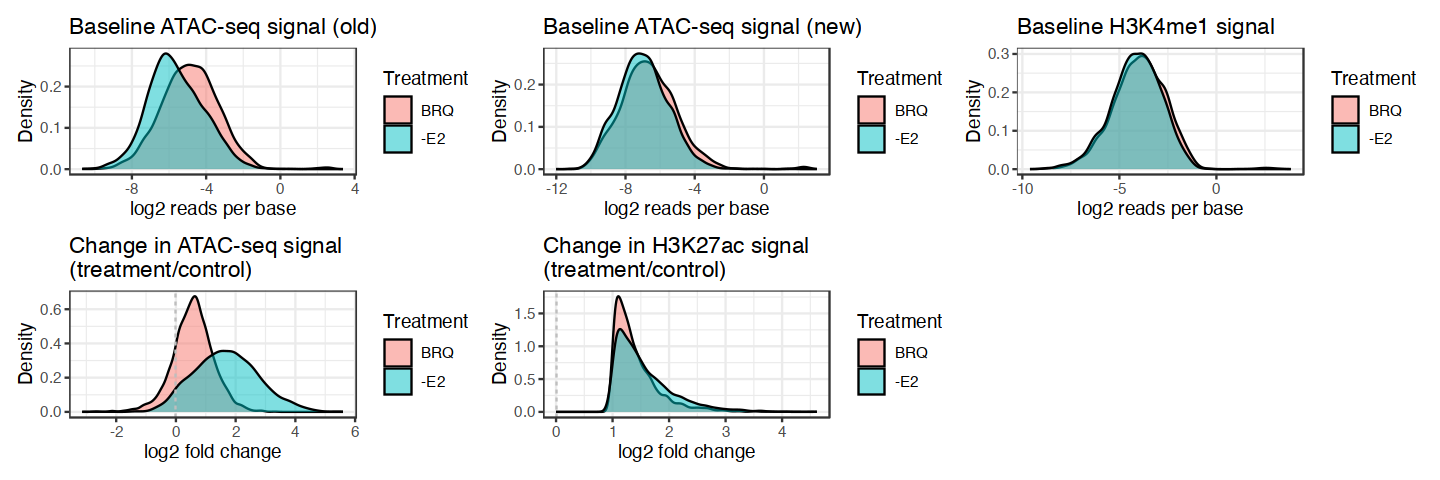

In [37]:
# normalize counts by length

# NEW ATAC
atac_peak_cts_by_length = apply(newatac[,1:2], 1, mean)/peak_info$Length

k27_b24_names = rownames(subset(k27_b24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_b24_dep) %in% enh_peaks))
k27_e24_names = rownames(subset(k27_e24_dep, logFC > 1 & adj.P.Val < 0.05 & rownames(k27_e24_dep) %in% enh_peaks))
k27_shared24 = intersect(k27_b24_names, k27_e24_names)
random = rownames(k27_e24_dep[sample(nrow(k27_e24_dep), 5000),])

df = as.data.frame(rbind(cbind(log2(atac_peak_cts_by_length[k27_b24_names]), "BRQ"), 
                         cbind(log2(atac_peak_cts_by_length[k27_e24_names]), "-E2")))
                         # cbind(log2(atac_peak_cts_by_length[k27_shared24]), "shared"),
                         # cbind(log2(atac_peak_cts_by_length[random]), "Random")))
colnames(df) = c("log2counts", "tx")
df$log2counts = as.numeric(df$log2counts)
#df$tx = factor(df$tx, levels=c("Random", "BRQ", "-E2", "shared"))
df$tx = factor(df$tx, levels=c("BRQ", "-E2"))

g2 = ggplot(df, aes(x=log2counts, fill=tx)) + geom_density(alpha=0.5) + 
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 reads per base") + ylab("Density") + ggtitle("Baseline ATAC-seq signal (new)")

# OLD ATAC
atac_peak_cts_by_length = apply(oldatac[,1:2], 1, mean)/peak_info$Length

df = as.data.frame(rbind(cbind(log2(atac_peak_cts_by_length[k27_b24_names]), "BRQ"), 
                         cbind(log2(atac_peak_cts_by_length[k27_e24_names]), "-E2")))
                         # cbind(log2(atac_peak_cts_by_length[k27_shared24]), "shared"),
                         # cbind(log2(atac_peak_cts_by_length[random]), "Random")))
colnames(df) = c("log2counts", "tx")
df$log2counts = as.numeric(df$log2counts)
#df$tx = factor(df$tx, levels=c("Random", "BRQ", "-E2", "shared"))
df$tx = factor(df$tx, levels=c("BRQ", "-E2"))
wilcox.test(subset(df, tx == "BRQ")$log2counts, subset(df, tx == "-E2")$log2counts)

g1 = ggplot(df, aes(x=log2counts, fill=tx)) + geom_density(alpha=0.5) + 
# scale_fill_manual(values=c("darkgray", "#F8766D", "#00BFC4", "green"), name="Treatment") + theme_bw() +
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 reads per base") + ylab("Density") + ggtitle("Baseline ATAC-seq signal (old)")

# H3K4me1
k4me1_peak_cts_by_length = k4me1_k27me3[,1]/peak_info$Length
names(k4me1_peak_cts_by_length) = rownames(oldatac)

df = as.data.frame(rbind(cbind(log2(k4me1_peak_cts_by_length[k27_b24_names]), "BRQ"), 
                         cbind(log2(k4me1_peak_cts_by_length[k27_e24_names]), "-E2")))
                         # cbind(log2(atac_peak_cts_by_length[k27_shared24]), "shared"),
                         # cbind(log2(atac_peak_cts_by_length[random]), "Random")))
colnames(df) = c("log2counts", "tx")
df$log2counts = as.numeric(df$log2counts)
#df$tx = factor(df$tx, levels=c("Random", "BRQ", "-E2", "shared"))
df$tx = factor(df$tx, levels=c("BRQ", "-E2"))
wilcox.test(subset(df, tx == "BRQ")$log2counts, subset(df, tx == "-E2")$log2counts)

g4 = ggplot(df, aes(x=log2counts, fill=tx)) + geom_density(alpha=0.5) + 
# scale_fill_manual(values=c("darkgray", "#F8766D", "#00BFC4", "green"), name="Treatment") + theme_bw() +
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 reads per base") + ylab("Density") + ggtitle("Baseline H3K4me1 signal")

# ATAC change
df = as.data.frame(rbind(cbind(old_b24_dep[k27_b24_names,]$logFC, "BRQ"), 
                         cbind(old_e24_dep[k27_e24_names,]$logFC, "-E2")))
colnames(df) = c("log2fc", "tx")
df$log2fc = as.numeric(df$log2fc)
#df$tx = factor(df$tx, levels=c("Random", "BRQ", "-E2", "shared"))
df$tx = factor(df$tx, levels=c("BRQ", "-E2"))
wilcox.test(subset(df, tx == "BRQ")$log2fc, subset(df, tx == "-E2")$log2fc)

g3 = ggplot(df, aes(x=log2fc, fill=tx)) + geom_density(alpha=0.5) + geom_vline(xintercept=0, linetype=2, color="gray")+
# scale_fill_manual(values=c("darkgray", "#F8766D", "#00BFC4", "green"), name="Treatment") + theme_bw() +
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 fold change") + ylab("Density") + ggtitle("Change in ATAC-seq signal\n(treatment/control)")
options(repr.plot.width=12, repr.plot.height=4)

# K27ac change
df = as.data.frame(rbind(cbind(k27_b24_dep[k27_b24_names,]$logFC, "BRQ"), 
                         cbind(k27_e24_dep[k27_e24_names,]$logFC, "-E2")))
colnames(df) = c("log2fc", "tx")
df$log2fc = as.numeric(df$log2fc)
#df$tx = factor(df$tx, levels=c("Random", "BRQ", "-E2", "shared"))
df$tx = factor(df$tx, levels=c("BRQ", "-E2"))
wilcox.test(subset(df, tx == "BRQ")$log2fc, subset(df, tx == "-E2")$log2fc)

g5 = ggplot(df, aes(x=log2fc, fill=tx)) + geom_density(alpha=0.5) + geom_vline(xintercept=0, linetype=2, color="gray")+
# scale_fill_manual(values=c("darkgray", "#F8766D", "#00BFC4", "green"), name="Treatment") + theme_bw() +
scale_fill_manual(values=c("#F8766D", "#00BFC4"), name="Treatment") + theme_bw() +
xlab("log2 fold change") + ylab("Density") + ggtitle("Change in H3K27ac signal\n(treatment/control)")
options(repr.plot.width=12, repr.plot.height=4)

g1 + g2 + g4 + g3 + g5

Warning message:
“Removed 11 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 11 rows containing non-finite values (`stat_density()`).”


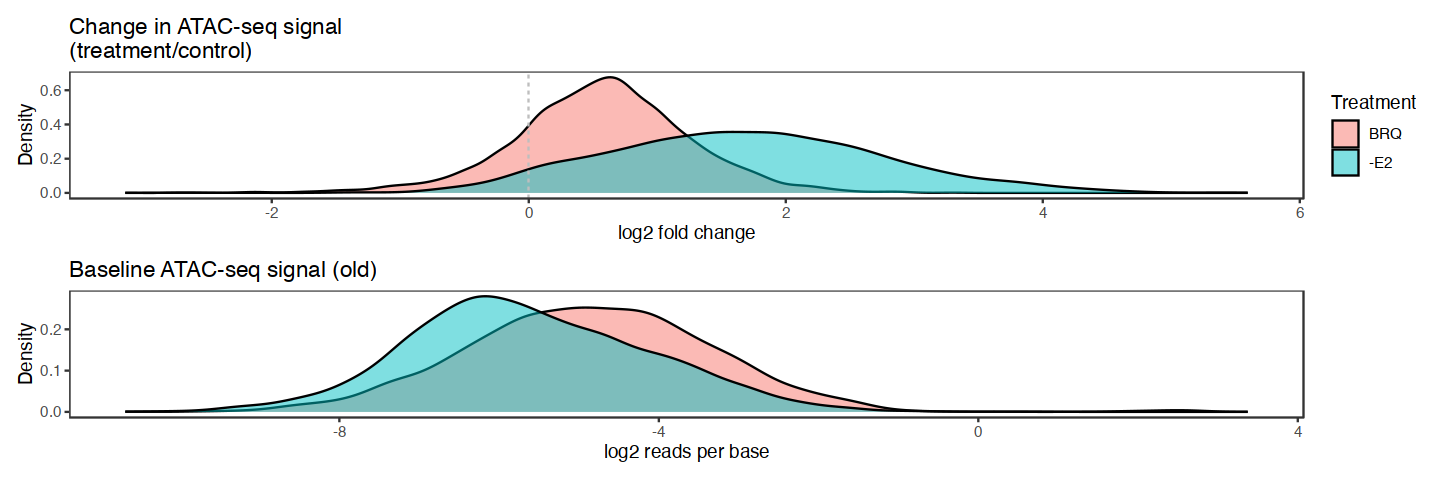

In [38]:
g1 = g1 + theme(panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),
           legend.position="none")
g3 = g3 + theme(panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())

g3/g1
ggsave("../output/230620_633_k27acup_atac_counts.pdf", width=4, height=4)

In [39]:
# median ATAC signal of peaks that get activated by each stimulus
median(atac_peak_cts_by_length[k27_b24_names])
median(atac_peak_cts_by_length[k27_e24_names])
median(atac_peak_cts_by_length[setdiff(k27_e24_names,k27_b24_names)])
median(atac_peak_cts_by_length[setdiff(k27_b24_names,k27_e24_names)])
median(atac_peak_cts_by_length[intersect(k27_b24_names,k27_e24_names)])
median(atac_peak_cts_by_length[random])

[1] 0.03427565

[1] 0.01860744

[1] 0.01818182

[1] 0.04403968

[1] 0.0193341

[1] 0.07542763

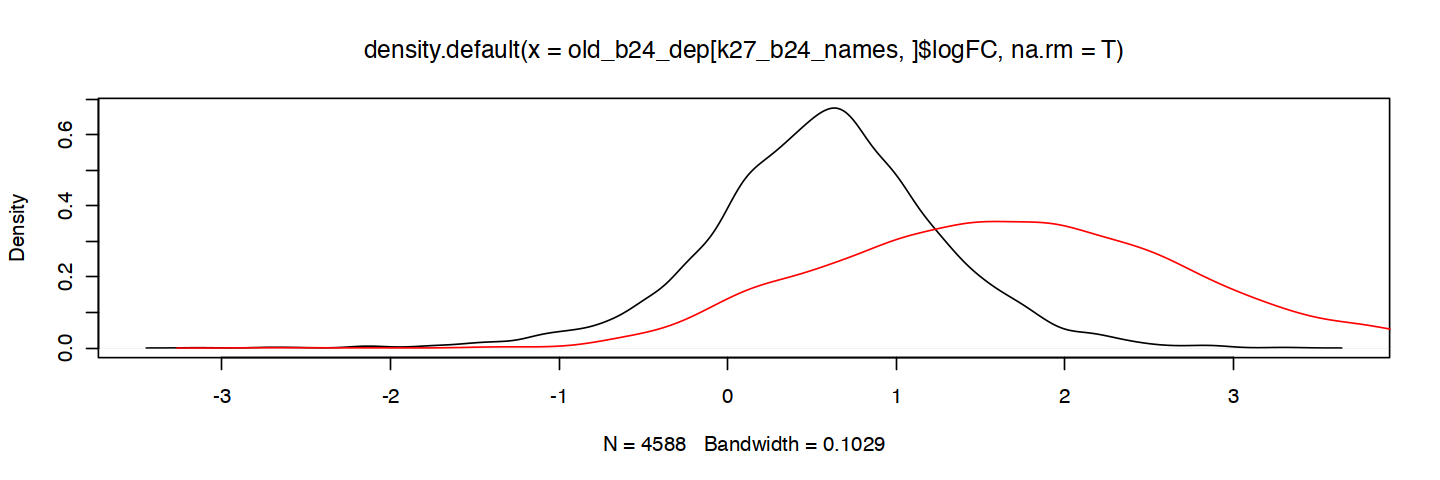

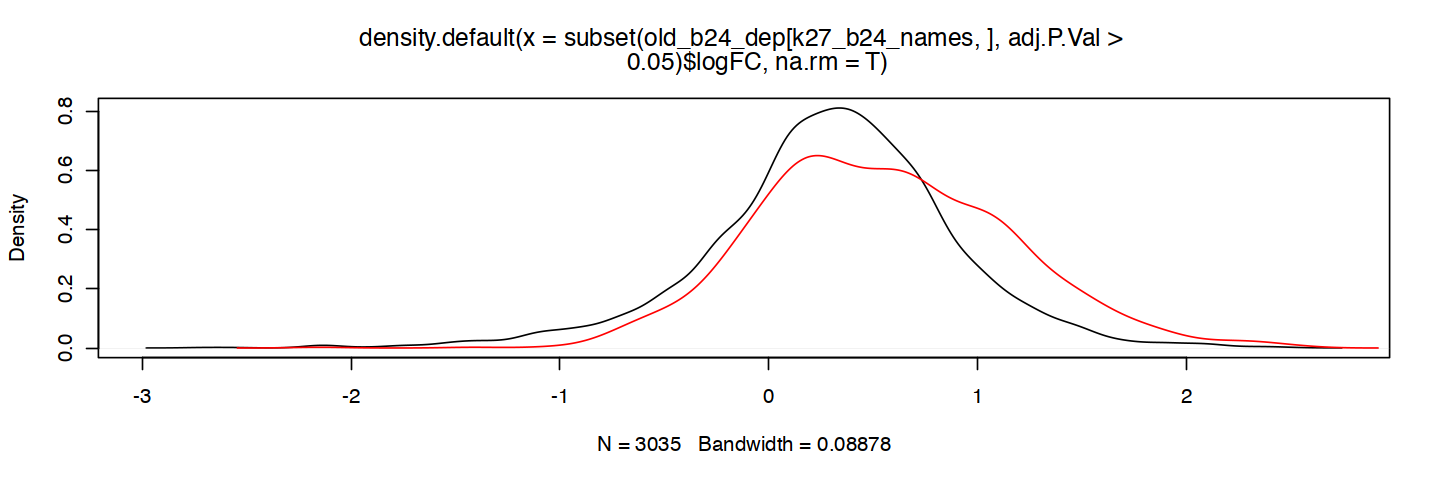

In [41]:
plot(density(old_b24_dep[k27_b24_names,]$logFC, na.rm=T))
lines(density(old_e24_dep[k27_e24_names,]$logFC, na.rm=T), col="red")

plot(density(subset(old_b24_dep[k27_b24_names,], adj.P.Val > 0.05)$logFC, na.rm=T))
lines(density(subset(old_e24_dep[k27_e24_names,], adj.P.Val > 0.05)$logFC, na.rm=T), col="red")

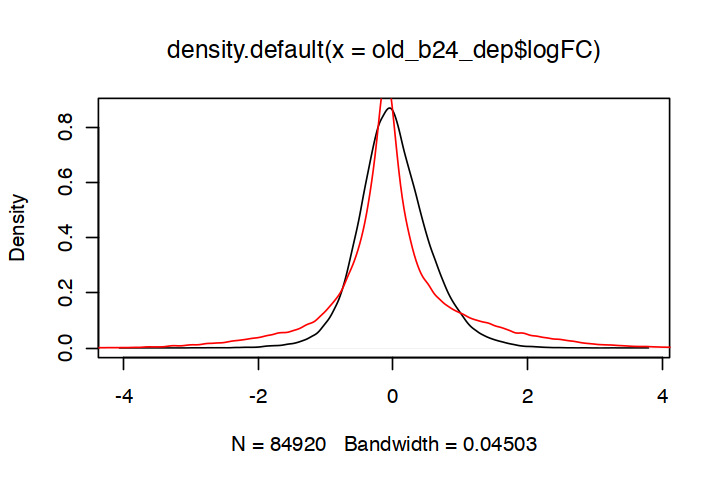

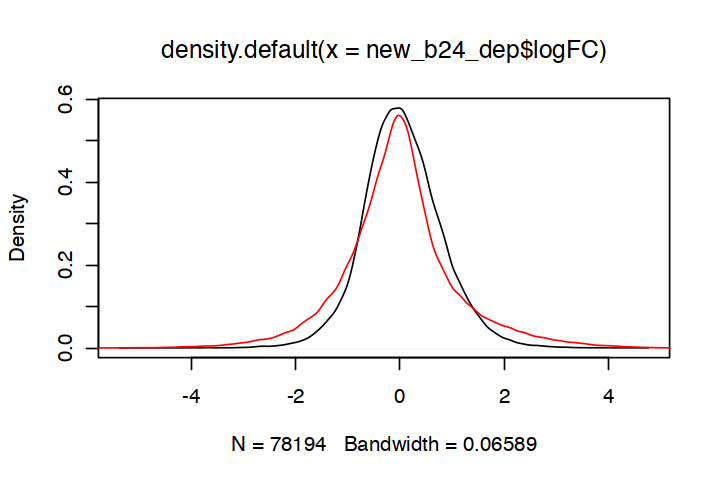

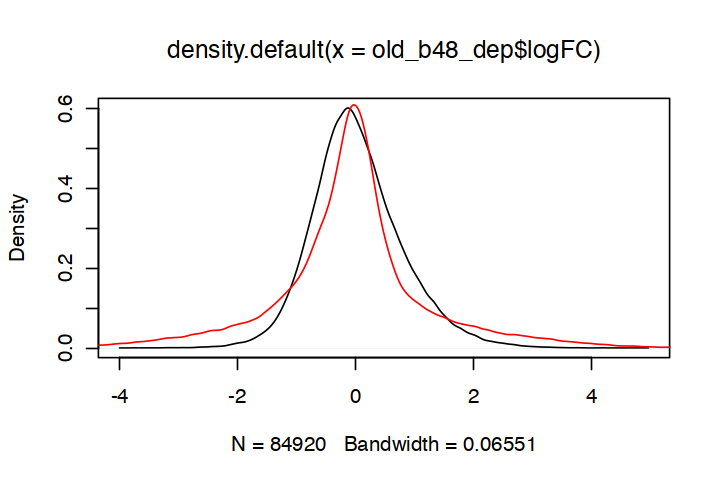

In [39]:
options(repr.plot.width=6, repr.plot.height=4)
plot(density(old_b24_dep$logFC))
lines(density(old_e24_dep$logFC), col="red")
plot(density(new_b24_dep$logFC))
lines(density(new_e24_dep$logFC), col="red")
plot(density(old_b48_dep$logFC))
lines(density(old_e48_dep$logFC), col="red")

In [45]:
# processing region-gene associations from GREAT
# 230107_633_all_enhancers.bed
# great_data = read.table("../data/20220220-public-4.0.4-hlnHpD-mm10-all-region.txt", sep='\t')  # 50kb
great_data = read.table("../data/230107_633_atac_k27_homer/20230118-public-4.0.4-xBYUWd-mm10-all-region.txt", sep='\t')  # 100kb

great_data = great_data[great_data$V2 != "NONE",]
great_data$gene = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][1])
great_data$dist = sapply(great_data$V2, function(x) strsplit(x, split = ' ')[[1]][2])
great_data$dist = as.numeric(gsub('(', '', gsub(')', '', great_data$dist, fixed=T), fixed=T))
rownames(great_data) = great_data$V1
colnames(great_data) = c("peak_id", "great_output", "gene", "dist")
head(great_data)

peak_id great_output  gene dist  
peak19 peak19  Xkr4 (+60103) Xkr4  60103
peak22 peak22  Rp1 (+27638)  Rp1   27638
peak23 peak23  Rp1 (-54087)  Rp1  -54087
peak24 peak24  Rp1 (-54570)  Rp1  -54570
peak25 peak25  Rp1 (-56588)  Rp1  -56588
peak26 peak26  Rp1 (-57835)  Rp1  -57835

In [43]:
# get ALL peaks, not just enhancers, and use great
# 230619_633_all_peaks.bed
# write.table(cbind(peak_info[,1:3], rownames(peak_info)), "../data/230107_633_atac_k27_homer/230619_633_all_peaks.bed",
#             quote=F, row.names = F, col.names = F, sep='\t')

great_data_with_tss = read.table("../data/230107_633_atac_k27_homer/20230619-public-4.0.4-FYYk5s-mm10-all-region.txt", sep='\t')  # 100kb

great_data_with_tss = great_data_with_tss[great_data_with_tss$V2 != "NONE",]
great_data_with_tss$gene = sapply(great_data_with_tss$V2, function(x) strsplit(x, split = ' ')[[1]][1])
great_data_with_tss$dist = sapply(great_data_with_tss$V2, function(x) strsplit(x, split = ' ')[[1]][2])
great_data_with_tss$dist = as.numeric(gsub('(', '', gsub(')', '', great_data_with_tss$dist, fixed=T), fixed=T))
rownames(great_data_with_tss) = great_data_with_tss$V1
colnames(great_data_with_tss) = c("peak_id", "great_output", "gene", "dist")
head(great_data_with_tss)


peak_id great_output  gene dist  
peak19 peak19  Xkr4 (+60103) Xkr4  60103
peak22 peak22  Rp1 (+27638)  Rp1   27638
peak23 peak23  Rp1 (-54087)  Rp1  -54087
peak24 peak24  Rp1 (-54570)  Rp1  -54570
peak25 peak25  Rp1 (-56588)  Rp1  -56588
peak26 peak26  Rp1 (-57835)  Rp1  -57835

In [46]:
# how many peaks that gained H3K27ac did not gain ATAC? [trying to just use FDR] 

# peaks only in enh
b = intersect(k27_b24_names, rownames(great_data))
e = intersect(k27_e24_names, rownames(great_data))


dim(subset(old_b24_dep[b,]))  # 5094
dim(subset(old_b24_dep[b,], adj.P.Val < 0.05 & logFC >= 1))  # 890 sig more acc >1
dim(subset(old_b24_dep[b,], adj.P.Val < 0.05 & logFC > 0 & logFC < 1))  # 767 sig more acc >0
dim(subset(old_b24_dep[b,], adj.P.Val >= 0.05 & logFC > 0)) # 2532 up but not sig
dim(subset(old_b24_dep[b,], logFC <= 0)) # 905 def not up

dim(subset(old_e24_dep[e,]))  # 5163
dim(subset(old_e24_dep[e,], adj.P.Val < 0.05 & logFC >= 1))  # 3398 sig more acc >1
dim(subset(old_e24_dep[e,], adj.P.Val < 0.05 & logFC > 0 & logFC < 1))  # 330 sig more acc >0
dim(subset(old_e24_dep[e,], adj.P.Val >= 0.05 & logFC > 0))  # 1155 up but not acc
dim(subset(old_e24_dep[e,], logFC <= 0))  # 280 def not up 


[1] 3542    6

[1] 614   6

[1] 555   6

[1] 1734    6

[1] 639   6

[1] 3630    6

[1] 2389    6

[1] 233   6

[1] 804   6

[1] 204   6

In [48]:
# what about the converse? 
# in both cases, about 1/3 to 1/2 of sites that gain ATAC don't have a meaningful increase in H3K27ac -- more so in -E2 than BRQ.

b = rownames(subset(old_b24_dep, logFC > 1 & adj.P.Val < 0.05))
e = rownames(subset(old_e24_dep, logFC > 1 & adj.P.Val < 0.05))
dim(subset(k27_b24_dep[b,]))
dim(subset(k27_b24_dep[b,], adj.P.Val > 0.05 | (adj.P.Val < 0.05 & logFC < 0)))

dim(subset(k27_e24_dep[e,]))
dim(subset(k27_e24_dep[e,], adj.P.Val > 0.05 | (adj.P.Val < 0.05 & logFC < 0)))

[1] 4635    6

[1] 3339    6

[1] 15126     6

[1] 9922    6

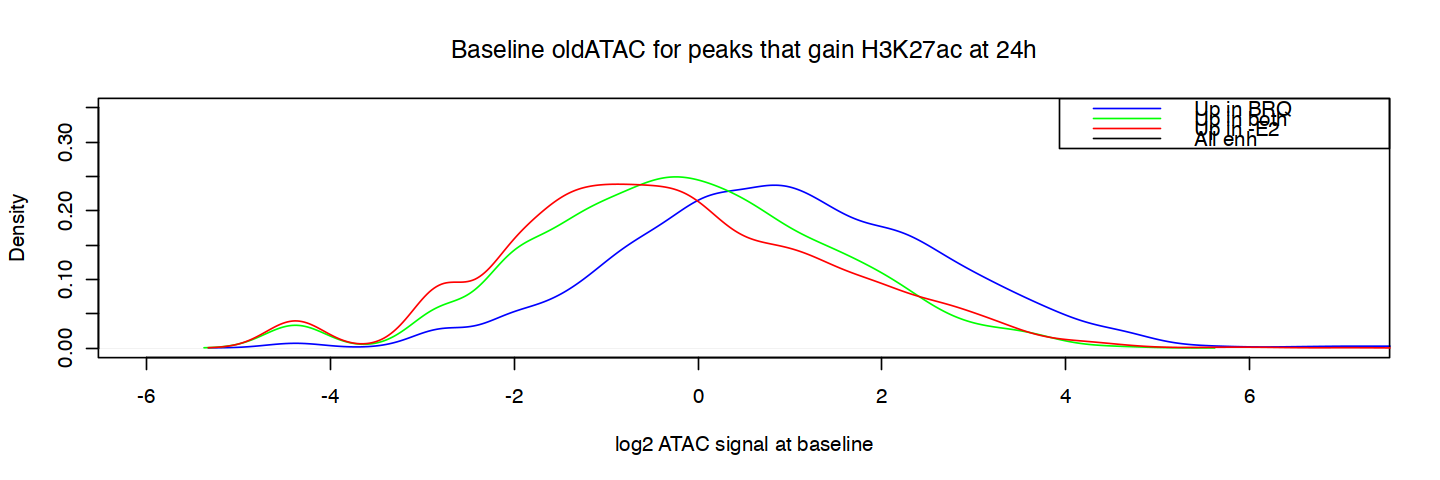

In [49]:
plot(density(no_na(oldatac_norm[k27_up_b24,1])), col="blue", xlim=c(-6,7), ylim=c(0,0.35),
main="Baseline oldATAC for peaks that gain H3K27ac at 24h", xlab="log2 ATAC signal at baseline")
lines(density(no_na(oldatac_norm[k27_up_shared24,1])), col="green")
lines(density(no_na(oldatac_norm[k27_up_e24,1])), col="red")
#lines(density(sample(no_na(oldatac_norm[enh_peaks,1]), 10000)), col="black")
legend("topright", c("Up in BRQ", "Up in both", "Up in -E2", "All enh"), lty=1:1, col=c("blue", "green", "red", "black"))

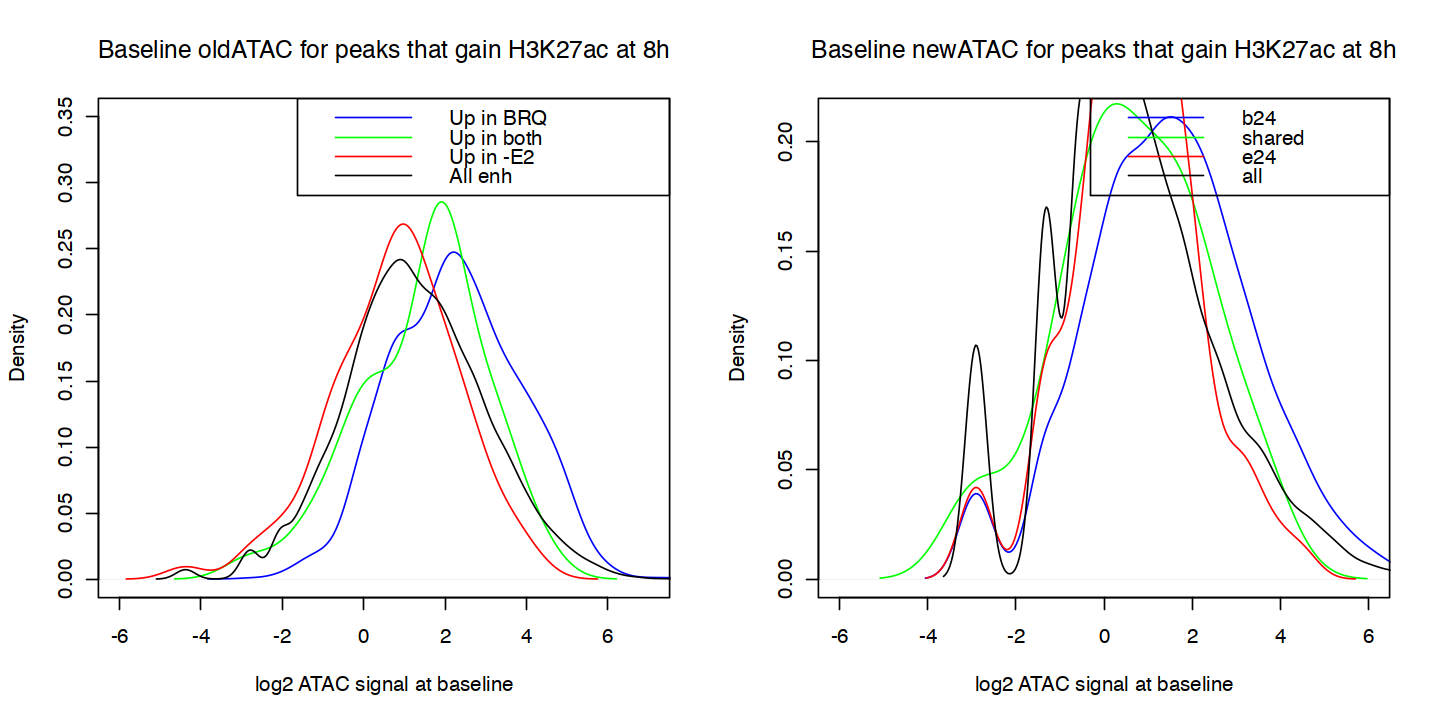

In [50]:
# Plotting baseline ATAC for peaks that change k27ac
# when plotting TSS's, the differences in ATAC are slightly more muted 

# this is true in both old and new ATAC so I believe the result 

options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(density(no_na(oldatac_norm[k27_up_b8,1])), col="blue", xlim=c(-6,7), ylim=c(0,0.35),
main="Baseline oldATAC for peaks that gain H3K27ac at 8h", xlab="log2 ATAC signal at baseline")
lines(density(no_na(oldatac_norm[k27_up_shared8,1])), col="green")
lines(density(no_na(oldatac_norm[k27_up_e8,1])), col="red")
lines(density(sample(no_na(oldatac_norm[enh_peaks,1]), 10000)), col="black")
legend("topright", c("Up in BRQ", "Up in both", "Up in -E2", "All enh"), lty=1:1, col=c("blue", "green", "red", "black"))

plot(density(no_na(newatac_norm[k27_up_b8,1])), col="blue", xlim=c(-6,6), 
main="Baseline newATAC for peaks that gain H3K27ac at 8h", xlab="log2 ATAC signal at baseline")
lines(density(no_na(newatac_norm[k27_up_shared8,1])), col="green")
lines(density(no_na(newatac_norm[k27_up_e8,1])), col="red")
lines(density(sample(no_na(newatac_norm[enh_peaks,1]), 10000)), col="black")
legend("topright", c("b24", "shared", "e24", "all"), lty=1:1, col=c("blue", "green", "red", "black"))


In [51]:
# Plotting baseline ATAC for peaks that change k27ac, grouped by change in ATAC 

both_up = rownames(subset(old_b24_dep[k27_up_b24,], logFC > 1))
k27ac_up_only = rownames(subset(old_b24_dep[k27_up_b24,], logFC < 0.2))

median(k27_b24_dep[both_up,]$logFC)
median(k27_b24_dep[k27ac_up_only,]$logFC)

median(oldatac_norm[k27_up_b24,1], na.rm=T)
median(oldatac_norm[both_up,1])
median(oldatac_norm[k27ac_up_only,1])

[1] 1.352699

[1] 1.187943

[1] 0.8316153

[1] 0.1457239

[1] 0.8316153

In [52]:
both_up = rownames(subset(old_e24_dep[k27_up_e24,], logFC > 1))
k27ac_up_only = rownames(subset(old_e24_dep[k27_up_e24,], logFC < 0.2))

median(k27_e24_dep[both_up,]$logFC)
median(k27_e24_dep[k27ac_up_only,]$logFC)

median(oldatac_norm[k27_up_e24,1], na.rm=T)
median(oldatac_norm[both_up,1])
median(oldatac_norm[k27ac_up_only,1])

[1] 1.401228

[1] 1.328698

[1] -0.4709475

[1] -0.9184065

[1] 1.504805

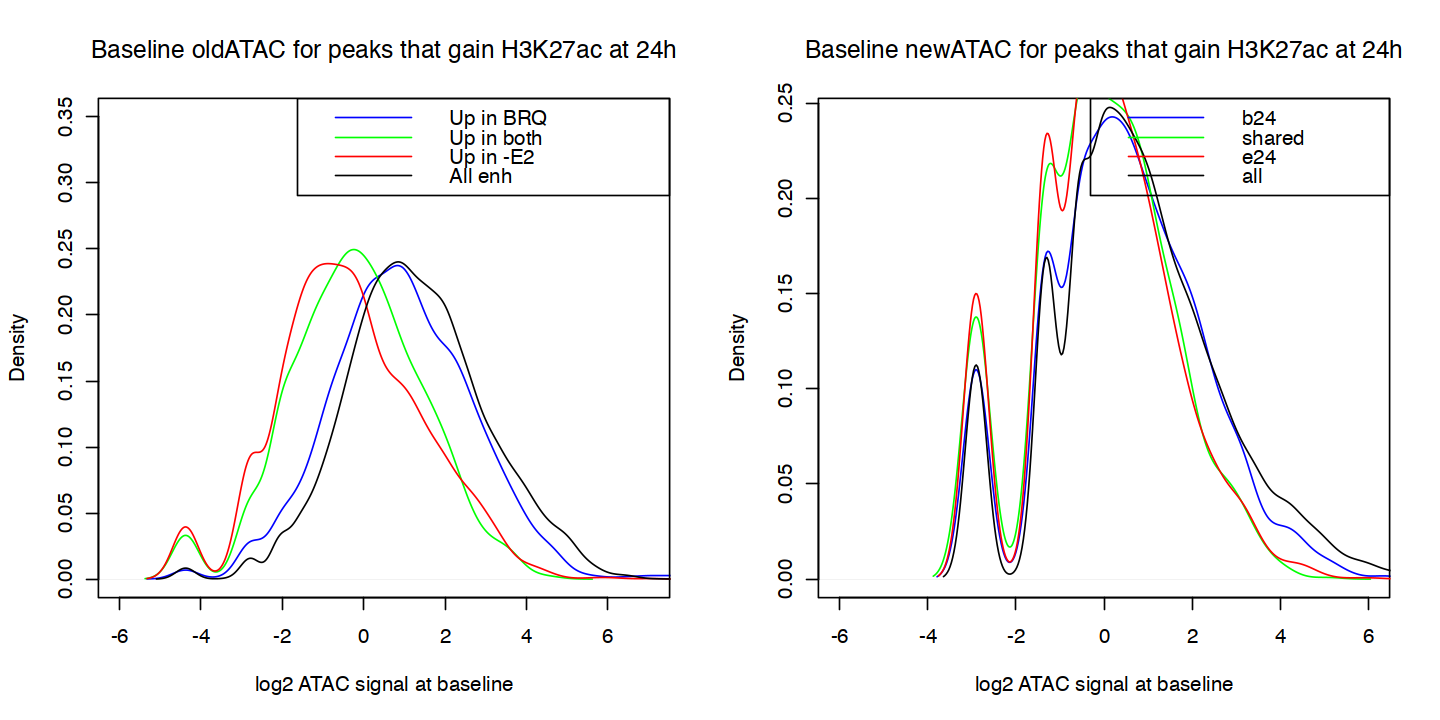

In [53]:
# Plotting baseline ATAC for peaks that change k27ac, grouped by change in ATAC 

# this is true in both old and new ATAC so I believe the result 

options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(density(no_na(oldatac_norm[k27_up_b24,1])), col="blue", xlim=c(-6,7), ylim=c(0,0.35),
main="Baseline oldATAC for peaks that gain H3K27ac at 24h", xlab="log2 ATAC signal at baseline")
lines(density(no_na(oldatac_norm[k27_up_shared24,1])), col="green")
lines(density(no_na(oldatac_norm[k27_up_e24,1])), col="red")
lines(density(sample(no_na(oldatac_norm[enh_peaks,1]), 10000)), col="black")
legend("topright", c("Up in BRQ", "Up in both", "Up in -E2", "All enh"), lty=1:1, col=c("blue", "green", "red", "black"))

plot(density(no_na(newatac_norm[k27_up_b24,1])), col="blue", xlim=c(-6,6), 
main="Baseline newATAC for peaks that gain H3K27ac at 24h", xlab="log2 ATAC signal at baseline")
lines(density(no_na(newatac_norm[k27_up_shared24,1])), col="green")
lines(density(no_na(newatac_norm[k27_up_e24,1])), col="red")
lines(density(sample(no_na(newatac_norm[enh_peaks,1]), 10000)), col="black")
legend("topright", c("b24", "shared", "e24", "all"), lty=1:1, col=c("blue", "green", "red", "black"))


In [54]:
new_b24_up = rownames(subset(new_b24_dep, logFC > 1 & adj.P.Val < .05))
new_e24_up = rownames(subset(new_e24_dep, logFC > 1 & adj.P.Val < .05))
new_b24_only = setdiff(new_b24_up, new_e24_up)
new_e24_only = setdiff(new_e24_up, new_b24_up)
new_shared_24 = intersect(new_b24_up, new_e24_up)

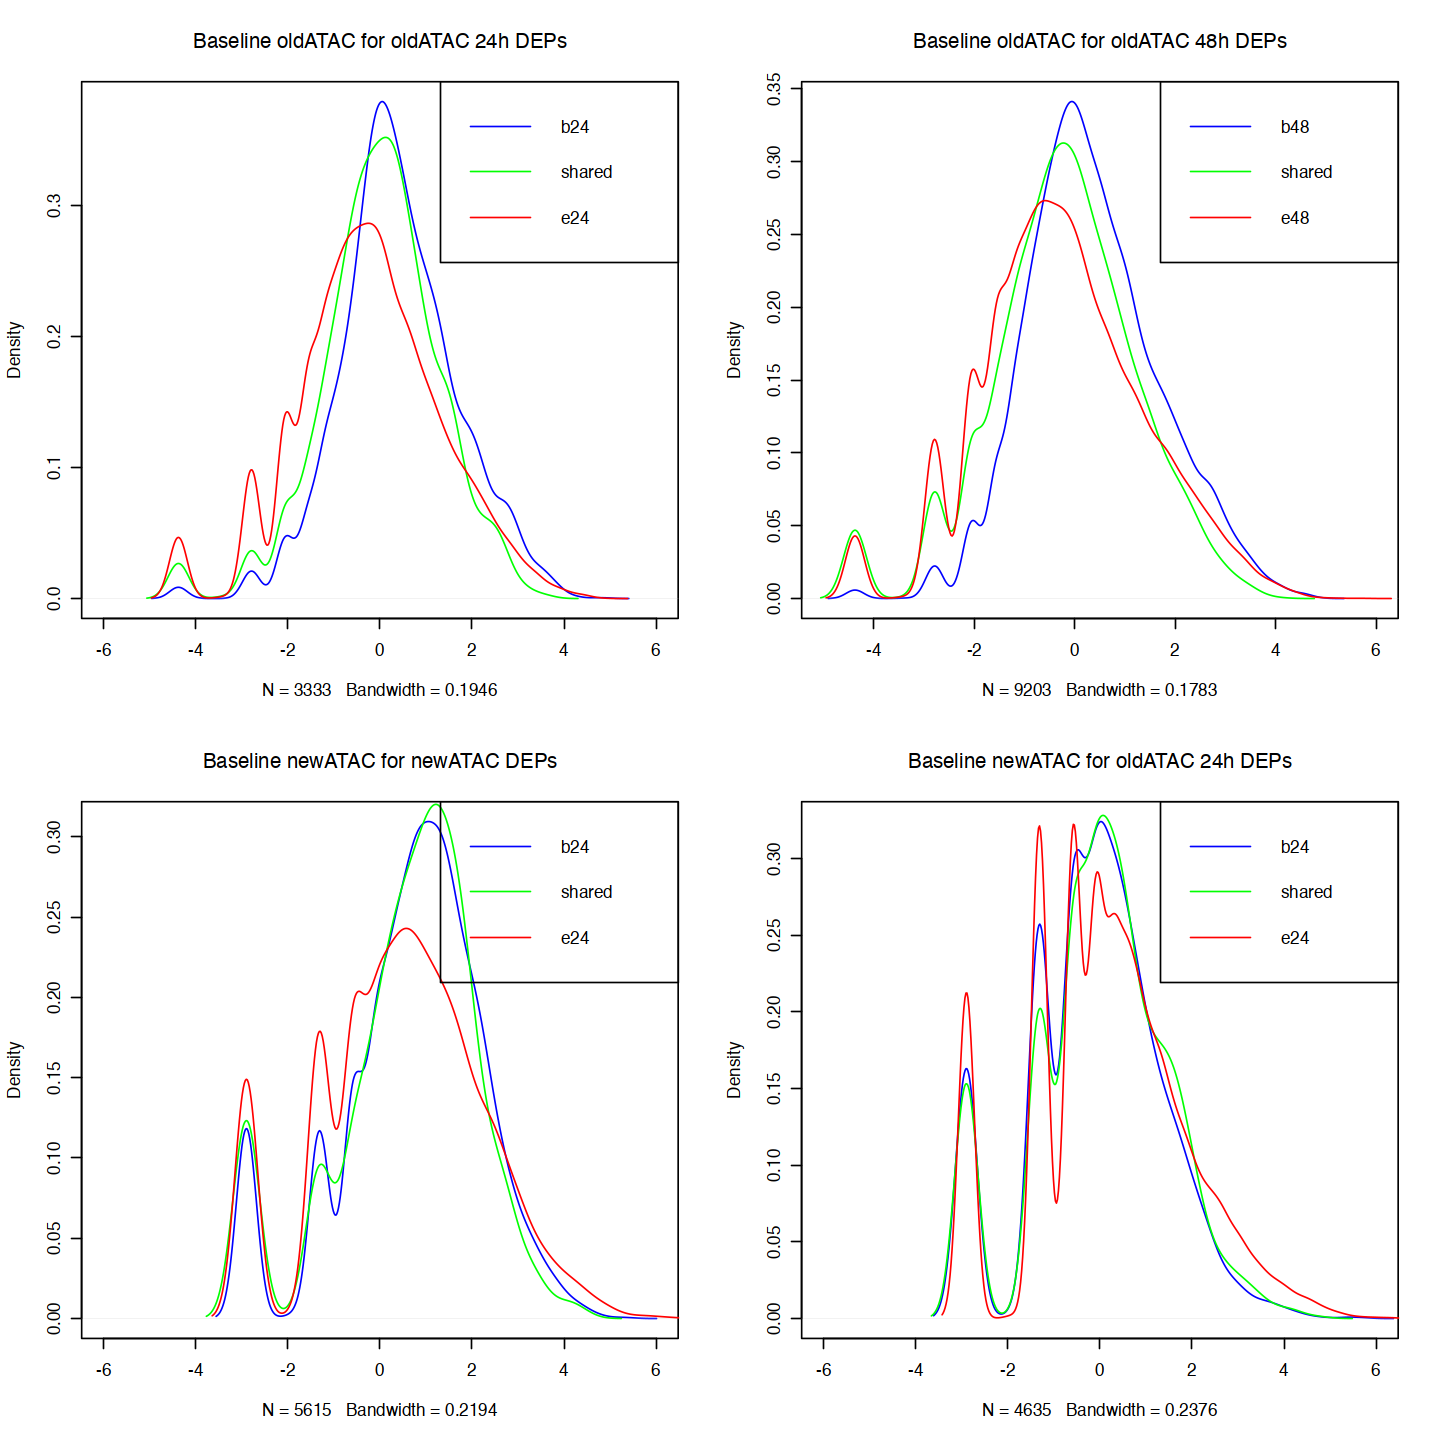

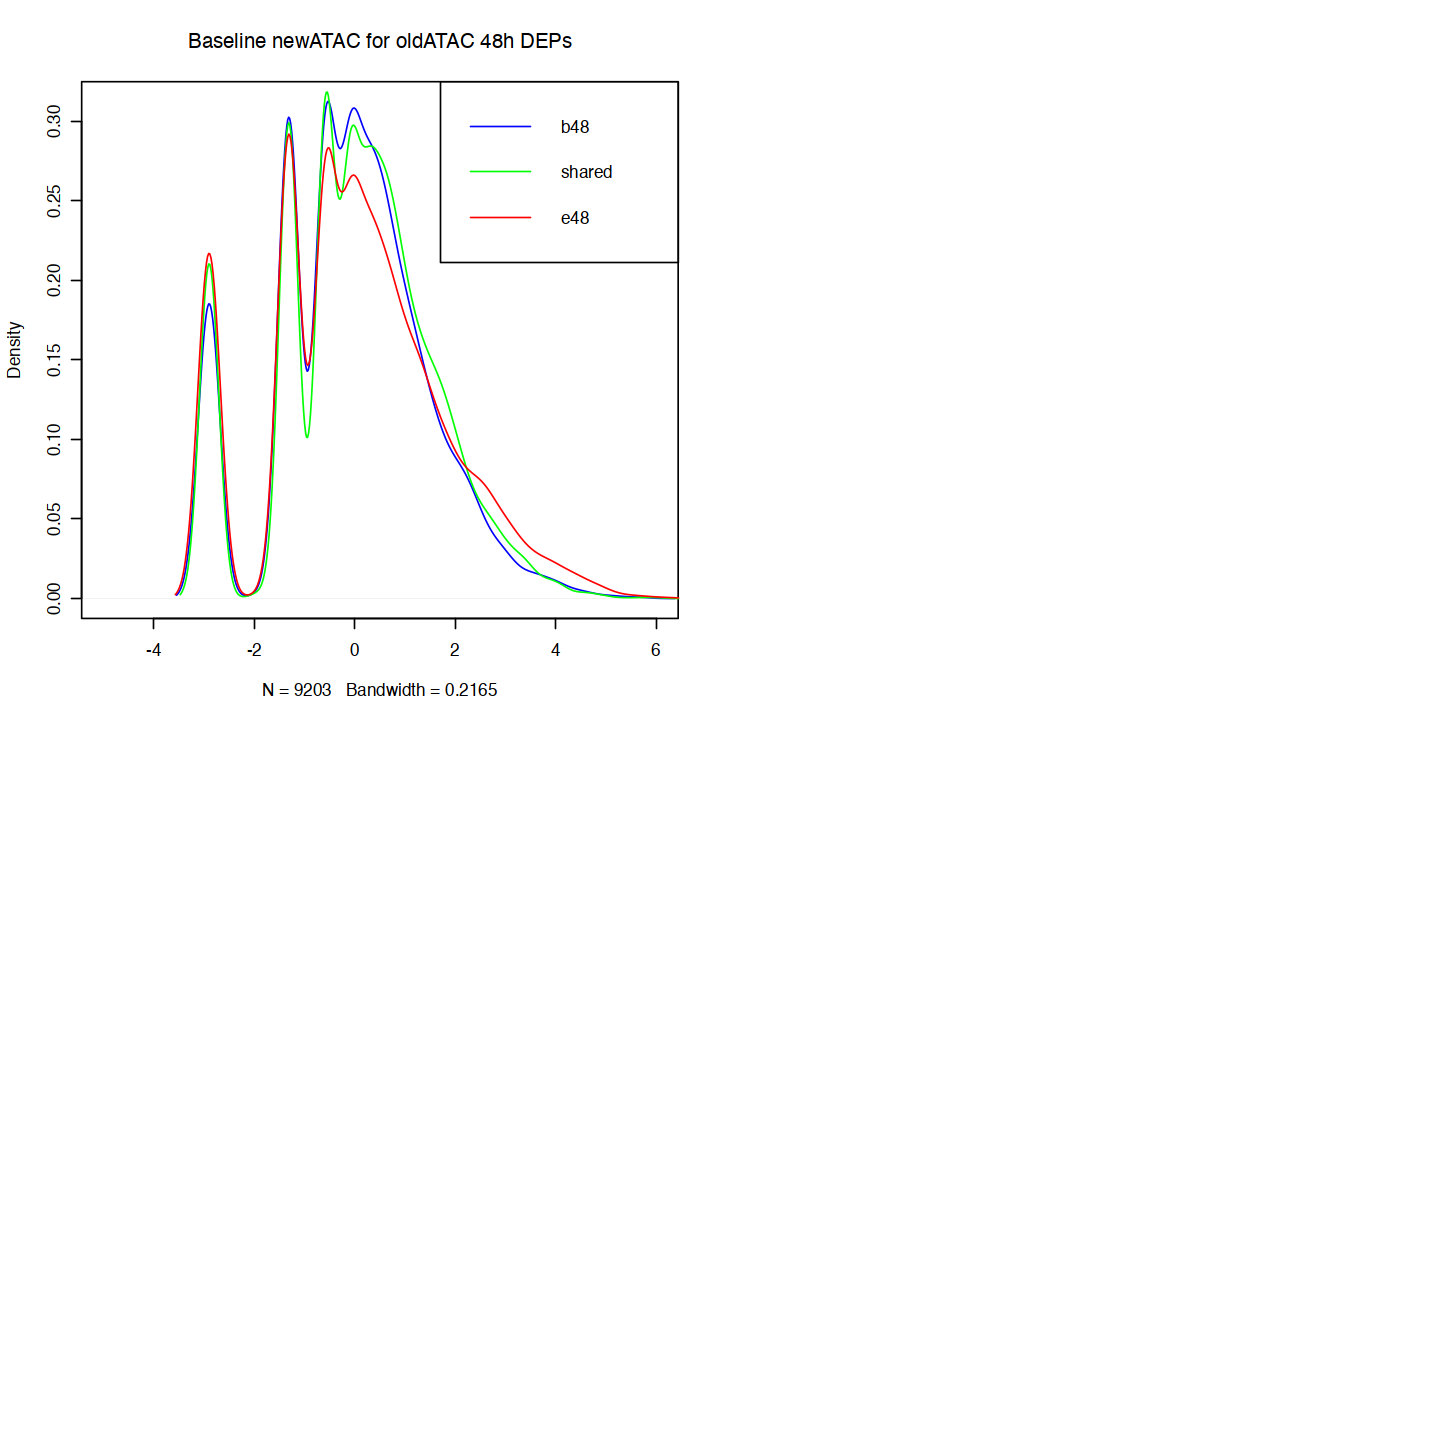

In [55]:
# Plotting their baseline ATAC 
# when plotting TSS's, the differences in ATAC are slightly more muted 

# I used the oldATAC to call peaks that open specifically in BRQ or E2
# then look at their baseline ATAC in both the old and new ATAC (in order to be sure about my results)

# this indicates that there is probably no difference in baseline ATAC between the two populations 
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,2))

plot(density(oldatac_norm[b24_only,1]), col="blue", xlim=c(-6,6), main="Baseline oldATAC for oldATAC 24h DEPs")
lines(density(oldatac_norm[shared_24,1]), col="green")
lines(density(oldatac_norm[e24_only,1]), col="red")
legend("topright", c("b24", "shared", "e24"), lty=1:1, col=c("blue", "green", "red"))

plot(density(oldatac_norm[b48_only,1]), col="blue", xlim=c(-5,6), main="Baseline oldATAC for oldATAC 48h DEPs")
lines(density(oldatac_norm[shared_48,1]), col="green")
lines(density(oldatac_norm[e48_only,1]), col="red")
legend("topright", c("b48", "shared", "e48"), lty=1:1, col=c("blue", "green", "red"))

plot(density(no_na(newatac_norm[new_b24_up,1])), col="blue", xlim=c(-6,6), main="Baseline newATAC for newATAC DEPs")
lines(density(no_na(newatac_norm[new_shared_24,1])), col="green")
lines(density(no_na(newatac_norm[new_e24_only,1])), col="red")
legend("topright", c("b24", "shared", "e24"), lty=1:1, col=c("blue", "green", "red"))

plot(density(no_na(newatac_norm[b24_up,1])), col="blue", xlim=c(-6,6), main="Baseline newATAC for oldATAC 24h DEPs")
lines(density(no_na(newatac_norm[shared_24,1])), col="green")
lines(density(no_na(newatac_norm[e24_only,1])), col="red")
legend("topright", c("b24", "shared", "e24"), lty=1:1, col=c("blue", "green", "red"))

plot(density(no_na(newatac_norm[b48_only,1])), col="blue", xlim=c(-5,6), main="Baseline newATAC for oldATAC 48h DEPs")
lines(density(no_na(newatac_norm[shared_48,1])), col="green")
lines(density(no_na(newatac_norm[e48_only,1])), col="red")
legend("topright", c("b48", "shared", "e48"), lty=1:1, col=c("blue", "green", "red"))



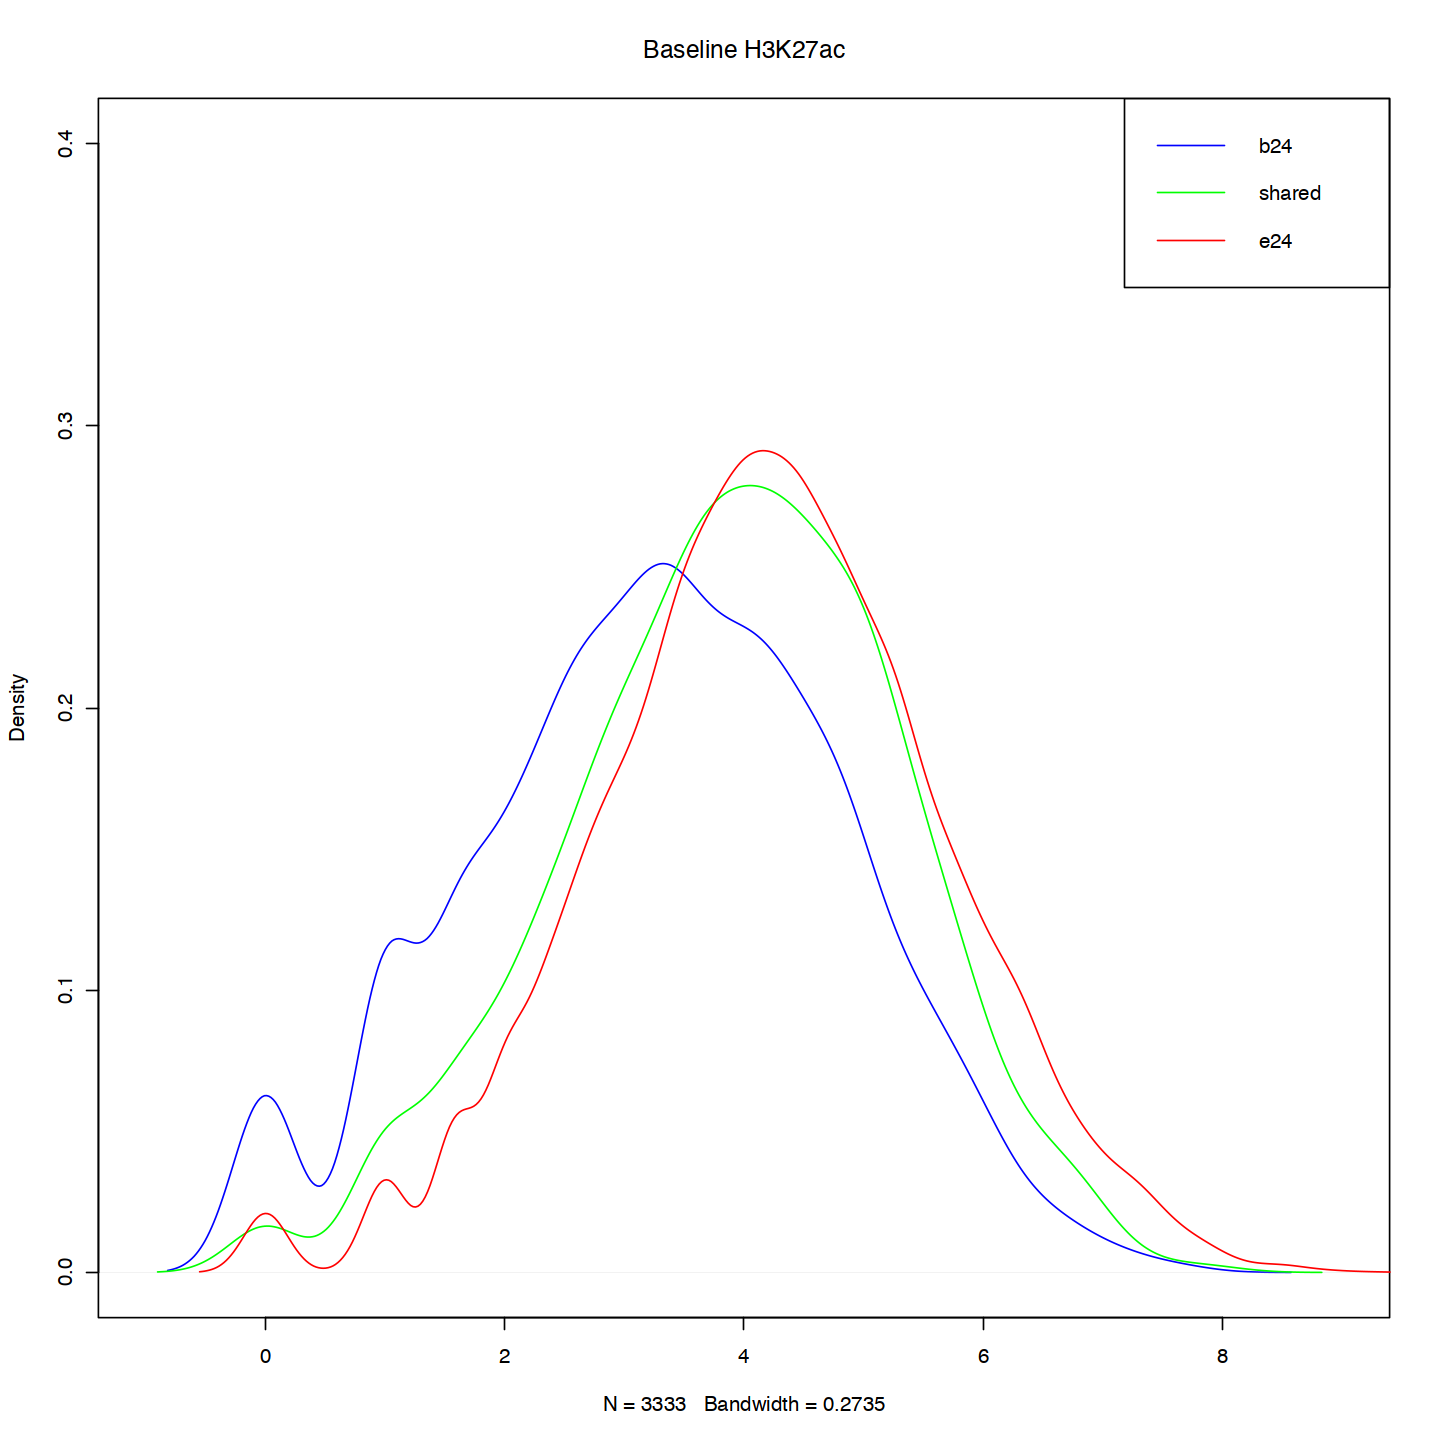

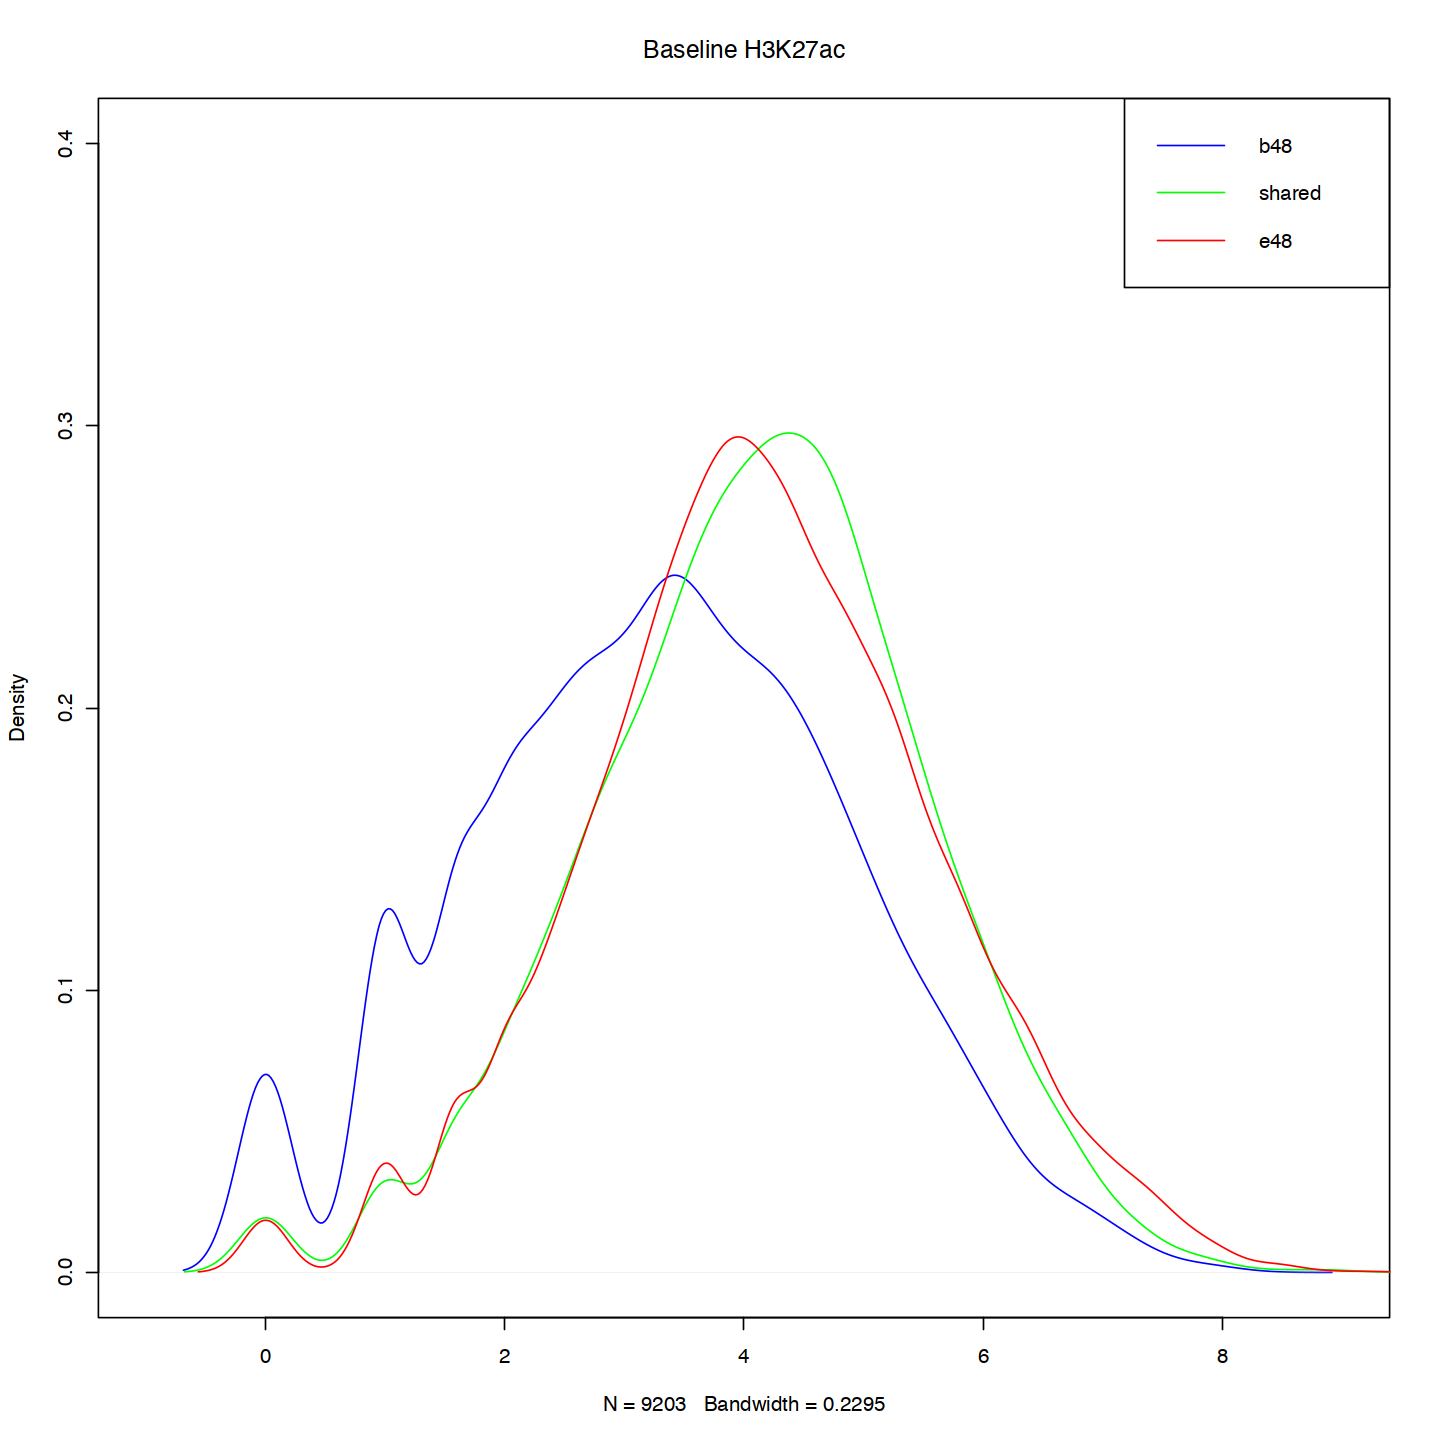

In [56]:
# their baseline h3K27ac 
plot(density(log2(k27ac[b24_only,1]+1)), col="blue", xlim=c(-1,9), ylim=c(0, 0.4), main="Baseline H3K27ac")
lines(density(log2(k27ac[shared_24,1]+1)), col="green")
lines(density(log2(k27ac[e24_only,1]+1)), col="red")
legend("topright", c("b24", "shared", "e24"), lty=1:1, col=c("blue", "green", "red"))


plot(density(log2(k27ac[b48_only,1]+1)), col="blue", xlim=c(-1,9), ylim=c(0, 0.4), main="Baseline H3K27ac")
lines(density(log2(k27ac[shared_48,1]+1)), col="green")
lines(density(log2(k27ac[e48_only,1]+1)), col="red")
legend("topright", c("b48", "shared", "e48"), lty=1:1, col=c("blue", "green", "red"))


In [66]:
# get rnaseq CPMs
rnaseq = read.csv("../data/210421_633_brq_e2w_rnaseq_log_cpm.csv", sep=',')
rownames(rnaseq) = rnaseq$X
rnaseq = rnaseq[,2:dim(rnaseq)[2]]
head(rnaseq)

BRQ_0h_rep1 BRQ_0h_rep2 BRQ_2h_rep1 BRQ_2h_rep2 BRQ_4h_rep1
Mrpl15       6.713146    6.520037    6.536072    6.670286    6.486532   
Lypla1       6.334280    6.275615    6.407374    6.577926    6.349148   
RP24-426M1.3 4.997911    5.021264    5.153718    5.270519    5.121053   
Tcea1        7.292051    7.235587    7.329929    7.319898    7.364407   
Gm6104       3.963615    3.964461    3.994192    4.140236    4.083038   
Atp6v1h      6.296935    6.322661    6.197034    6.144644    6.179970   
             BRQ_4h_rep2 BRQ_6h_rep1 BRQ_6h_rep2 BRQ_8h_rep1 BRQ_8h_rep2 ⋯
Mrpl15       6.634415    6.221050    6.150138    5.894309    5.929673    ⋯
Lypla1       6.501551    6.324821    6.331994    6.318540    6.338262    ⋯
RP24-426M1.3 5.243147    5.134315    5.155950    5.029567    4.993949    ⋯
Tcea1        7.327297    7.215142    7.146185    6.927842    7.079222    ⋯
Gm6104       4.004925    4.238743    4.222944    3.780851    4.220393    ⋯
Atp6v1h      6.131141    6.225907    6.075413    6.035190    6.017780    ⋯
             X633_E2w_36h_rep1 X633_E2w_36h_rep2 X633_E2w_48h_rep1
Mrpl15       6.535348          6.465442          6.148400         
Lypla1       7.021458          6.910749          6.890058         
RP24-426M1.3 5.106281          5.080913          4.937943         
Tcea1        7.426865          7.373496          7.059390         
Gm6104       3.469746          3.487318          3.227843         
Atp6v1h      6.733229          6.740717          6.697961         
             X633_E2w_48h_rep2 X633_E2w_72h_rep1 X633_E2w_72h_rep2
Mrpl15       6.160432          5.400269          5.721165         
Lypla1       7.122950          7.023488          7.136403         
RP24-426M1.3 5.121040          4.873773          4.964717         
Tcea1        7.339118          6.849130          6.939185         
Gm6104       3.353461          2.819287          2.888675         
Atp6v1h      6.794731          6.772076          6.902699         
             X633_E2w_96h_rep1 X633_E2w_96h_rep2 X633_E2w_120h_rep1
Mrpl15       4.973701          4.724085           4.942570         
Lypla1       7.031072          6.877112           6.985250         
RP24-426M1.3 5.046954          4.755924           4.936216         
Tcea1        7.013781          6.646117           6.669542         
Gm6104       1.829393          1.943217          -1.257469         
Atp6v1h      7.130321          6.928719           7.298243         
             X633_E2w_120h_rep2
Mrpl15        5.156600         
Lypla1        6.889528         
RP24-426M1.3  4.830166         
Tcea1         6.705267         
Gm6104       -1.406029         
Atp6v1h       7.413832

In [67]:
# these are log2 CPMs
# pretty close to 1M... let's normalize to 1M because that is the universe I am dealing with
sum_of_sample_cpm = apply(2^rnaseq, 2, sum)

rnaseq_cpm = sweep(2^rnaseq, 2, sum_of_sample_cpm, '/') * 1e6
head(rnaseq_cpm)

BRQ_0h_rep1 BRQ_0h_rep2 BRQ_2h_rep1 BRQ_2h_rep2 BRQ_4h_rep1
Mrpl15       103.43184    93.77783    92.77829    95.52783    90.05768  
Lypla1        79.54341    79.16291    84.86024    89.60386    81.87739  
RP24-426M1.3  31.50049    33.18368    35.58904    36.20413    34.95189  
Tcea1        154.49777   153.99339   160.84995   149.85890   165.49596  
Gm6104        15.38023    15.95126    15.93178    16.53899    17.02147  
Atp6v1h       77.51083    81.78694    73.34754    66.35837    72.81761  
             BRQ_4h_rep2 BRQ_6h_rep1 BRQ_6h_rep2 BRQ_8h_rep1 BRQ_8h_rep2 ⋯
Mrpl15        92.76849    74.92343    71.04765    62.54051    63.79066   ⋯
Lypla1        84.60667    80.51115    80.59239    83.92045    84.67489   ⋯
RP24-426M1.3  35.36609    35.27588    35.66722    34.34380    33.34849   ⋯
Tcea1        149.96116   149.23449   141.70656   128.02242   141.51615   ⋯
Gm6104        14.99150    18.96199    18.68128    14.45264    19.50799   ⋯
Atp6v1h       65.44857    75.17614    67.46142    68.95583    67.80785   ⋯
             X633_E2w_36h_rep1 X633_E2w_36h_rep2 X633_E2w_48h_rep1
Mrpl15        89.80956          85.91008          69.197738       
Lypla1       125.79292         116.97551         115.705324       
RP24-426M1.3  33.35267          32.90482          29.902542       
Tcea1        166.60803         161.21134         130.115020       
Gm6104        10.72715          10.90284           9.139382       
Atp6v1h      103.01271         103.97050         101.280634       
             X633_E2w_48h_rep2 X633_E2w_72h_rep1 X633_E2w_72h_rep2
Mrpl15        69.78052          39.895178         49.496930       
Lypla1       135.98190         122.901687        132.010182       
RP24-426M1.3  33.95049          27.696770         29.299812       
Tcea1        157.96257         108.910785        115.143327       
Gm6104         9.97130           6.667565          6.948866       
Atp6v1h      108.31222         103.246533        112.267861       
             X633_E2w_96h_rep1 X633_E2w_96h_rep2 X633_E2w_120h_rep1
Mrpl15        24.242713         21.911942         22.6139936       
Lypla1       100.904729         97.455574         93.1719471       
RP24-426M1.3  25.505425         22.400891         22.5146104       
Tcea1         99.702544         83.036754         74.8596485       
Gm6104         2.741891          3.188279          0.3075953       
Atp6v1h      108.090702        101.004749        115.7458819       
             X633_E2w_120h_rep2
Mrpl15        27.7514151       
Lypla1        92.2461874       
RP24-426M1.3  22.1318974       
Tcea1         81.1858238       
Gm6104         0.2935871       
Atp6v1h      132.6721331

In [71]:
# normalize to TPM
transcript_lengths = read.table("~/Dropbox (MIT)/MVH_Code/shared_data/mm10_gene_length.txt", sep='\t', header=T)[,5:6]
colnames(transcript_lengths) = c("genelength", "gene")
transcript_lengths = data.frame(transcript_lengths %>% group_by(gene) %>% summarize(genelength = max(genelength)))
rownames(transcript_lengths) = transcript_lengths$gene
head(transcript_lengths)

gene          genelength
                            9960      
0610005C13Rik 0610005C13Rik 2434      
0610006L08Rik 0610006L08Rik 1589      
0610009B22Rik 0610009B22Rik  892      
0610009E02Rik 0610009E02Rik 1609      
0610009L18Rik 0610009L18Rik  974

In [76]:
# normalize by length
comb_genes = intersect(rownames(rnaseq_cpm), rownames(transcript_lengths))
rnaseq_cpm_comb = rnaseq_cpm[comb_genes,]
transcript_lengths = transcript_lengths[comb_genes,]

# number of transcripts
# this is really rough because it doesn't account for all isoforms, and also doesn't use effective length
# https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/
# Just for anyone else that is confused by this – here’s another good explanation of this:
# https://groups.google.com/forum/#!topic/rsem-users/IaZmviqghJc

rnaseq_div_by_len = sweep(rnaseq_cpm_comb, 1, transcript_lengths$genelength, `/`)
head(rnaseq_div_by_len)

BRQ_0h_rep1 BRQ_0h_rep2 BRQ_2h_rep1 BRQ_2h_rep2 BRQ_4h_rep1 BRQ_4h_rep2
Mrpl15  0.022485182 0.020386485 0.020169194 0.020766920 0.019577756 0.020167063
Lypla1  0.017850856 0.017765465 0.019044038 0.020108586 0.018374640 0.018987135
Tcea1   0.054133768 0.053957040 0.056359477 0.052508375 0.057987372 0.052544203
Gm6104  0.025506194 0.026453165 0.026420856 0.027427839 0.028227969 0.024861530
Atp6v1h 0.016051114 0.016936620 0.015188970 0.013741639 0.015079232 0.013553234
Rb1cc1  0.006189191 0.007377557 0.007511133 0.005621365 0.007492585 0.004911476
        BRQ_6h_rep1 BRQ_6h_rep2 BRQ_8h_rep1 BRQ_8h_rep2 ⋯ X633_E2w_36h_rep1
Mrpl15  0.01628770  0.015445141 0.013595762 0.013867535 ⋯ 0.01952382       
Lypla1  0.01806803  0.018086264 0.018833136 0.019002444 ⋯ 0.02823001       
Tcea1   0.05228959  0.049651915 0.044857191 0.049585196 ⋯ 0.05837703       
Gm6104  0.03144608  0.030980569 0.023967897 0.032351564 ⋯ 0.01778964       
Atp6v1h 0.01556764  0.013970060 0.014279526 0.014041800 ⋯ 0.02133210       
Rb1cc1  0.00781542  0.008082604 0.008791678 0.009739338 ⋯ 0.01069672       
        X633_E2w_36h_rep2 X633_E2w_48h_rep1 X633_E2w_48h_rep2 X633_E2w_72h_rep1
Mrpl15  0.018676104       0.01504299        0.01516968        0.008672865      
Lypla1  0.026251236       0.02596619        0.03051659        0.027581169      
Tcea1   0.056486104       0.04559041        0.05534778        0.038160752      
Gm6104  0.018080993       0.01515652        0.01653615        0.011057322      
Atp6v1h 0.021530441       0.02097342        0.02242953        0.021380520      
Rb1cc1  0.009941873       0.01050342        0.01230558        0.013152182      
        X633_E2w_72h_rep2 X633_E2w_96h_rep1 X633_E2w_96h_rep2
Mrpl15  0.01076020        0.005270155       0.004763466      
Lypla1  0.02962527        0.022644688       0.021870641      
Tcea1   0.04034454        0.034934318       0.029094868      
Gm6104  0.01152382        0.004547083       0.005287362      
Atp6v1h 0.02324868        0.022383662       0.020916287      
Rb1cc1  0.01248987        0.013611945       0.013831152      
        X633_E2w_120h_rep1 X633_E2w_120h_rep2
Mrpl15  0.0049160856       0.0060329163      
Lypla1  0.0209093239       0.0207015681      
Tcea1   0.0262297297       0.0284463293      
Gm6104  0.0005101083       0.0004868775      
Atp6v1h 0.0239689132       0.0274740387      
Rb1cc1  0.0117479330       0.0110612008

In [78]:
# get TPM
sum_of_sample_transcripts = apply(rnaseq_div_by_len, 2, sum)
rnaseq_tpm = log2(sweep(rnaseq_div_by_len, 2, sum_of_sample_transcripts, `/`) * 1e6)
head(rnaseq_tpm)

BRQ_0h_rep1 BRQ_0h_rep2 BRQ_2h_rep1 BRQ_2h_rep2 BRQ_4h_rep1 BRQ_4h_rep2
Mrpl15  5.634478    5.559122    5.558959    5.508472    5.522629    5.444946   
Lypla1  5.301497    5.360584    5.476145    5.461997    5.431130    5.357967   
Tcea1   6.902032    6.963320    7.041464    6.846733    7.089152    6.826476   
Gm6104  5.816351    5.934949    5.948483    5.909826    6.050539    5.746860   
Atp6v1h 5.148177    5.291655    5.149830    4.912739    5.145977    4.871582   
Rb1cc1  3.773326    4.092724    4.133908    3.623178    4.136949    3.407174   
        BRQ_6h_rep1 BRQ_6h_rep2 BRQ_8h_rep1 BRQ_8h_rep2 ⋯ X633_E2w_36h_rep1
Mrpl15  5.194146    5.104247    4.942586    4.992928    ⋯ 5.465954         
Lypla1  5.343803    5.331989    5.412702    5.447402    ⋯ 5.997949         
Tcea1   6.876887    6.788944    6.664768    6.831126    ⋯ 7.046120         
Gm6104  6.143243    6.108458    5.760532    6.215052    ⋯ 5.331756         
Atp6v1h 5.128914    4.959432    5.013377    5.010945    ⋯ 5.593745         
Rb1cc1  4.134759    4.169986    4.313639    4.483112    ⋯ 4.597887         
        X633_E2w_36h_rep2 X633_E2w_48h_rep1 X633_E2w_48h_rep2 X633_E2w_72h_rep1
Mrpl15  5.441528          5.118466          5.178480          4.323864         
Lypla1  5.932720          5.906009          6.186883          5.992967         
Tcea1   7.038230          6.718105          7.045815          6.461373         
Gm6104  5.394808          5.129314          5.302913          4.674285         
Atp6v1h 5.646712          5.597937          5.742689          5.625580         
Rb1cc1  4.531924          4.600234          4.876601          4.924586         
        X633_E2w_72h_rep2 X633_E2w_96h_rep1 X633_E2w_96h_rep2
Mrpl15  4.579821          3.600175          3.484067         
Lypla1  6.040944          5.703430          5.682979         
Tcea1   6.486489          6.328902          6.094748         
Gm6104  4.678735          3.387271          3.634603         
Atp6v1h 5.691264          5.686703          5.618610         
Rb1cc1  4.794874          4.969131          5.021904         
        X633_E2w_120h_rep1 X633_E2w_120h_rep2
Mrpl15  3.5686072          3.8490751         
Lypla1  5.6571717          5.6278877         
Tcea1   5.9842282          6.0863902         
Gm6104  0.2999727          0.2178503         
Atp6v1h 5.8541898          6.0362167         
Rb1cc1  4.8254322          4.7236557

In [404]:
# LFCs
rnaseq_tpm$b4_rna_lfc = with(rnaseq_tpm, (BRQ_4h_rep1 + BRQ_4h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b8_rna_lfc = with(rnaseq_tpm, (BRQ_8h_rep1 + BRQ_8h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b12_rna_lfc = with(rnaseq_tpm, (BRQ_12h_rep1 + BRQ_12h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b24_rna_lfc = with(rnaseq_tpm, (BRQ_24h_rep1 + BRQ_24h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b48_rna_lfc = with(rnaseq_tpm, (BRQ_48h_rep1 + BRQ_48h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b72_rna_lfc = with(rnaseq_tpm, (BRQ_72h_rep1 + BRQ_72h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)
rnaseq_tpm$b96_rna_lfc = with(rnaseq_tpm, (BRQ_96h_rep1 + BRQ_96h_rep2 - BRQ_0h_rep1 - BRQ_0h_rep2)/2)

rnaseq_tpm$e4_rna_lfc = with(rnaseq_tpm, (X633_E2w_4h_rep1 + X633_E2w_4h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e8_rna_lfc = with(rnaseq_tpm, (X633_E2w_8h_rep1 + X633_E2w_8h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e12_rna_lfc = with(rnaseq_tpm, (X633_E2w_12h_rep1 + X633_E2w_12h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e24_rna_lfc = with(rnaseq_tpm, (X633_E2w_24h_rep1 + X633_E2w_24h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e48_rna_lfc = with(rnaseq_tpm, (X633_E2w_48h_rep1 + X633_E2w_48h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e72_rna_lfc = with(rnaseq_tpm, (X633_E2w_72h_rep1 + X633_E2w_72h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)
rnaseq_tpm$e96_rna_lfc = with(rnaseq_tpm, (X633_E2w_96h_rep1 + X633_E2w_96h_rep2 - X633_E2w_0h_rep1 - X633_E2w_0h_rep2)/2)

rnaseq_lfc = rnaseq_tpm[,(dim(rnaseq_tpm)[2]-13):dim(rnaseq_tpm)[2]]
head(rnaseq_lfc)

b12_rna_lfc  b24_rna_lfc b48_rna_lfc b72_rna_lfc b96_rna_lfc
Mrpl15  -0.683561351 -0.8280591  -0.9100998  -0.62755116 -0.5732331 
Lypla1   0.187385715 -0.2898696  -0.4364092  -0.49498132 -0.2784034 
Tcea1   -0.220242309 -0.5681033  -0.4647475  -0.29734396 -0.2588406 
Gm6104  -0.296228433 -0.6979660  -1.0775644  -1.48091176 -1.0712669 
Atp6v1h -0.005969728 -0.2685383  -0.1632973   0.06841915  0.1032106 
Rb1cc1   0.645447878  0.4915007   0.7100512   0.72460152  0.5536092 
        e12_rna_lfc e24_rna_lfc e48_rna_lfc e72_rna_lfc e96_rna_lfc b4_rna_lfc 
Mrpl15  -0.29662685 -0.1173904  -0.56728503 -1.26391555 -2.17363731 -0.11301242
Lypla1  -0.25194521 -0.1300931  -0.12769039 -0.15718100 -0.48093206  0.06350791
Tcea1   -0.38834537 -0.2429536  -0.56743460 -0.97546354 -1.23756957  0.02513835
Gm6104  -0.58364112 -0.8202734  -1.25040178 -1.79000468 -2.95557817  0.02304939
Atp6v1h -0.02312997  0.1226405   0.06748939  0.05559873  0.04983305 -0.21113646
Rb1cc1  -0.37513943 -0.1670251   0.05088499  0.17219698  0.30798466 -0.16096367
        b8_rna_lfc  e4_rna_lfc e8_rna_lfc
Mrpl15  -0.62904288 -0.2937304 -0.3395867
Lypla1   0.09901148 -0.2285833 -0.1401574
Tcea1   -0.18472893 -0.2164400 -0.3635213
Gm6104   0.11214212 -0.1962826 -0.4674392
Atp6v1h -0.20775504 -0.2998589 -0.1346923
Rb1cc1   0.46535082 -0.1554232 -0.2166392

In [80]:
# linking peaks to genes
b24_up_genes = unique(great_data[k27_up_b24,]$gene)
shared24_up_genes = unique(great_data[k27_up_shared24,]$gene)
e24_up_genes = unique(great_data[k27_up_e24,]$gene)

b24_down_genes = unique(great_data[k27_down_b24,]$gene)
shared24_down_genes = unique(great_data[k27_down_shared24,]$gene)
e24_down_genes = unique(great_data[k27_down_e24,]$gene)


In [81]:
# Median TPMs
median(rnaseq_tpm[b24_up_genes,]$BRQ_0h_rep1, na.rm=T)
median(rnaseq_tpm[shared24_up_genes,]$BRQ_0h_rep1, na.rm=T)
median(rnaseq_tpm[e24_up_genes,]$BRQ_0h_rep1, na.rm=T)

median(rnaseq_tpm[b24_down_genes,]$BRQ_0h_rep1, na.rm=T)
median(rnaseq_tpm[shared24_down_genes,]$BRQ_0h_rep1, na.rm=T)
median(rnaseq_tpm[e24_down_genes,]$BRQ_0h_rep1, na.rm=T)

[1] 3.876894

[1] 3.96374

[1] 4.148484

[1] 4.522815

[1] 4.21402

[1] 4.367733

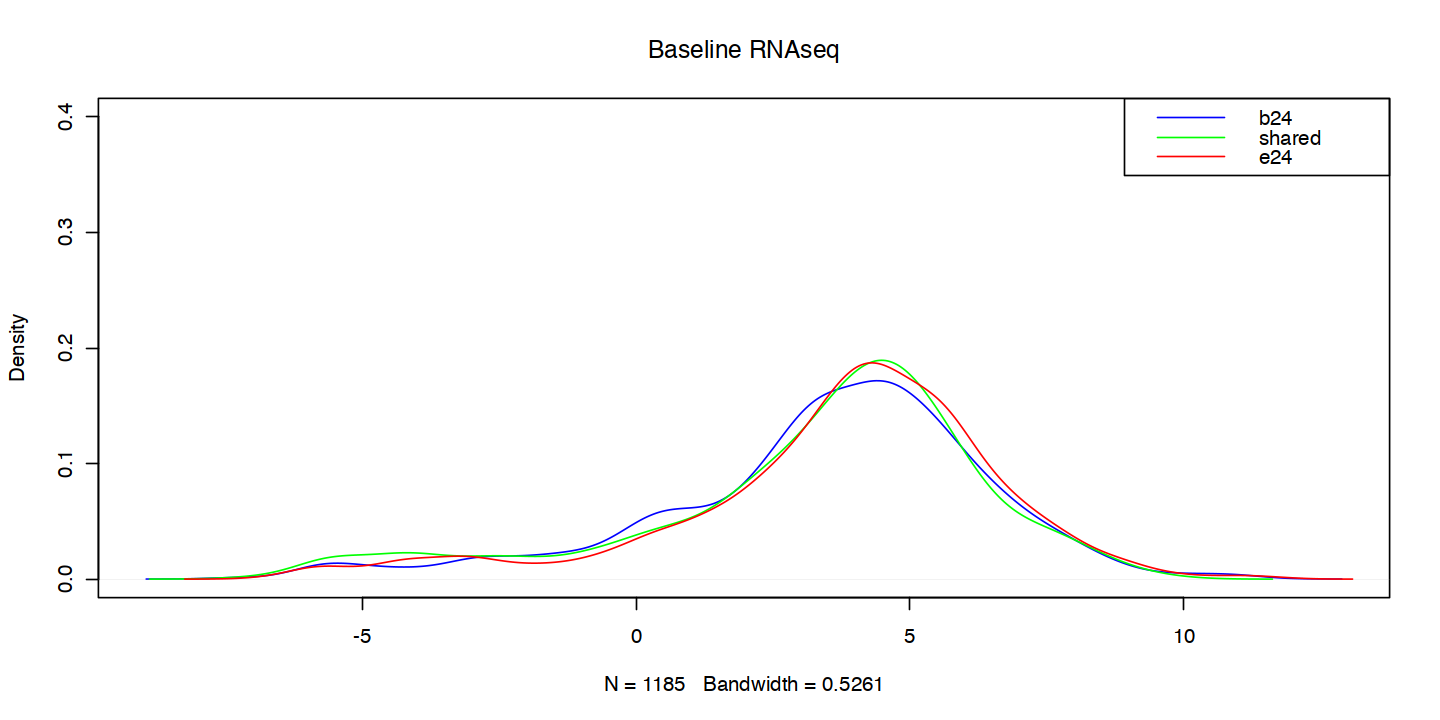

In [82]:
# Plotting density of logTPMs for genes associated with peaks
# basically no difference  
plot(density(no_na(rnaseq_tpm[b24_up_genes,]$BRQ_0h_rep1)), col="blue", ylim=c(0, 0.4), main="Baseline RNAseq")
lines(density(no_na(rnaseq_tpm[shared24_up_genes,]$BRQ_0h_rep1)), col="green")
lines(density(no_na(rnaseq_tpm[e24_up_genes,]$BRQ_0h_rep1)), col="red")
legend("topright", c("b24", "shared", "e24"), lty=1:1, col=c("blue", "green", "red"))


# plot(density(log2(k27ac[b48_only,1]+1)), col="blue", xlim=c(-1,9), ylim=c(0, 0.4), main="Baseline RNAseq")
# lines(density(log2(k27ac[shared_48,1]+1)), col="green")
# lines(density(log2(k27ac[e48_only,1]+1)), col="red")
# legend("topright", c("b48", "shared", "e48"), lty=1:1, col=c("blue", "green", "red"))

## DEGs at 8h and 24h, and correlation with H3K27ac

In [57]:
degs = readRDS("../data/230620_633_brq_e2w_degs.rds")
brq_degs = degs[[1]]
e2w_degs = degs[[2]]

brq_degs[["24"]]$gene = rownames(brq_degs[["24"]])
e2w_degs[["24"]]$gene = rownames(e2w_degs[["24"]])


In [58]:
head(brq_degs[["24"]])

logFC     AveExpr  t         P.Value      adj.P.Val    B        gene   
Pcyt1a   2.423862 7.484506  32.15627 5.010553e-25 3.927461e-21 47.17583 Pcyt1a 
Itgb3    3.493352 6.723383  31.95167 6.050160e-25 3.927461e-21 46.88853 Itgb3  
Siglecf  3.756085 5.878658  30.46875 2.457229e-24 1.063407e-20 45.41843 Siglecf
Gart    -1.931261 7.761110 -29.87408 4.389195e-24 1.424623e-20 45.04698 Gart   
Cd33     2.537153 8.544836  28.14094 2.537102e-23 6.587838e-20 43.31353 Cd33   
Cd300lb  3.968141 5.473633  27.85599 3.418008e-23 7.396000e-20 42.70691 Cd300lb

In [59]:
# shared upregulated at 24h
b24_rna_up = subset(brq_degs[["24"]], logFC > 1 & adj.P.Val < 0.05)
e24_rna_up = subset(e2w_degs[["24"]], logFC > 1 & adj.P.Val < 0.05)
b24_rna_down = subset(brq_degs[["24"]], logFC < -1 & adj.P.Val < 0.05)
e24_rna_down = subset(e2w_degs[["24"]], logFC < -1 & adj.P.Val < 0.05)
shared_upreg24 = intersect(rownames(b24_rna_up), rownames(e24_rna_up))  # 327

In [60]:
# promoter peaks
tss_peaks_df = subset(peakAnno, annobrief == "Promoter")
head(tss_peaks_df)

seqnames start   end     width strand peak_id annotation       geneChr
32 chr1     4496377 4496614  238  *      peak32  Promoter (<=1kb) 1      
44 chr1     4785244 4786302 1059  *      peak44  Promoter (<=1kb) 1      
45 chr1     4807333 4808296  964  *      peak45  Promoter (<=1kb) 1      
48 chr1     4857348 4858497 1150  *      peak48  Promoter (<=1kb) 1      
52 chr1     5070126 5070592  467  *      peak52  Promoter (<=1kb) 1      
53 chr1     5082738 5083698  961  *      peak53  Promoter (<=1kb) 1      
   geneStart geneEnd geneLength geneStrand geneId transcriptId         
32 4492467   4496396  3930      2          20671  ENSMUST00000192913.1 
44 4783572   4785692  2121      2          27395  ENSMUST00000132625.1 
45 4807788   4848410 40623      1          18777  ENSMUST00000134384.7 
48 4857814   4897905 40092      1          21399  ENSMUST00000081551.13
52 5062779   5070273  7495      2          58175  ENSMUST00000133521.1 
53 5083080   5162529 79450      1          108664 ENSMUST00000044369.12
   distanceToTSS ENSEMBL            SYMBOL 
32 0             ENSMUSG00000025902 Sox17  
44 0             ENSMUSG00000033845 Mrpl15 
45 0             ENSMUSG00000025903 Lypla1 
48 0             ENSMUSG00000033813 Tcea1  
52 0             ENSMUSG00000002459 Rgs20  
53 0             ENSMUSG00000033793 Atp6v1h
   GENENAME                                        annobrief
32 SRY (sex determining region Y)-box 17           Promoter 
44 mitochondrial ribosomal protein L15             Promoter 
45 lysophospholipase 1                             Promoter 
48 transcription elongation factor A (SII) 1       Promoter 
52 regulator of G-protein signaling 20             Promoter 
53 ATPase, H+ transporting, lysosomal V1 subunit H Promoter


	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 23.313, df = 4823, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2926510 0.3433746
sample estimates:
      cor 
0.3182405 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 10.998, df = 759, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3077890 0.4304748
sample estimates:
      cor 
0.3707482 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


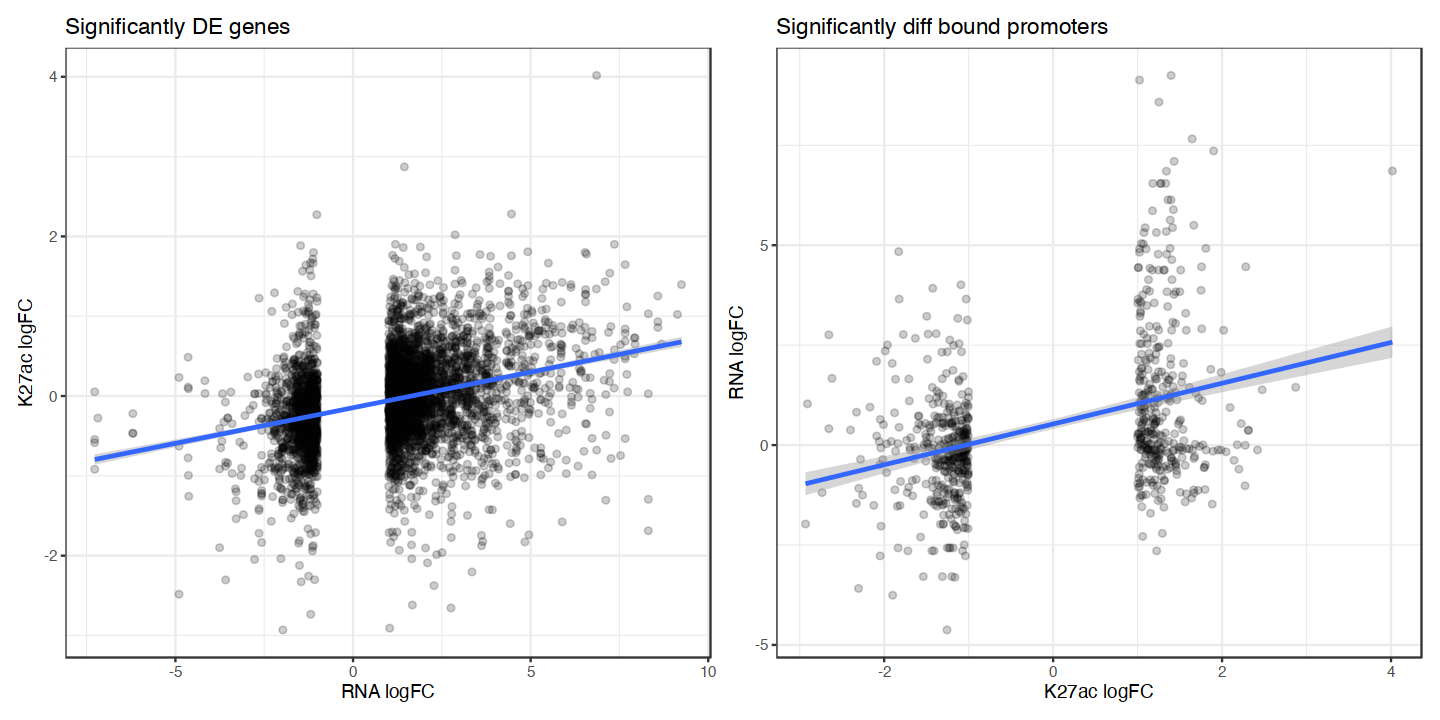

In [61]:
# B24
k27_b24_dep_tss = merge(k27_b24_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_b24_dep_tss = merge(k27_b24_dep_tss, brq_degs[["24"]], by.x="SYMBOL", by.y=0)

k27_b24_dep_tss_rnasig = subset(k27_b24_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_b24_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_b24_dep_tss_k27sig = subset(k27_b24_dep_tss, abs(logFC.x) > 1 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_b24_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_b24_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_b24_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2


	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 31.412, df = 2192, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5276065 0.5853528
sample estimates:
      cor 
0.5571528 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 31.638, df = 2433, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5111329 0.5674469
sample estimates:
      cor 
0.5398937 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


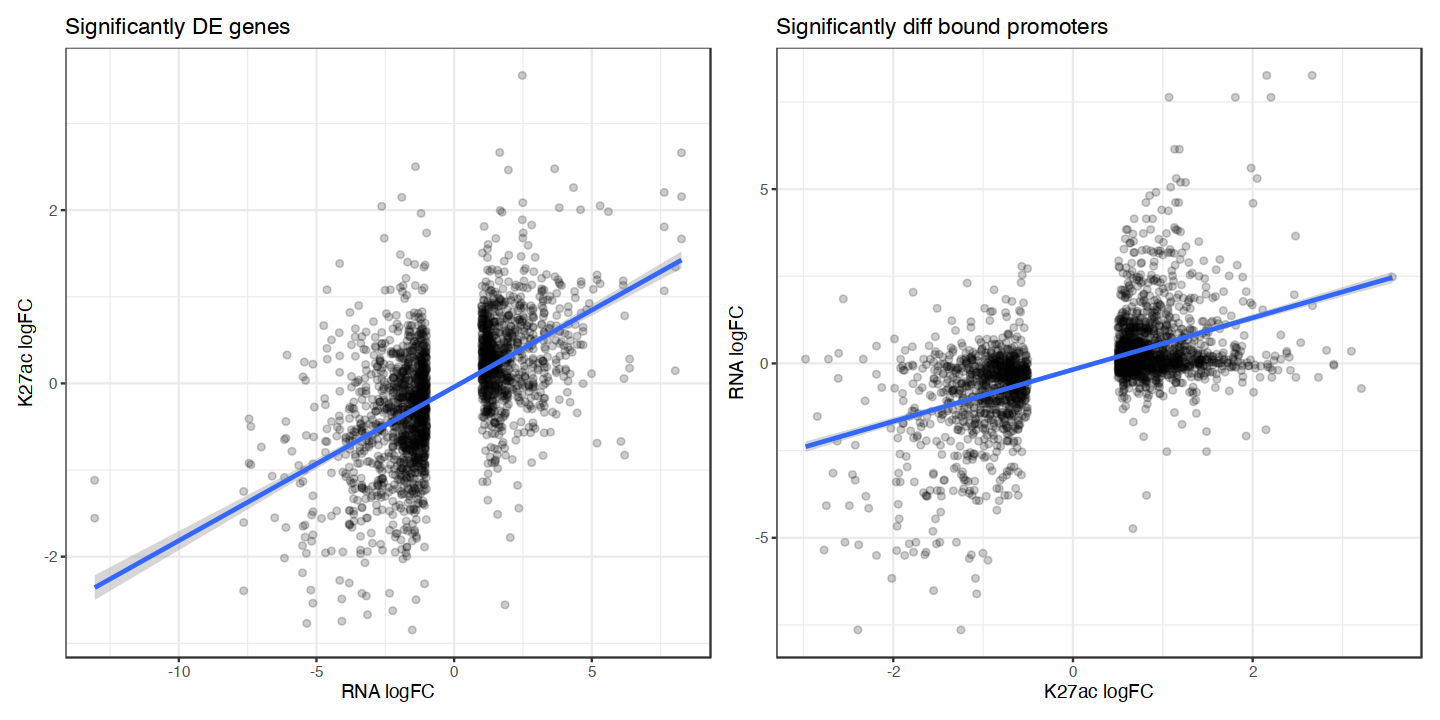

In [62]:
# e24
k27_e24_dep_tss = merge(k27_e24_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_e24_dep_tss = merge(k27_e24_dep_tss, e2w_degs[["24"]], by.x="SYMBOL", by.y=0)

k27_e24_dep_tss_rnasig = subset(k27_e24_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_e24_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_e24_dep_tss_k27sig = subset(k27_e24_dep_tss, abs(logFC.x) > 0.5 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_e24_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_e24_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_e24_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2

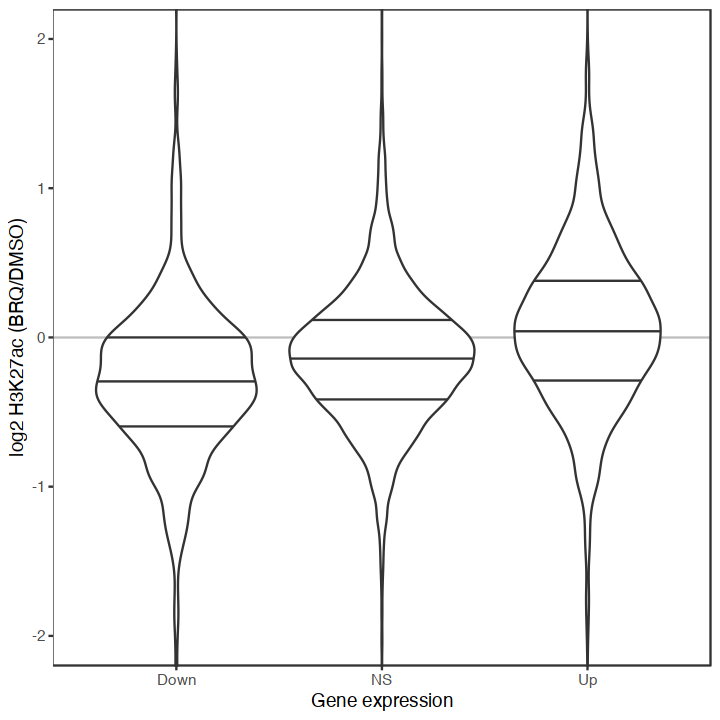

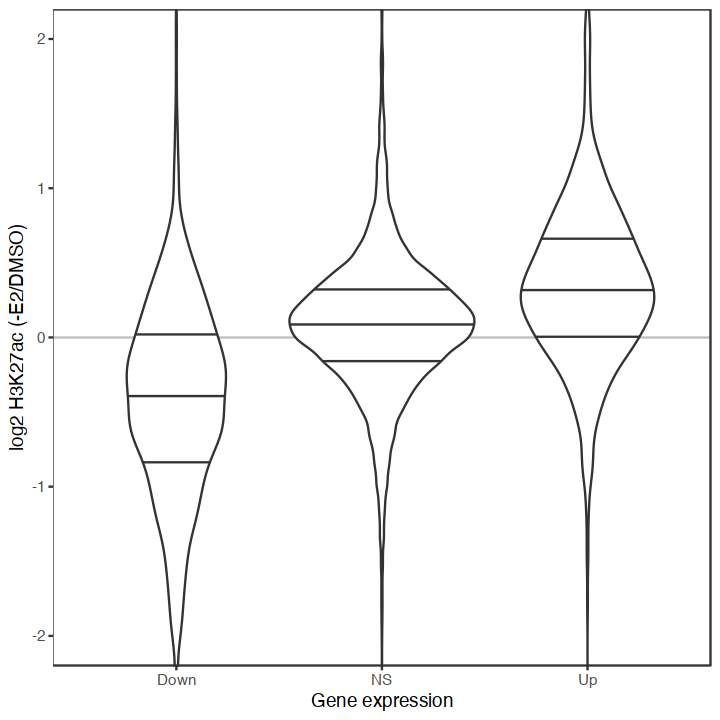

In [63]:
# g1 = ggplot(k27_b24_dep_tss_rnasig, aes(x=logFC.y > 0, y=logFC.x)) + geom_boxplot() + 
# theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes") +
# coord_cartesian(ylim=c(-2,2))

# g2 = ggplot(k27_b24_dep_tss_k27sig, aes(x=logFC.x > 0, y=logFC.y)) + geom_boxplot() + 
# theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters") +
# coord_cartesian(ylim=c(-3,3))

# g1 + g2

k27_b24_dep_tss$gene_exp = "NS"
k27_b24_dep_tss[(k27_b24_dep_tss$logFC.y > 1 & k27_b24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Up"
k27_b24_dep_tss[(k27_b24_dep_tss$logFC.y < -1 & k27_b24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Down"

k27_e24_dep_tss$gene_exp = "NS"
k27_e24_dep_tss[(k27_e24_dep_tss$logFC.y > 1 & k27_e24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Up"
k27_e24_dep_tss[(k27_e24_dep_tss$logFC.y < -1 & k27_e24_dep_tss$adj.P.Val.y < 0.05),]$gene_exp = "Down"

options(repr.plot.width=6, repr.plot.height=6)
g1 = ggplot(k27_b24_dep_tss, aes(x=gene_exp, y=logFC.x)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-2,2)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("Gene expression") + ylab("log2 H3K27ac (BRQ/DMSO)") 

g2 = ggplot(k27_e24_dep_tss, aes(x=gene_exp, y=logFC.x)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-2,2)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("Gene expression") + ylab("log2 H3K27ac (-E2/DMSO)") 

g1
ggsave("../output/230920_bd302_erhoxa9_brq_k27ac_prom.pdf", width=2, height=2.5)

g2
ggsave("../output/230920_bd302_erhoxa9_e2_k27ac_prom.pdf", width=2, height=2.5)

In [116]:
# Mann-Whitney tests (promoters)
wilcox.test(subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_b24_dep_tss, gene_exp == "Up")$logFC.y)
wilcox.test(subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_b24_dep_tss, gene_exp == "Down")$logFC.y)

wilcox.test(subset(k27_e24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_e24_dep_tss, gene_exp == "Up")$logFC.y)
wilcox.test(subset(k27_e24_dep_tss, gene_exp == "NS")$logFC.y, subset(k27_e24_dep_tss, gene_exp == "Down")$logFC.y)


	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_b24_dep_tss, gene_exp == "Up")$logFC.y
W = 245030, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_b24_dep_tss, gene_exp == "Down")$logFC.y
W = 19473960, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_e24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_e24_dep_tss, gene_exp == "Up")$logFC.y
W = 68932, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_e24_dep_tss, gene_exp == "NS")$logFC.y and subset(k27_e24_dep_tss, gene_exp == "Down")$logFC.y
W = 20342854, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [65]:
# enhancers

k27_b24_enh = merge(subset(k27_b24_dep, rownames(k27_b24_dep) %in% enh_peaks), great_data_with_tss, by.x=0, by.y=0)
rownames(k27_b24_enh) = k27_b24_enh$Row.names
k27_b24_enh = merge(k27_b24_enh, brq_degs[["24"]], by.x="gene", by.y=0)

k27_e24_enh = merge(subset(k27_e24_dep, rownames(k27_e24_dep) %in% enh_peaks), great_data_with_tss, by.x=0, by.y=0)
rownames(k27_e24_enh) = k27_e24_enh$Row.names
k27_e24_enh = merge(k27_e24_enh, e2w_degs[["24"]], by.x="gene", by.y=0)


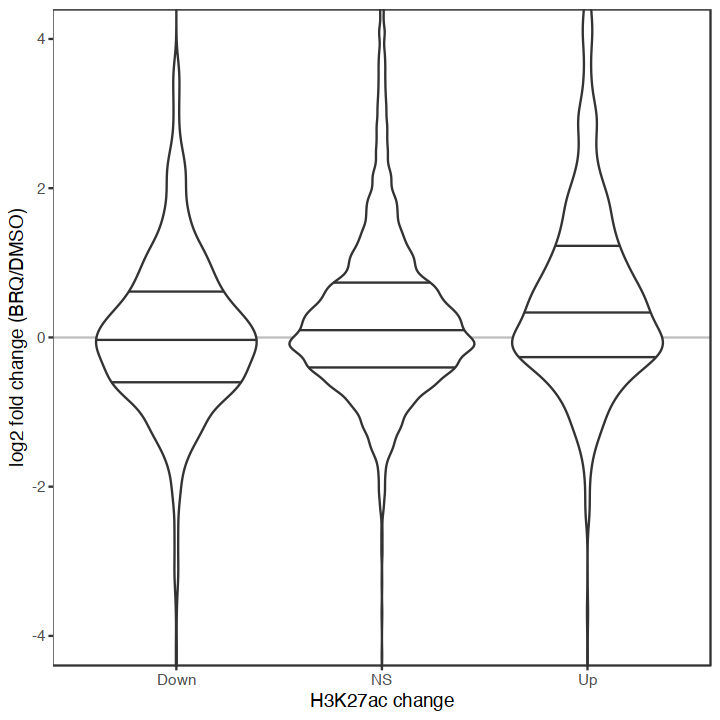

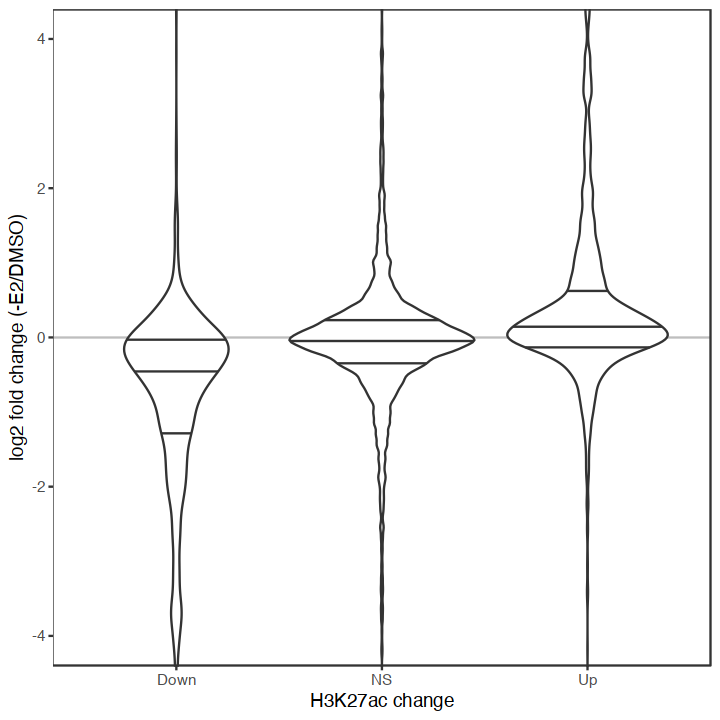

In [66]:
# logFC.x is peak change, logFC.y is gene exp change

k27_b24_enh$k27_status = "NS"
k27_b24_enh[(k27_b24_enh$logFC.x > 1 & k27_b24_enh$adj.P.Val.x < 0.05),]$k27_status = "Up"
k27_b24_enh[(k27_b24_enh$logFC.x < -1 & k27_b24_enh$adj.P.Val.x < 0.05),]$k27_status = "Down"

k27_e24_enh$k27_status = "NS"
k27_e24_enh[(k27_e24_enh$logFC.x > 1 & k27_e24_enh$adj.P.Val.x < 0.05),]$k27_status = "Up"
k27_e24_enh[(k27_e24_enh$logFC.x < -1 & k27_e24_enh$adj.P.Val.x < 0.05),]$k27_status = "Down"

options(repr.plot.width=6, repr.plot.height=6)
g1 = ggplot(k27_b24_enh, aes(x=k27_status, y=logFC.y)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-4,4)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("H3K27ac change") + ylab("log2 fold change (BRQ/DMSO)") 

g2 = ggplot(k27_e24_enh, aes(x=k27_status, y=logFC.y)) + 
geom_hline(yintercept=0, color="gray")+
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-4,4)) + theme_bw() +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) +
xlab("H3K27ac change") + ylab("log2 fold change (-E2/DMSO)") 

g1
ggsave("../output/230920_bd302_erhoxa9_brq_k27ac_enh_rna.pdf", width=2, height=2.5)

g2
ggsave("../output/230920_bd302_erhoxa9_e2_k27ac_enh_rna.pdf", width=2, height=2.5)

In [82]:
# Mann-Whitney tests (enhancers)
wilcox.test(subset(k27_b24_enh, k27_status == "NS")$logFC.y, subset(k27_b24_enh, k27_status == "Up")$logFC.y)
wilcox.test(subset(k27_b24_enh, k27_status == "NS")$logFC.y, subset(k27_b24_enh, k27_status == "Down")$logFC.y)
wilcox.test(subset(k27_e24_enh, k27_status == "NS")$logFC.y, subset(k27_e24_enh, k27_status == "Up")$logFC.y)
wilcox.test(subset(k27_e24_enh, k27_status == "NS")$logFC.y, subset(k27_e24_enh, k27_status == "Down")$logFC.y)


	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_enh, k27_status == "NS")$logFC.y and subset(k27_b24_enh, k27_status == "Up")$logFC.y
W = 50493077, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_b24_enh, k27_status == "NS")$logFC.y and subset(k27_b24_enh, k27_status == "Down")$logFC.y
W = 20969219, p-value = 1.365e-07
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_e24_enh, k27_status == "NS")$logFC.y and subset(k27_e24_enh, k27_status == "Up")$logFC.y
W = 43518329, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  subset(k27_e24_enh, k27_status == "NS")$logFC.y and subset(k27_e24_enh, k27_status == "Down")$logFC.y
W = 55083534, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [118]:
# what was the baseline ATAC for all enhancers associated with up and down genes?
# it's the same for genes up in BRQ and -E2 [maybe a tad higher in BRQ]
  
median(atac_peak_cts_by_length[subset(k27_b24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 1366 genes up
median(atac_peak_cts_by_length[subset(k27_b24_enh, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])   # 749 genes down

median(atac_peak_cts_by_length[subset(k27_e24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 386 genes up
median(atac_peak_cts_by_length[subset(k27_e24_enh, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])  # 517 genes down

# at promoters?
# it's the same for genes up in BRQ and -E2 [maybe a tad higher in BRQ]

median(atac_peak_cts_by_length[subset(k27_b24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 1366 genes up
median(atac_peak_cts_by_length[subset(k27_b24_dep_tss, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])   # 749 genes down

median(atac_peak_cts_by_length[subset(k27_e24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 386 genes up
median(atac_peak_cts_by_length[subset(k27_e24_dep_tss, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])  # 517 genes down

[1] 0.07275184

[1] 0.06974428

[1] 0.06741573

[1] 0.07784036

[1] 0.1525641

[1] 0.300161

[1] 0.1336735

[1] 0.1723982

In [67]:
bup = rownames(subset(brq_degs[["24"]], logFC > 1 & adj.P.Val < 0.05))
eup = rownames(subset(e2w_degs[["24"]], logFC < 0.2))
intersect(bup, eup)

[1] "Cd33"           "Nwd1"           "Itsn1"          "Tsc22d1"       
  [5] "Acot1"          "Gsn"            "Tmem71"         "Lamb2"         
  [9] "Pld4"           "Ptafr"          "Gm2a"           "St6gal1"       
 [13] "Fbp1"           "Siae"           "Tmem176a"       "Scml4"         
 [17] "Gfra1"          "Uba7"           "Itgb5"          "Thbd"          
 [21] "Stx2"           "Cd93"           "Calcoco1"       "Chd3"          
 [25] "Tns1"           "Aplp2"          "Plin3"          "Neurl3"        
 [29] "Abcb4"          "Cyth4"          "Trp53inp1"      "Cyth3"         
 [33] "Mxd4"           "Capn5"          "H2-Ob"          "Cds1"          
 [37] "Arhgap9"        "Gnb4"           "Tspyl3"         "St3gal2"       
 [41] "Thy1"           "Ccng2"          "Gnpda1"         "Slc4a8"        
 [45] "Slc9a9"         "Inhbb"          "Tifab"          "Colq"          
 [49] "Ube2h"          "Nipal3"         "Sesn3"          "Padi2"         
 [53] "Jup"            "Itgax"          "Tspan13"        "Trpv4"         
 [57] "Aldh1b1"        "Kcnip3"         "Shisa2"         "Mfge8"         
 [61] "Arhgap6"        "Gng2"           "Fut7"           "Abcg1"         
 [65] "Hif3a"          "Cd79a"          "Stxbp1"         "Wipf1"         
 [69] "Sesn1"          "Armc9"          "Hspa1b"         "Olfm1"         
 [73] "Adck3"          "Rab11fip5"      "A930003A15Rik"  "Lpar1"         
 [77] "Tnfsf12"        "Abcb1b"         "Phactr1"        "Irf8"          
 [81] "1700025G04Rik"  "Ndrg3"          "Hexim1"         "Nynrin"        
 [85] "Eef2k"          "Rassf4"         "Il6ra"          "Mr1"           
 [89] "Ak1"            "Smim14"         "Ank"            "Dennd5a"       
 [93] "Ahnak"          "Mast4"          "Zfp658"         "Camk1"         
 [97] "Arl4c"          "Wdfy2"          "Zfyve1"         "Cdkn2c"        
[101] "Lat2"           "Abcc3"          "F13a1"          "Abcc5"         
[105] "Dlg4"           "Gcnt2"          "Fam168a"        "Pafah2"        
[109] "Hip1"           "Acy3"           "Atp13a2"        "Fyb"           
[113] "Abcb1a"         "Wdr19"          "Erg"            "Fam49a"        
[117] "Ccl3"           "Cela1"          "Zfp385a"        "Ttc3"          
[121] "Ndrg1"          "Lasp1"          "Pcyt1b"         "Cyp4f18"       
[125] "Tinagl1"        "St5"            "Eltd1"          "Ptk7"          
[129] "Rfx5"           "Cd180"          "Lima1"          "Slc2a9"        
[133] "Csgalnact1"     "Tmem176b"       "Abca3"          "Ip6k1"         
[137] "Gas6"           "Capg"           "Wdr35"          "Chst1"         
[141] "Prex1"          "Klhl24"         "Cd1d1"          "Trappc9"       
[145] "Prmt2"          "Cnp"            "Samhd1"         "Slc25a23"      
[149] "Sept1"          "Epb4.1l5"       "Kif17"          "9330175E14Rik" 
[153] "Gsdmd"          "Col4a2"         "Suox"           "Glul"          
[157] "Ifi27"          "Pde7b"          "C1qtnf6"        "Mkl2"          
[161] "Tnfsf12Tnfsf13" "Pink1"          "S1pr1"          "Aldh4a1"       
[165] "Adora2a"        "Ptpn6"          "Nusap1"         "Mpl"           
[169] "Acadvl"         "4933426M11Rik"  "Capn2"          "Asah2"         
[173] "Cog6"           "Klra1"          "Ivd"            "Sft2d2"        
[177] "Spata6"         "H2-DMb1"        "Tapbp"          "Dyrk1b"        
[181] "Pgpep1"         "Ninj1"          "Arhgap18"       "St3gal5"       
[185] "Ttc28"          "Ift140"         "Fam198b"        "Plek"          
[189] "Evi2a"          "Ttll1"          "Cyp2d22"        "Col4a5"        
[193] "Stard8"         "Vpreb3"         "Pik3ip1"        "Dstyk"         
[197] "Scin"           "Trpa1"          "Abhd4"          "Rgs12"         
[201] "Il6st"          "Cnpy4"          "Camk1d"         "Camk2b"        
[205] "Plekhb2"        "Mef2c"          "Plekhg5"        "Plekha2"       
[209] "Trip4"          "Tmem29"         "Aplf"           "Klhl18"        
[213] "Myl4"           "Haao"           "Tgfbr2"         "Specc1"        
[217] 

In [68]:
bup = rownames(subset(brq_degs[["24"]], logFC < 0.2))
eup = rownames(subset(e2w_degs[["24"]], logFC > 1 & adj.P.Val < 0.05))
intersect(bup, eup)

[1] "Anxa3"         "Tenm4"         "9430038I01Rik" "Lcn2"         
 [5] "Tmem216"       "Hiatl1"        "BC021614"      "Celsr3"       
 [9] "Fam49b"        "Ms4a2"         "Vegfa"         "Gm10872"      
[13] "Ppapdc1b"      "Rgcc"          "Asb5"          "Rnf128"       
[17] "Spatc1"        "Myl12b"        "Pnkp"          "Xbp1"         
[21] "Lgals3"        "Bambi-ps1"     "Slc24a3"       "Bnip3l"       
[25] "Gm5127"        "Hsd17b1"       "Ddx26b"        "Calr"         
[29] "Med21"         "Myoz1"         "5730508B09Rik" "Mboat1"       
[33] "Mcu"           "Mlx"           "Diap2"         "Ms4a3"        
[37] "Polm"          "Ncam1"         "Sim2"          "Cyba"         
[41] "Plod3"         "Col4a1"        "Dnmt3l"        "Gm12854"      
[45] "Svip"          "Prtn3"         "Nin"           "Mapk13"       
[49] "Chn2"          "Ezr"           "Adamts7"       "Suco"         
[53] "Mir702"        "Dio2"          "Cep85l"        "Tbc1d2b"      
[57] "Phf11c"        "Cnr2"          "Mir223"        "Gm10480"      
[61] "Gm14519"       "Col5a1"        "Mir7050"       "Gm16587"      
[65] "Glis3"         "Plac8"         "Cftr"          "A830012C17Rik"
[69] "Clec4b2"       "Ighv1-69"      "Dsg2"          "Tusc1"        
[73] "Gm21370"       "Ikzf3"         "Ear2"          "Epx"          
[77] "I830127L07Rik" "Acta2"         "H2afy2"        "Agps"

In [120]:
# median change in enhancer and promoter H3K27ac? it tends to be much lower for BRQ compared to -E2 

median(subset(k27_b24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$logFC.x)  # 1366 genes up
median(subset(k27_e24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$logFC.x)  # 749 genes down

median(subset(k27_b24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05)$logFC.x)  # 1366 genes up
median(subset(k27_e24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05)$logFC.x)  # 749 genes down

[1] 0.1505256

[1] 0.3187899

[1] 0.04836608

[1] 0.3195172

In [119]:
# what if we only look at enhancers that are also upregulated? they tend to have increased ATAC as well.
  
median(atac_peak_cts_by_length[subset(k27_b24_enh, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                   logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 1366 genes up

median(atac_peak_cts_by_length[subset(k27_e24_enh, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                   logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 386 genes up

# what if we only look at promoters that also have increased accessibility? they tend to have slightly increased baseline ATAC.
  
median(atac_peak_cts_by_length[subset(k27_b24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                       logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 1366 genes up

median(atac_peak_cts_by_length[subset(k27_e24_dep_tss, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                       logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 386 genes up


[1] 0.04308041

[1] 0.02658452

[1] 0.06642097

[1] 0.04914253

In [99]:
# H3K4me1 remains the same 
median(k4me1_peak_cts_by_length[subset(k27_b24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 1366 genes up
median(k4me1_peak_cts_by_length[subset(k27_b24_enh, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])   # 749 genes down

median(k4me1_peak_cts_by_length[subset(k27_e24_enh, logFC.y > 1 & adj.P.Val.y < 0.05)$Row.names])  # 386 genes up
median(k4me1_peak_cts_by_length[subset(k27_e24_enh, logFC.y < -1 & adj.P.Val.y < 0.05)$Row.names])  # 517 genes down


median(k4me1_peak_cts_by_length[subset(k27_b24_enh, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                   logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 1366 genes up

median(k4me1_peak_cts_by_length[subset(k27_e24_enh, logFC.y > 1 & adj.P.Val.y < 0.05 & 
                                                   logFC.x > 1 & adj.P.Val.x < 0.05)$Row.names])  # 386 genes up


[1] 0.09090909

[1] 0.05555556

[1] 0.1043956

[1] 0.08059155

[1] 0.09606792

[1] 0.09278597

In [191]:
# look specifically at genes that go up in E2 also?

with(subset(k27_b24_dep_tss_rnasig, gene %in% shared_upreg24), cor.test(logFC.y, logFC.x))
with(subset(k27_b24_dep_tss_k27sig, gene %in% shared_upreg24), cor.test(logFC.y, logFC.x))

# options(repr.plot.width=12, repr.plot.height=6)
# g1 + g2


	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 5.3946, df = 641, p-value = 9.671e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1332242 0.2811862
sample estimates:
      cor 
0.2083973 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 3.3201, df = 158, p-value = 0.001118
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1043501 0.3948861
sample estimates:
      cor 
0.2553741 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 12.781, df = 2058, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2306838 0.3107189
sample estimates:
    cor 
0.27117 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 15.716, df = 2459, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2657886 0.3376098
sample estimates:
      cor 
0.3021279 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


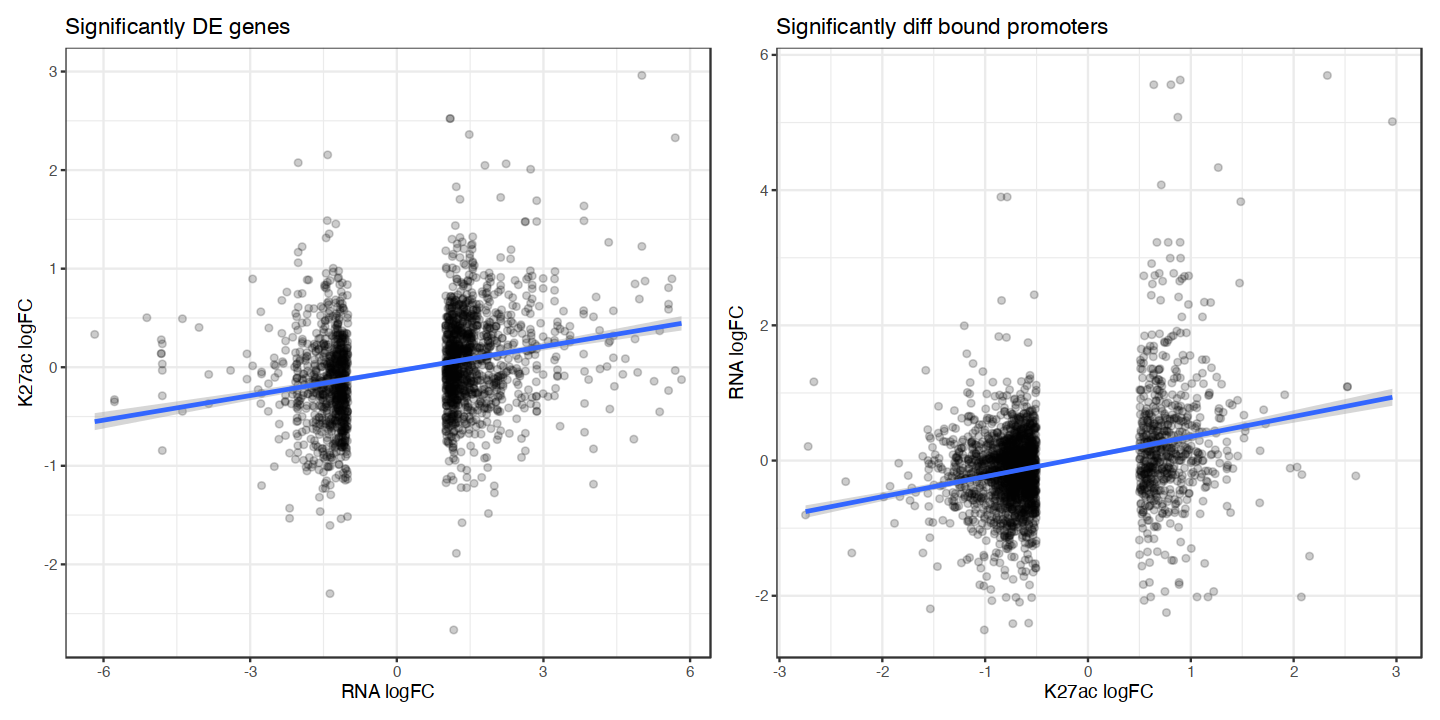

In [63]:
# b8
k27_b8_dep_tss = merge(k27_b8_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_b8_dep_tss = merge(k27_b8_dep_tss, brq_degs[["8"]], by.x="SYMBOL", by.y=0)

k27_b8_dep_tss_rnasig = subset(k27_b8_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_b8_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_b8_dep_tss_k27sig = subset(k27_b8_dep_tss, abs(logFC.x) > 0.5 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_b8_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_b8_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_b8_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2


	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 15.173, df = 1153, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3587209 0.4549377
sample estimates:
      cor 
0.4079614 



	Pearson's product-moment correlation

data:  logFC.y and logFC.x
t = 13.68, df = 263, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5684609 0.7101170
sample estimates:
     cor 
0.644792 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


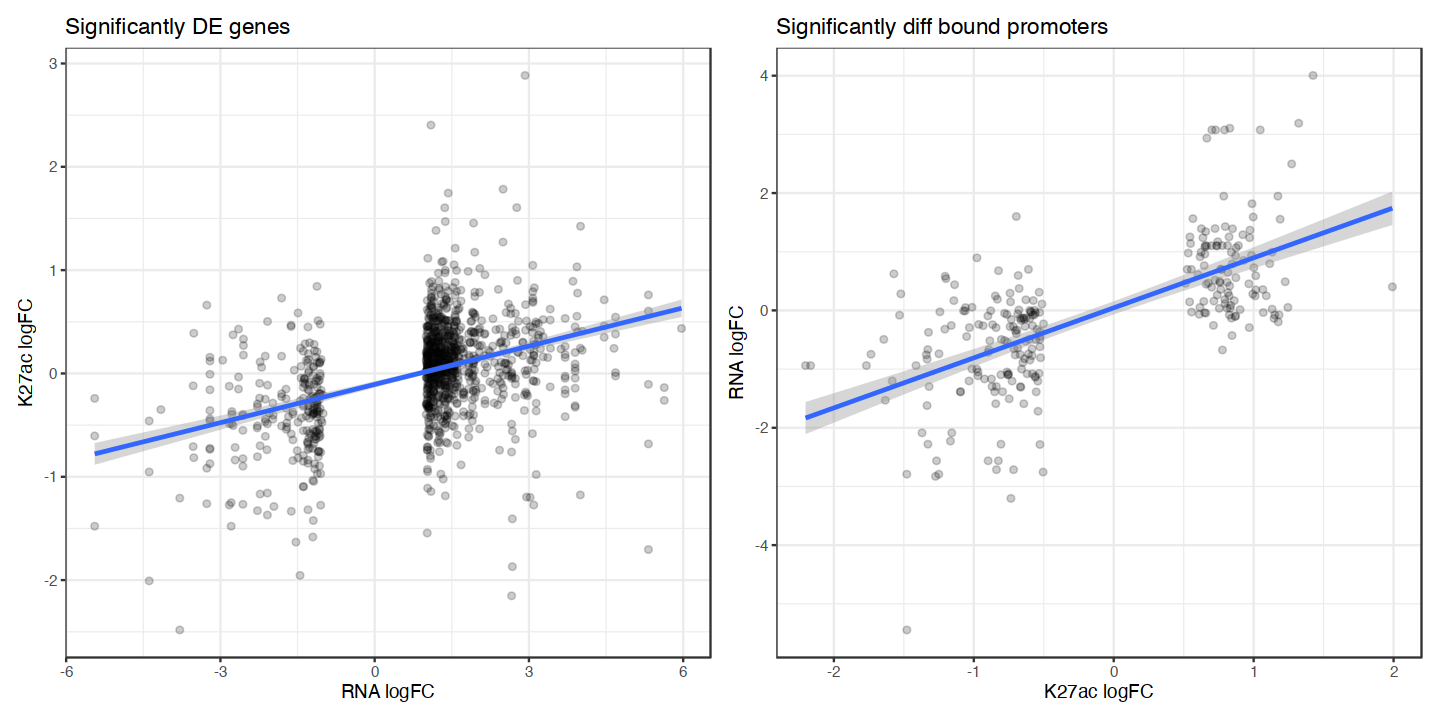

In [65]:
# e8
k27_e8_dep_tss = merge(k27_e8_dep[tss_peaks,], tss_peaks_df[,c("peak_id", "SYMBOL")], by.x=0, by.y="peak_id")
k27_e8_dep_tss = merge(k27_e8_dep_tss, e2w_degs[["8"]], by.x="SYMBOL", by.y=0)

k27_e8_dep_tss_rnasig = subset(k27_e8_dep_tss, abs(logFC.y) > 1 & adj.P.Val.y < 0.05)
g1 = ggplot(k27_e8_dep_tss_rnasig, aes(x=logFC.y, y=logFC.x)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("RNA logFC") + ylab("K27ac logFC") + ggtitle("Significantly DE genes")

k27_e8_dep_tss_k27sig = subset(k27_e8_dep_tss, abs(logFC.x) > 0.5 & adj.P.Val.x < 0.05)
g2 = ggplot(k27_e8_dep_tss_k27sig, aes(x=logFC.x, y=logFC.y)) + geom_point(alpha=0.2) + 
geom_smooth(method="lm") + theme_bw() + xlab("K27ac logFC") + ylab("RNA logFC") + ggtitle("Significantly diff bound promoters")

with(k27_e8_dep_tss_rnasig, cor.test(logFC.y, logFC.x))
with(k27_e8_dep_tss_k27sig, cor.test(logFC.y, logFC.x))

options(repr.plot.width=12, repr.plot.height=6)
g1 + g2

## Pol 2 CUT&RUN

In [69]:
x <- org.Mm.egSYMBOL
mapped_genes <- mappedkeys(x)
geneid_to_symbol <- as.list(x[mapped_genes])

gene_ranges = as.data.frame(genes(txdb))
gene_ranges$symbol = as.character(sapply(gene_ranges$gene_id, function(x) geneid_to_symbol[[x]]))

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [70]:
write_bed = function(gene_list, ranges, fn) {
    df = subset(ranges, symbol %in% gene_list)
    write.table(df[,c("seqnames", "start", "end", "symbol", "gene_id", "strand")], 
                fn, quote=F, sep='\t', row.names=F, col.names=F)    
}

In [71]:
# data frames for different subsets
b24 = subset(brq_degs[["24"]], logFC > 1 & adj.P.Val < 0.05)
b48 = subset(brq_degs[["48"]], logFC > 1 & adj.P.Val < 0.05)
e24 = subset(e2w_degs[["24"]], logFC > 1 & adj.P.Val < 0.05)
e96 = subset(e2w_degs[["96"]], logFC > 1 & adj.P.Val < 0.05)
e24d = subset(e2w_degs[["24"]], logFC < -1 & adj.P.Val < 0.05)
b24d = subset(brq_degs[["24"]], logFC < -1 & adj.P.Val < 0.05)

In [168]:
# BED files for different gene subsets
write_bed(intersect(rownames(b24), rownames(e96)),
          gene_ranges, "../output/230907_pol2/230907_b24u_and_e96u.bed")
write_bed(intersect(rownames(b24), rownames(e24)), 
          gene_ranges, "../output/230907_pol2/230907_b24u_and_e24u.bed")
write_bed(setdiff(intersect(rownames(b24), rownames(e96)),
                  intersect(rownames(b24), rownames(e24))),
          gene_ranges, "../output/230907_pol2/230907_b24u_and_e96u_not_e24u.bed")
write_bed(setdiff(rownames(b24), rownames(e96)),
          gene_ranges, "../output/230907_pol2/230907_b24u_not_e96u.bed")
write_bed(setdiff(rownames(b24), rownames(e24)),
          gene_ranges, "../output/230907_pol2/230907_b24u_not_e24u.bed")

write_bed(rownames(b24), 
          gene_ranges, "../output/230907_pol2/230907_b24u.bed")
write_bed(rownames(e24),
          gene_ranges, "../output/230907_pol2/230907_e24u.bed")

write_bed(rownames(b24d), 
          gene_ranges, "../output/230907_pol2/230907_b24d.bed")
write_bed(rownames(e24d),
          gene_ranges, "../output/230907_pol2/230907_e24d.bed")

write_bed(setdiff(rownames(e24), rownames(b48)),
          gene_ranges, "../output/230907_pol2/230907_e24u_not_b48u.bed")
write_bed(setdiff(rownames(e24), rownames(b24)),
          gene_ranges, "../output/230907_pol2/230907_e24u_not_b24u.bed")

write_bed(setdiff(rownames(e24d), rownames(b24d)),
          gene_ranges, "../output/230907_pol2/230907_e24d_not_b24d.bed")
write_bed(setdiff(rownames(b24d), rownames(e24d)),
          gene_ranges, "../output/230907_pol2/230907_b24d_not_e24d.bed")
write_bed(intersect(rownames(b24d), rownames(e24d)),
          gene_ranges, "../output/230907_pol2/230907_b24d_and_e24d.bed")

write_bed(sample(rownames(brq_degs[["24"]]), 3000), 
          gene_ranges, "../output/230907_pol2/230907_random.bed")

write_bed(rownames(brq_degs[["24"]]), gene_ranges, "../output/230907_pol2/230907_all.bed")

In [285]:
# get gene bodies only
gene_list = rownames(brq_degs[["24"]])
df = subset(gene_ranges, symbol %in% gene_list)
tbl = df[,c("seqnames", "start", "end", "symbol", "gene_id", "strand")]
tbl[tbl$strand == "+",]$start = tbl[tbl$strand == "+",]$start + 250  # add 250 to start for positive strand genes
tbl[tbl$strand == "-",]$end = tbl[tbl$strand == "-",]$end - 250  # subtract 250 from end for negative strand genes

tbl = subset(tbl, start < end)

write.table(tbl, "../output/230907_pol2/230907_all_genebodies.bed", quote=F, sep='\t', row.names=F, col.names=F)   
write.table(tbl[,c(4,1,2,3,6)], "../output/230907_pol2/230907_all_genebodies.saf", quote=F, sep='\t', row.names=F, col.names=F)   

In [72]:
# featureCounts -T 10 -p -O -M --fraction -F SAF -a \
# 230907_all_genebodies.saf -o 230920_bd302_pol2_at_genebodies.txt \
# /home/briando/data/files/220211VanA/mm10/results/bowtie2_bam/ERHoxa9_PolIIS2_DMSO_24h_aligned_sorted_rmdup_noblacklist.bam \
# /home/briando/data/files/220211VanA/mm10/results/bowtie2_bam/ERHoxa9_PolIIS2_BRQ_1uM_24h_aligned_sorted_rmdup_noblacklist.bam \
# /home/briando/data/files/220211VanA/mm10/results/bowtie2_bam/ERHoxa9_PolIIS2_E2wd_24h_aligned_sorted_rmdup_noblacklist.bam \
# /home/briando/data/files/211201Van/results/bowtie2_bam/IgG_dsDNA_Mixed_aligned_sorted_rmdup.bam

# read featureCounts file

pol2_data = read.table("../output/230907_pol2//230920_bd302_pol2_at_genebodies.txt", header=T, row.names=1)
colnames(pol2_data) = c(colnames(pol2_data)[1:5], "dmso", "brq", "e2wd", "igg")
head(pol2_data)

Chr   Start     End       Strand Length dmso brq  e2wd   igg
Ldlrap1  chr4  134741554 134767774 -       26221 1054 1350  794.0 138
Mdn1     chr4   32657369  32775217 +      117849 2676 1696 1141.0 352
Wfdc17   chr11  83704241  83706268 +        2028   22    7    8.0   8
Mfap1b   chr2  121460235 121473817 -       13583  319  241  190.0  47
Tmsb15b2 chrX  136955265 136957775 -        2511   11   10   13.5   3
Gm15772  chr11  68901860  68906989 +        5130  249  210   96.5  18

In [73]:
pol2_summ = read.table("../output/230907_pol2//230920_bd302_pol2_at_genebodies.txt.summary", header=T, row.names=1)
pol2_summ_sums = as.numeric(apply(pol2_summ,2,sum))
pol2_summ_sums

[1] 22388729 19281500 13670784  8268370

In [74]:
# try it with and without normalizing
# need to normalize... either to sum or to mapped reads (in summary file)
# IgG is pretty useless here, it's not really a "condition"

# normalizing to mapped reads from summary file works better than only reads mapping to gene bodies

pol2_data_norm = pol2_data
#pol2_data_norm[,6:9] = sweep(pol2_data_norm[,6:9], 2, apply(pol2_data[,6:9],2,sum), `/`)*1e6  # normalizing to gene body read sum
pol2_data_norm[,6:9] = sweep(pol2_data_norm[,6:9], 2, pol2_summ_sums, `/`)*1e6  # normalizing to mapped read sum

In [75]:
# labeling genes as upreg or downreg

pol2_data_norm$brq_status = "NS"
pol2_data_norm[rownames(b24),]$brq_status = "Up"
pol2_data_norm[rownames(b24d),]$brq_status = "Down"

pol2_data_norm$e2_status = "NS"
pol2_data_norm[rownames(e24),]$e2_status = "Up"
pol2_data_norm[rownames(e24d),]$e2_status = "Down"

In [76]:
# Mann-Whitney test

pol2_bn = with(subset(pol2_data_norm, brq_status == "NS"), log2(brq/dmso))
pol2_bu = with(subset(pol2_data_norm, brq_status == "Up"), log2(brq/dmso))
pol2_bd = with(subset(pol2_data_norm, brq_status == "Down"), log2(brq/dmso))

pol2_en = with(subset(pol2_data_norm, e2_status == "NS"), log2(e2wd/dmso))
pol2_eu = with(subset(pol2_data_norm, e2_status == "Up"), log2(e2wd/dmso))
pol2_ed = with(subset(pol2_data_norm, e2_status == "Down"), log2(e2wd/dmso))

wilcox.test(pol2_bn, pol2_bu)
wilcox.test(pol2_bn, pol2_bd)
wilcox.test(pol2_en, pol2_eu)
wilcox.test(pol2_en, pol2_ed)


	Wilcoxon rank sum test with continuity correction

data:  pol2_bn and pol2_bu
W = 5370660, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  pol2_bn and pol2_bd
W = 5561056, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  pol2_en and pol2_eu
W = 857554, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  pol2_en and pol2_ed
W = 3724418, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Warning message:
“Removed 607 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 607 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 607 rows containing non-finite values (`stat_ydensity()`).”


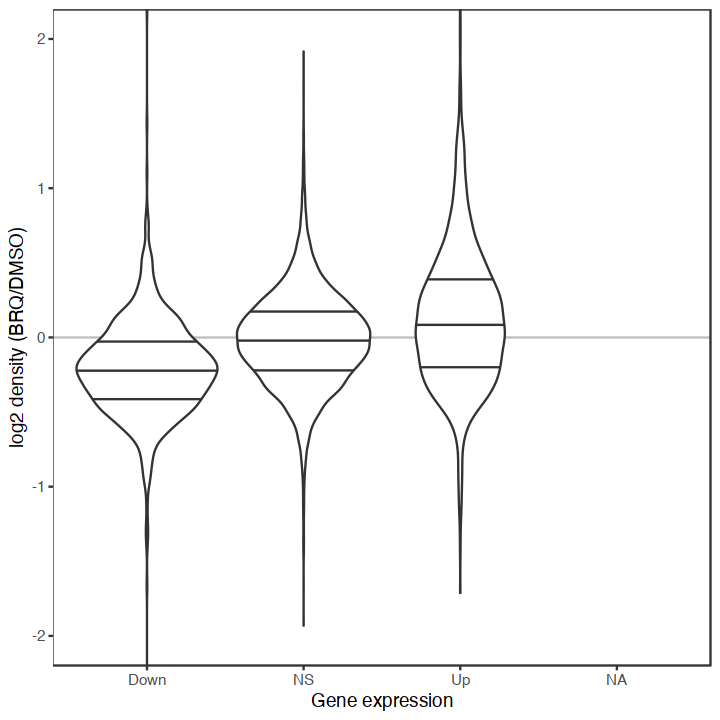

Warning message:
“Removed 607 rows containing non-finite values (`stat_ydensity()`).”


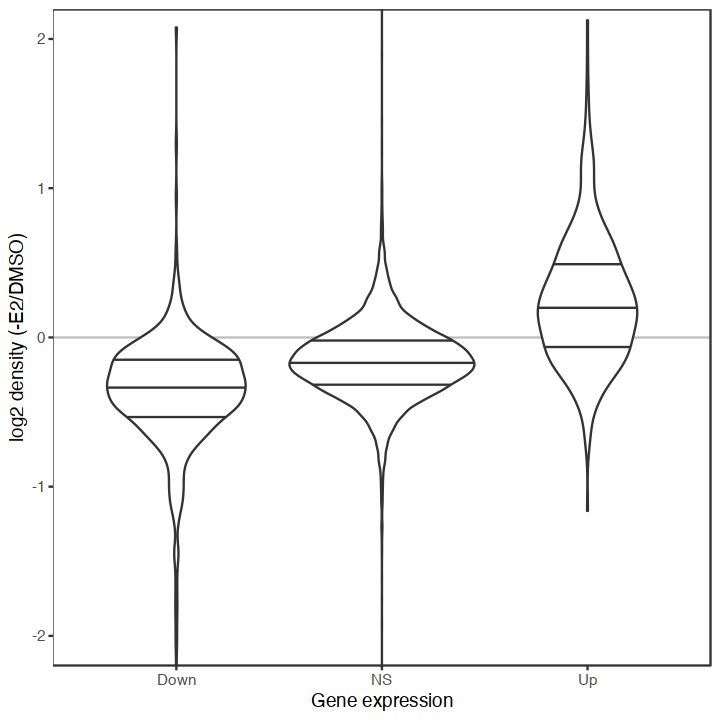

In [77]:
# plots 

g1 = ggplot(pol2_data_norm, aes(x=brq_status, y=log2(brq/dmso))) + 
geom_hline(yintercept=0, color="gray")+
#geom_boxplot(outlier.shape = NA) + 
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-2,2)) + theme_bw() +
xlab("Gene expression") + ylab("log2 density (BRQ/DMSO)") +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

g2 = ggplot(pol2_data_norm, aes(x=e2_status, y=log2(e2wd/dmso))) + 
geom_hline(yintercept=0, color="gray")+
#geom_boxplot(outlier.shape = NA) +   # for boxplot use -1.5,1.5 ylim
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-2,2)) + theme_bw() +
xlab("Gene expression") + ylab("log2 density (-E2/DMSO)") +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

g1
ggsave("../output/230920_bd302_erhoxa9_brq_pol2_genebody_density.pdf", width=2, height=2.5)

g2
ggsave("../output/230920_bd302_erhoxa9_e2_pol2_genebody_density.pdf", width=2, height=2.5)

## Changes in K27ac/ATAC at associated peaks of genes

[1] 9324    2

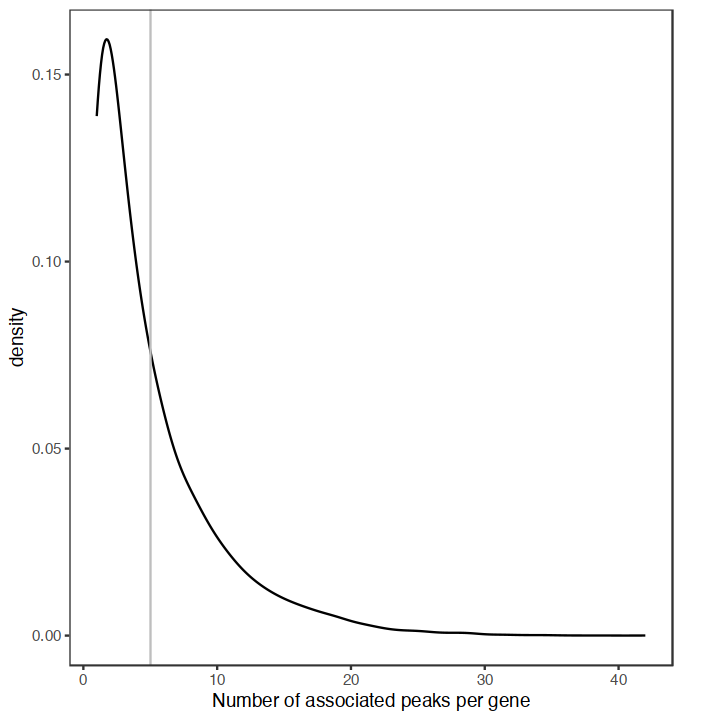

In [78]:
# number of regions per gene
counts = great_data %>% count(gene)
rownames(counts) = counts$gene
ggplot(counts, aes(x=n)) + geom_density(adjust=2) +
geom_vline(xintercept=5, color="gray") + xlab("Number of associated peaks per gene") +
           theme_bw() + theme(panel.grid.major = element_blank(), 
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0.2,1,0.2,0.2), "cm"))
#ggsave("../output/220221_num_peaks.pdf", width=3, height=2.5) 

# high complexity genes -- top tertile
z = as.numeric(quantile(counts$n, 0.666))
z = 3
counts_high = subset(counts, n >= z)
dim(counts_high)

[1] 12032     2

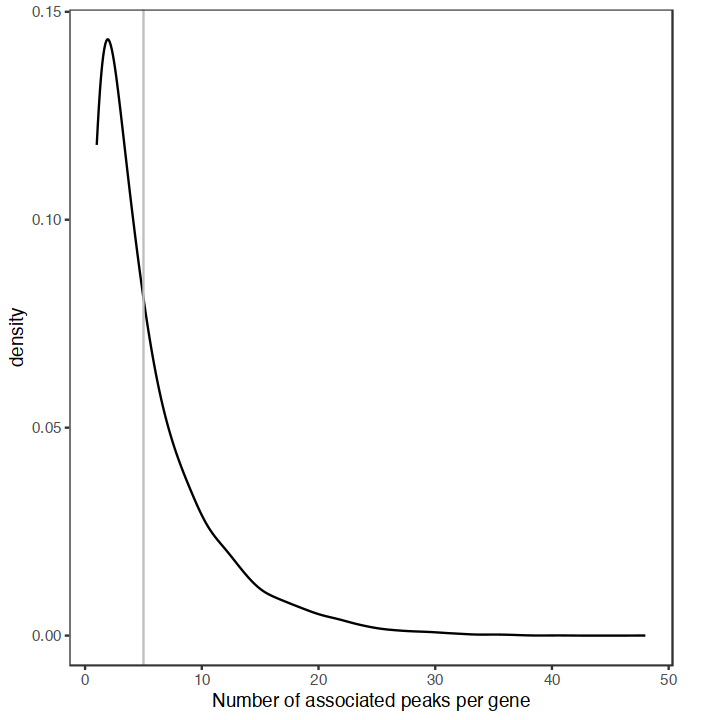

In [79]:
# number of regions per gene
counts = great_data_with_tss %>% count(gene)
rownames(counts) = counts$gene
ggplot(counts, aes(x=n)) + geom_density(adjust=2) +
geom_vline(xintercept=5, color="gray") + xlab("Number of associated peaks per gene") +
           theme_bw() + theme(panel.grid.major = element_blank(), 
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0.2,1,0.2,0.2), "cm"))
#ggsave("../output/220221_num_peaks.pdf", width=3, height=2.5) 

# high complexity genes -- top tertile
#z = as.numeric(quantile(counts$n, 0.666))
z = 3
counts_high_with_tss = subset(counts, n >= z)
dim(counts_high_with_tss)

In [80]:
# number of shared upreg genes (out of 327) with at least *three* ATAC-seq peaks
# (including or not including TSS) within 100kb

sum(shared_upreg24 %in% counts_high$gene)   # 206
sum(shared_upreg24 %in% counts_high_with_tss$gene)   # 246

[1] 206

[1] 246

In [81]:
# genes that don't have at least 3 atac-seq peaks nearby often are really close to other genes
# and have only one TSS peak 
shared_upreg24[which(!(shared_upreg24 %in% counts_high_with_tss$gene))]

[1] "Tcn2"          "Hsd3b7"        "4632428N05Rik" "5430435G22Rik"
 [5] "Cracr2b"       "Naip5"         "Flot2"         "BE692007"     
 [9] "Emr1"          "2310001H17Rik" "Tlr6"          "Cd68"         
[13] "Gm29233"       "Trim12a"       "AB124611"      "Grina"        
[17] "Ighm"          "Epb4.1l1"      "Mir7007"       "Mrgpra2b"     
[21] "Ebi3"          "Cldn15"        "1600010M07Rik" "Gm8995"       
[25] "Isoc2b"        "Mir7678"       "Mir7676-1"     "Fam135b"      
[29] "Gm29284"       "Gm17017"       "5730460C07Rik" "Dnajc12"      
[33] "Gm16028"       "Gm26885"       "Prss57"        "Scnn1a"       
[37] "9330159M07Rik" "Gm14005"       "Gm20412"       "Gm15915"      
[41] "Gm16192"       "Gm29205"       "Slc27a4"       "Gm26626"      
[45] "RP23-346I1.1"  "Dmkn"          "Ptprt"         "1700020L24Rik"
[49] "E230016M11Rik" "Serpinb10"     "n-R5s185"      "4930469K13Rik"
[53] "Casp4"         "Mir7676-2"     "Adhfe1"        "B430010I23Rik"
[57] "Cpq"           "Tmc7"          "B230208H11Rik" "Gm10553"      
[61] "Gm26512"       "Emr4"          "Gm2427"        "Fstl3"        
[65] "Ighv1-41"      "Gm28913"       "F730016J06Rik" "Naip3"        
[69] "Clec7a"        "F630028O10Rik" "Ctse"          "D930048N14Rik"
[73] "Gm7694"        "Gm1966"        "Gm16316"       "Gm16026"      
[77] "Gm16092"       "Dbndd2"        "Ccno"          "Lrg1"         
[81] "F830208F22Rik"

In [82]:
# peaks that are in both the GREAT data and the differential analysis
z = intersect(rownames(old_b24_dep), rownames(great_data))

# fraction of peaks that become more accessible in B24 and E24
b24_dep_great = cbind(old_b24_dep[z, ], great_data[z, ])
b24_frac_up = b24_dep_great %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > 0) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
b24_frac_up$lfc = brq_degs[["24"]][b24_frac_up$gene, ]$logFC
rownames(b24_frac_up) = b24_frac_up$gene

e24_dep_great = cbind(old_e24_dep[z, ], great_data[z, ])
e24_frac_up = e24_dep_great %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > 0) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
e24_frac_up$lfc = e2w_degs[["24"]][e24_frac_up$gene, ]$logFC
rownames(e24_frac_up) = e24_frac_up$gene


# peaks that are in both the GREAT data (TSS) and the differential analysis
z = intersect(rownames(old_b24_dep), rownames(great_data_with_tss))

# fraction of peaks that become more accessible in B24 and E24
tb24_dep_great = cbind(old_b24_dep[z, ], great_data_with_tss[z, ])
tb24_frac_up = tb24_dep_great %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > 0) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
rownames(tb24_frac_up) = tb24_frac_up$gene

te24_dep_great = cbind(old_e24_dep[z, ], great_data_with_tss[z, ])
te24_frac_up = te24_dep_great %>% group_by(gene) %>% 
        summarize(Frac = sum((logFC > 0) & (adj.P.Val < 0.05))/
                        sum((adj.P.Val <= 1)))
rownames(te24_frac_up) = te24_frac_up$gene

# merging data frame
frac_24h = cbind(b24_frac_up[shared_upreg24,c("Frac", "lfc")],
                 e24_frac_up[shared_upreg24,c("Frac", "lfc")],
                 tb24_frac_up[shared_upreg24, "Frac"],
                 te24_frac_up[shared_upreg24, "Frac"])
rownames(frac_24h) = shared_upreg24
colnames(frac_24h) = c("b24_frac", "b24_lfc", "e24_frac", "e24_lfc", "b24_frac_wtss", "e24_frac_wtss")

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


In [83]:
head(frac_24h)

b24_frac b24_lfc  e24_frac  e24_lfc  b24_frac_wtss e24_frac_wtss
Pcyt1a  0        2.423862 0.0000000 1.003986 0             0.0000000    
Itgb3   0        3.493352 0.1111111 1.582481 0             0.1333333    
Cd300lb 0        3.968141 0.4444444 1.834323 0             0.3636364    
Alas1   0        2.359709 1.0000000 2.591455 0             0.8333333    
Stom    0        1.715342 0.4444444 1.312006 0             0.4000000    
Itgb7   0        4.584720 0.0000000 1.335796 0             0.0000000

In [84]:
# out of 327 genes that are shared upregulated, 257 overlap with great_data and
# 275 overlap with great_data_with_tss
sum(shared_upreg24 %in% unique(great_data_with_tss$gene))

[1] 275

Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 70 rows containing non-finite values (`stat_density()`).”



	Wilcoxon rank sum test with continuity correction

data:  b24_frac and e24_frac
W = 15836, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] NA

[1] NA


	Wilcoxon rank sum test with continuity correction

data:  b24_lfc and e24_lfc
W = 40671, p-value = 5.589e-06
alternative hypothesis: true location shift is not equal to 0


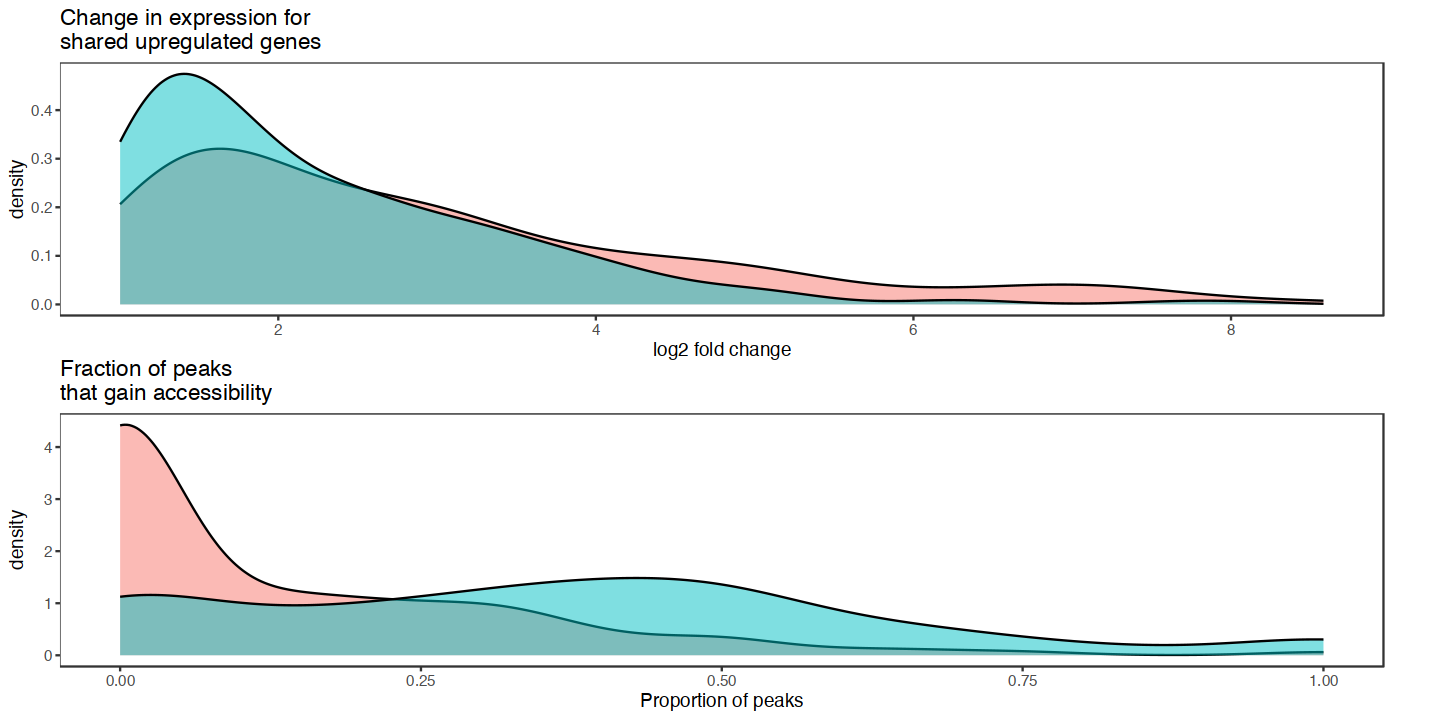

In [85]:
# plotting densities
g1 = ggplot() + geom_density(data=frac_24h, aes(x=b24_frac), fill="#F8766D", alpha=0.5) +
           geom_density(data=frac_24h, aes(x=e24_frac), fill="#00BFC4", alpha=0.5) +
           ggtitle("Fraction of peaks\nthat gain accessibility") + xlab("Proportion of peaks") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0,1,0,0), "cm"))

g2 = ggplot() + geom_density(data=frac_24h, aes(x=b24_lfc), fill="#F8766D", alpha=0.5) +
           geom_density(data=frac_24h, aes(x=e24_lfc), fill="#00BFC4", alpha=0.5) +
           ggtitle("Change in expression for\nshared upregulated genes") + xlab("log2 fold change") +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              plot.margin = unit(c(0,1,0,0), "cm"))

options(repr.plot.width=12, repr.plot.height=6)
g2 / g1
ggsave("../output/230620_er_shared_up_genes.pdf", width=4, height=5)
# wilcox test 
with(frac_24h, wilcox.test(b24_frac, e24_frac))
median(frac_24h$b24_frac)
median(frac_24h$e24_frac)
with(frac_24h, wilcox.test(b24_lfc, e24_lfc))

Warning message:
“Removed 70 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 70 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 158 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 70 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 70 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 218 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


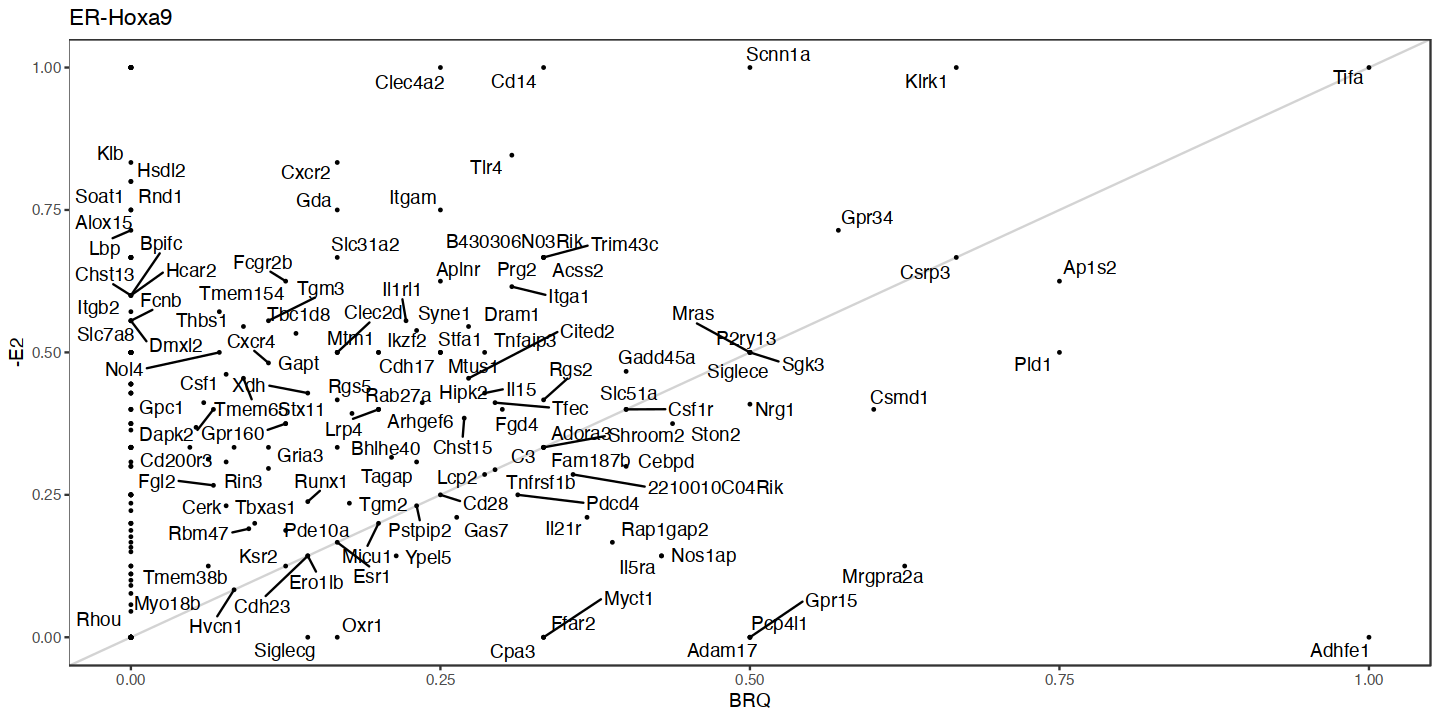

In [86]:
frac_24h$labels = ""
interesting_genes = c("Ccl6", "Nlrp3", "Tlr13", "Stfa1", "Csf2rb", "Alas1", "Slpi", "Lbp", "Tlr7", "Siglecg", "Aplnr")
frac_24h[which(rownames(frac_24h) %in% interesting_genes), ]$labels = rownames(frac_24h[which(rownames(frac_24h) %in% interesting_genes), ])

g1 = ggplot(frac_24h, aes(x=b24_lfc, y=e24_lfc, label=rownames(frac_24h))) + geom_point(size=0.3) +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank()) +
            geom_text_repel(max.overlaps=8) + xlab("BRQ") + ylab("-E2") + ggtitle("24h RNA LFC")
g2 = ggplot(frac_24h, aes(x=b24_frac, y=e24_frac, label=rownames(frac_24h))) +
            geom_abline(slope=1, intercept=0, color="lightgray") + geom_point(size=0.3) +
           theme_bw() + theme(panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank()) +
            geom_text_repel(force_pull = 20) + xlab("BRQ") + ylab("-E2") + 
            ggtitle("ER-Hoxa9")
    

options(repr.plot.width=12, repr.plot.height=6)
g2
ggsave("../output/230925_er_shared_up_genes_scatter.pdf", width=4, height=4)


In [87]:
with(frac_24h, sum(b24_frac > e24_frac, na.rm=T))
with(frac_24h, sum(b24_frac == e24_frac, na.rm=T))
with(frac_24h, sum(b24_frac < e24_frac, na.rm=T))

[1] 24

[1] 62

[1] 171